In [1]:
%matplotlib inline
# Imports Required for random forest
# Pandas is used for data manipulation, h5py for data (conda install h5py)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from os.path import join
from glob import glob
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import h5py
import numpy.ma as ma
import pvlib


# Load Idaho Data

In [2]:
#idaho_flux_data = pd.read_csv('/Users/mccandle/Documents/CurrentProjects/Reinvestment/FRD_ECFlux_2015-2017.csv')
#idaho_met_data = pd.read_csv('/Users/mccandle/Documents/CurrentProjects/Reinvestment/FRD_TallTower_Met_2015-2017.csv')
idaho_flux_data = pd.read_csv("/Users/dgagne/data/FDR-Idaho_csv/FRD_ECFlux_2015-2017.csv")
idaho_met_data = pd.read_csv("/Users/dgagne/data/FRD-Idaho/FRD_TallTower_Met_2015-2017.csv")

In [3]:
idaho_flux_no_missing = idaho_flux_data.replace(-9999.0, np.NaN).dropna(axis=0,how='any')
print(idaho_flux_no_missing.shape)
print(idaho_flux_data.shape)
idaho_met_no_missing = idaho_met_data.replace(-999.0, np.NaN).dropna(axis=0,how='any')
print(idaho_met_no_missing.shape)
print(idaho_met_data.shape)

idaho_flux_data['Tau1'] = idaho_flux_data.rolling(window=2)['Tau'].mean()
idaho_flux_data['H1'] = idaho_flux_data.rolling(window=2)['H'].mean()
idaho_flux_data['LE1'] = idaho_flux_data.rolling(window=2)['LE'].mean()

idaho_flux_data['Tau'] = idaho_flux_data['Tau1']
idaho_flux_data['H'] = idaho_flux_data['H1']
idaho_flux_data['LE'] = idaho_flux_data['LE1']

(42637, 11)
(52608, 11)
(295101, 44)
(315648, 44)


In [4]:
for col in idaho_flux_data.columns:
    print(col)
    
    
print(idaho_flux_data['date'][2])
print(idaho_flux_data['time'][2])

date
time
DOY
daytime
Tau
H
LE
co2_flux
h2o_flux
air_density
air_heat_capacity
Tau1
H1
LE1
1/1/2015
1:30


In [5]:
for col in idaho_met_data.columns:
    print(col)

Year
Month
Day
Hour
Minute
2m Wind Speed m/s
2m Wind Gust m/s
2m Wind Dir deg
2m Sigma Theta deg
10m Wind Speed m/s
10m Wind Gust m/s
10m Wind Dir deg
10m Sigma Theta deg
15m Wind Speed m/s
15m Wind Gust m/s
15m Wind Dir deg
15m Sigma Theta deg
45m Wind Speed m/s
45m Wind Gust m/s
45m Wind Dir deg
45m Sigma Theta deg
Top Wind Speed m/s
Top Wind Gust m/s
Top Wind Dir deg
Top Sigma Theta deg
2m Temp C
10m Temp C
15m Temp C
45m Temp C
Top Temp C
2m RH %
Solar Rad w/m^2
BP inches Hg
Rain inches
5cm Water Content
10cm Water Content
20cm Water Content
50cm Water Content
100cm Water Content
5cm Soil Temp C
10cm Soil Temp C
20cm Soil Temp C
50cm Soil Temp C
100cm Soil Temp C


1   2015-01-01 00:10:00
2   2015-01-01 00:15:00
Name: DateTime, dtype: datetime64[ns]
1   2015-01-01 01:00:00
2   2015-01-01 01:30:00
Name: DateTime, dtype: datetime64[ns]
       Year  Month  Day  Hour  Minute  2m Wind Speed m/s  2m Wind Gust m/s  \
0      2015      1    1     0      30                0.9               1.4   
1      2015      1    1     1       0                1.3               1.6   
2      2015      1    1     1      30                1.4               1.6   
3      2015      1    1     2       0                0.7               1.0   
4      2015      1    1     2      30                1.3               1.4   
...     ...    ...  ...   ...     ...                ...               ...   
40679  2017     12   31    18       0                0.7               0.7   
40680  2017     12   31    18      30                0.8               0.8   
40681  2017     12   31    19       0                0.6               0.9   
40682  2017     12   31    19      30           

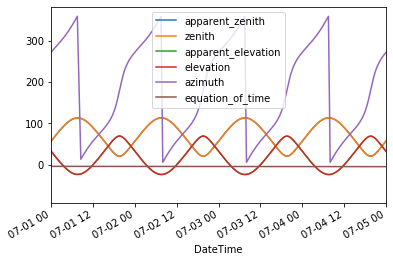

In [8]:
idaho_met_no_missing['Year'].astype(int)
idaho_met_no_missing['Month'].astype(int)
idaho_met_no_missing['Day'].astype(int)
idaho_met_no_missing['Hour'].astype(int)
idaho_met_no_missing['Minute'].astype(int)

year = idaho_met_no_missing.iloc[1:,0]
month = idaho_met_no_missing.iloc[1:,1]
day = idaho_met_no_missing.iloc[1:,2]
hour = idaho_met_no_missing.iloc[1:,3]
minute = idaho_met_no_missing.iloc[1:,4]

#idaho_met_no_missing['date'] = pd.to_datetime((idaho_met_no_missing.Year*10000+idaho_met_no_missing.Month*100+idaho_met_no_missing.Day).apply(str),format='%Y%M%d')
#print(idaho_met_no_missing['date'][1:3])

idaho_met_no_missing['DateTime'] = idaho_met_no_missing[['Year', 'Month', 'Day', 'Hour','Minute']].apply(lambda s : datetime.datetime(*s),axis = 1)
print(idaho_met_no_missing['DateTime'][1:3])

idaho_flux_no_missing['DateTime'] = idaho_flux_no_missing.date.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
#idaho_flux_no_missing['DateTime3'] = idaho_flux_no_missing.time.apply(lambda y: pd.to_datetime(y).strftime('%h:m'))
#idaho_flux_no_missing['DateTime2'] = pd.to_datetime(idaho_flux_no_missing.DateTime) 
#print(idaho_flux_no_missing['DateTime3'][-5:-1])

idaho_flux_no_missing['DateTime'] = idaho_flux_no_missing['DateTime'] + ' ' + idaho_flux_no_missing['time']
#print(idaho_flux_no_missing['Test'][-5:-1])
#idaho_flux_no_missing['DateTime'] = idaho_flux_no_missing.Test.apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d %H:%M:%S'))
idaho_flux_no_missing['DateTime'] = pd.to_datetime(idaho_flux_no_missing['DateTime'])
print(idaho_flux_no_missing['DateTime'][1:3])

result = pd.merge(idaho_met_no_missing,idaho_flux_no_missing,on='DateTime')
print(result)

#lat = 43.06
#lon = -116.74
lat = 43.5897
lon = -112.939933
elevation = 1492.6
solpos = pvlib.solarposition.get_solarposition(result['DateTime'],lat,lon, altitude=elevation)
print(solpos.head())
solpos.plot()
plt.xlim("2015-07-01", "2015-07-05")
print(solpos.zenith.shape)
result['solar_zenith_angle'] = np.array(solpos['zenith'])


In [9]:
# Unit Conversion from C to K
def celsius_to_kelvin(temperature_c):
    return temperature_c + 273.15

# Unit Conversion from wind speed to wind components
def wind_components(wind_speed_m_s, wind_direction_degrees):
    math_dir = 270 - wind_direction_degrees
    math_dir[math_dir < 0] = 360 + math_dir[math_dir < 0]
    u = wind_speed_m_s * np.cos(np.radians(math_dir))
    v = wind_speed_m_s * np.sin(np.radians(math_dir))
    return u, v

# Unit Conversion from temperature and pressure to potential temperature
def inHg_to_hpa(pressure_inHg):
    """
    Convert pressure in inches of mercury (inHg) to pressure in hectopascals (hpa)

    Args:
        pressure_inHg: The air pressure in units inHg

    Returns:
        The air pressure in units hpa
    """
    return pressure_inHg * 33.86

def potential_temperature(temperature_k, pressure_hpa, pressure_reference_hpa=1000.0):
    """
    Convert temperature to potential temperature based on the available pressure. Potential temperature is at a
    reference pressure of 1000 mb.

    Args:
        temperature_k: The air temperature in units K
        pressure_hpa: The atmospheric pressure in units hPa
        pressure_reference_hpa: The reference atmospheric pressure for the potential temperature in hPa;
            default 1000 hPa

    Returns:
        The potential temperature in units K
    """
    return temperature_k * (pressure_reference_hpa / pressure_hpa) ** (2.0 / 7.0)

def friction_velocity(tau, density):
    """
    Compute friction velocity from tau and air density.

    Args:
        tau: The surface stress
        pressure_hpa: The atmospheric density in kg/m^3

    Returns:
        The friction velocity
    """
    u2 = np.array(result['Tau']) / np.array(result['air_density'])
    fv = np.sqrt(tau/density)
    return fv

def temperature_scale(sensible_heat_flux_W_m2, air_density_kg_m3, friction_velocity_m_s,
                      min_friction_velocity=0.001, min_sensible_heat_flux_mag=0.001):
    """
    Caclulate the temperature turbulence scale value theta* from the sensible heat flux.

    Args:
        sensible_heat_flux_W_m2: The sensible heat flux in units W m-2.
        air_density_kg_m3: The density of air in units kg m-3.
        friction_velocity_m_s: The friction velocity in units m s-1.

    Returns:
        The temperature turbulence scale value in units K.
    """
    heat_flux_sign = np.where(sensible_heat_flux_W_m2 >= 0, 1, -1)
    heat_flux_adjusted = heat_flux_sign * np.maximum(np.abs(sensible_heat_flux_W_m2), min_sensible_heat_flux_mag)
    return -heat_flux_adjusted / (air_density_kg_m3 * 287.0 * 7.0 / 2.0 *
                                  np.maximum(friction_velocity_m_s, min_friction_velocity))

def virtual_temperature(temperature_k, mixing_ratio_g_kg):
    """
    Convert temperature and mixing ratio to virtual temperature.

    Args:
        temperature_k: The temperature or potential temperature in units K.
        mixing_ratio_kg_kg: The mixing ratio in units kg kg-1.

    Returns:
        The virtual temperature in units K.
    """
    return temperature_k * (1 + 0.61 * mixing_ratio_g_kg / 1000.0)

def moisture_scale(latent_heat_flux_W_m2, air_density_kg_m3, friction_velocity_m_s,
                   min_friction_velocity=0.001, min_latent_heat_flux_mag=0.001):
    """
    Calculate the turblulent moisture scale factor from the latent heat flux.

    Args:
        latent_heat_flux_W_m2: Latent heat flux in units W m-2
        air_density_kg_m3: Density of air in units kg m-3
        friction_velocity_m_s: The friction velocity (u*) in units m s-1

    Returns:
        The turbulent moisture scale factor in g kg-1
    """
    latent_heat_of_vaporization_J_kg = 2264705.0  # J kg-1
    heat_flux_sign = np.where(latent_heat_flux_W_m2 >= 0, 1, -1)
    heat_flux_adjusted = heat_flux_sign * np.maximum(np.abs(latent_heat_flux_W_m2), min_latent_heat_flux_mag)
    g_per_kg = 1000.0
    return heat_flux_adjusted / (latent_heat_of_vaporization_J_kg * air_density_kg_m3
                                 * np.maximum(friction_velocity_m_s, min_friction_velocity)) * g_per_kg


def obukhov_length(potential_temperature_k, temperature_scale_k, friction_velocity_m_s, von_karman_constant=0.4,
                   min_friction_velocity=0.01, min_temperature_scale=0.01):
    """
    Caclulates the Obukhov length, a measure of stability based on the friction velocity and temperature scale.

    Args:
        potential_temperature_k: The potential temperature in units K
        temperature_scale_k: The turbulent temperature scale (theta*) in units K
        friction_velocity_m_s: The friction velocity (u*) in units m s-1
        von_karman_constant: The von Karman constant (default=0.4)

    Returns:
        The Obukhov length in units m.
    """
    g = 9.81 # m s-2
    temperature_scale_sign = np.where(temperature_scale_k >= 0, 1, -1)
    adjusted_temperature_scale = temperature_scale_sign * np.maximum(np.abs(temperature_scale_k), min_temperature_scale)
    return np.maximum(friction_velocity_m_s, min_friction_velocity) ** 2 * potential_temperature_k / (
            von_karman_constant * g * adjusted_temperature_scale)

def mixing_ratio(temp_2m_C, relative_humidity, pressure_hpa):
    """
    Calculate the mixing ratio.

    Args:
        temp_2m_C: 2-meter temperature in units of Celcius
        relative humidity: as a percentage
        pressure_hpa: atmospheric pressure in hPa

    Returns:
        The mixing ratio 
    """
    saturation_vapor_pressure= (0.6108 * np.exp(17.27 * temp_2m_C / (temp_2m_C + 237.3)))*10
    vapor_pressure = relative_humidity / 100 * saturation_vapor_pressure 
    return 621.97 * vapor_pressure / (pressure_hpa-vapor_pressure), vapor_pressure, saturation_vapor_pressure

def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

def saturation_mixing_ratio(temperature_K, pressure_hPa):
    """
    Calculate saturation mixing ratio from temperature and pressure
    Args:
        temperature_K: temperature in Kelvin
        pressure_hPa: pressure in hPA
    Returns:
        saturation mixing ratio in g kg-1
    """
    es = saturation_vapor_pressure(temperature_K)
    epsilon = 0.622
    return epsilon * es / (pressure_hPa - es) * 1000.0

def bulk_richardson_number(potential_temperature_k, height,
                           mixing_ratio_g_kg, virtual_potential_skin_temperature_k, wind_speed_m_s,
                           minimum_wind_speed=1):
    """
    Calculate the bulk Richardson number, a measure of stability.

    Args:
        potential_temperature_k: The potential or virtual potential temperature in K
        height: The height at which the potential temperature calculation is performed in m.
        mixing_ratio_kg_kg: The mixing ratio at the same height as the potential temperature in units kg kg-1.
        virtual_potential_skin_temperature_k: The virtual potential temperature at the surface
        wind_speed_m_s: The wind speed in m s-1

    Returns:

    """
    g = 9.81  # m s-2
    virtual_potential_temperature_k = virtual_temperature(potential_temperature_k, mixing_ratio_g_kg)
    return g / potential_temperature_k * height * (virtual_potential_temperature_k
                                                   - virtual_potential_skin_temperature_k) / \
           np.maximum(wind_speed_m_s ** 2, minimum_wind_speed ** 2)

# Need to convert Idaho data from celsius to kelvin
result['2m Temp K'] = celsius_to_kelvin(result['2m Temp C'])
result['10m Temp K'] = celsius_to_kelvin(result['10m Temp C'])
result['15m Temp K'] = celsius_to_kelvin(result['15m Temp C'])
result['45m Temp K'] = celsius_to_kelvin(result['45m Temp C'])

# Need to convert Idaho data to wind components from speed and direction
result['2m U-Wind m/s'],result['2m V-Wind m/s'] = wind_components(result['2m Wind Speed m/s'],result['2m Wind Dir deg'])
result['10m U-Wind m/s'],result['10m V-Wind m/s'] = wind_components(result['10m Wind Speed m/s'],result['10m Wind Dir deg'])
result['15m U-Wind m/s'],result['15m V-Wind m/s'] = wind_components(result['15m Wind Speed m/s'],result['15m Wind Dir deg'])
result['45m U-Wind m/s'],result['45m V-Wind m/s'] = wind_components(result['45m Wind Speed m/s'],result['45m Wind Dir deg'])

# Need to convert temperatures in inches of mercury to hectopascals
result['Barometric Pressure hpa'] = inHg_to_hpa(result['BP inches Hg'])  

# Need to convert from Kelvin to Potential Temperature
result['2m potential temperature k'] = potential_temperature(result['2m Temp K'],result['Barometric Pressure hpa'])    
result['10m potential temperature k'] = potential_temperature(result['10m Temp K'],result['Barometric Pressure hpa'])
result['15m potential temperature k'] = potential_temperature(result['15m Temp K'],result['Barometric Pressure hpa'])
result['45m potential temperature k'] = potential_temperature(result['45m Temp K'],result['Barometric Pressure hpa'])

# Compute the friction velocity
result['friction velocity'] = friction_velocity(result['Tau'],result['air_density'])

# Compute the temperature scale
result['temperature scale'] = temperature_scale(result['H'],result['air_density'],result['friction velocity'])

# Compute the moisture scale
result['moisture scale'] = moisture_scale(result['LE'],result['air_density'],result['friction velocity'])

# Compute the Monin Obukhov Length
result['obukhov length'] = obukhov_length(result['2m potential temperature k'], result['temperature scale'], 
                                          result['friction velocity'], von_karman_constant=0.4)

# Compute the mixing ratio
result['2m mixing ratio g_kg'], vapor_pressure, saturation_vapor_pressure = mixing_ratio(result['2m Temp C'], result['2m RH %'], result['Barometric Pressure hpa'])

# Compute the virtual potential temperature
result['2m virtual potential temperature'] = virtual_temperature(result['2m potential temperature k'], 
                                                                 result['2m mixing ratio g_kg'])
# Compute the Bulk Richardson Number
result['bulk richardson number'] = bulk_richardson_number(result['2m potential temperature k'], 2, 
                                                          result['2m mixing ratio g_kg'], 
                                                          result['2m virtual potential temperature'], 
                                                          result['2m Wind Speed m/s'])


In [11]:
# Try computing Bulk Richardson Number between 10M and 2M
# Compute the Bulk Richardson Number
result['10m bulk richardson number'] = bulk_richardson_number(result['10m potential temperature k'], 10, 
                                                          result['2m mixing ratio g_kg'], 
                                                          result['2m virtual potential temperature'], 
                                                          result['2m Wind Speed m/s'])
# Try computing Bulk Richardson Number between 2M and 5cm soil temperature
# Compute the Bulk Richardson Number
# Compute the virtual potential temperature

result['5cm Soil Temp K'] = celsius_to_kelvin(result['5cm Soil Temp C'])
result['5cm potential temperature k'] = potential_temperature(result['5cm Soil Temp K'],result['Barometric Pressure hpa'])
result['5cm virtual potential temperature'] = virtual_temperature(result['5cm potential temperature k'], 
                                                                 result['2m mixing ratio g_kg'])
result['Soil bulk richardson number'] = bulk_richardson_number(result['2m potential temperature k'], 10, 
                                                          result['2m mixing ratio g_kg'], 
                                                          result['5cm virtual potential temperature'], 
                                                          result['2m Wind Speed m/s'])

result["roughness length surface m"] = np.minimum(9, np.maximum(0.001, 10 * np.exp(-0.4 * np.maximum(result["10m Wind Speed m/s"], 1) / result["friction velocity"])))



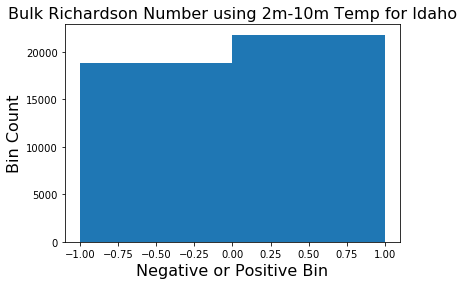

In [12]:
result['10m bulk richardson number'].drop(result['10m bulk richardson number'].idxmax())
result["BRN_sign"] = np.sign(result['10m bulk richardson number'])
plt.title('Bulk Richardson Number using 2m-10m Temp for Idaho', size = 16)
plt.xlabel('Negative or Positive Bin', size = 16)
plt.ylabel('Bin Count', size = 16)
plt.hist(result["BRN_sign"],bins=2)
plt.savefig('BRN_2-10m_idaho.png')

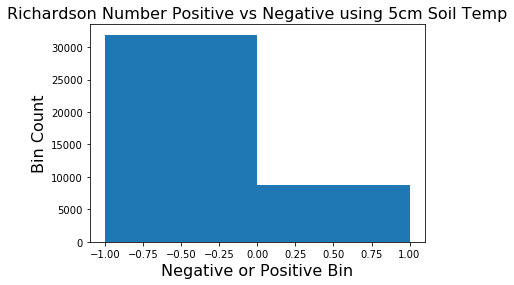

In [13]:
result['Soil bulk richardson number'].drop(result['Soil bulk richardson number'].idxmin())
result["BRN_sign_5cm"] = np.sign(result['Soil bulk richardson number'])
plt.title('Richardson Number Positive vs Negative using 5cm Soil Temp', size = 16)
plt.xlabel('Negative or Positive Bin', size = 16)
plt.ylabel('Bin Count', size = 16)
plt.hist(result["BRN_sign_5cm"],bins=2)
plt.savefig('BRN_5cmSoil-10m_idaho.png')

In [14]:
# Subset into different years for training and testing
# Set training years as 2015, 2016 and predict 2017
#resultTest = result[(result['Year'] == 2017)]
#resultTrain = result[(result['Year'] != 2017)]
# Set training years as 2015, 2017 and predict 2016
#resultTest = result[(result['Year'] == 2016)]
#resultTrain = result[(result['Year'] != 2016)]
# Set training years as 2016, 2017 and predict 2015
resultTest = result[(result['Year'] == 2015)]
resultTrain = result[(result['Year'] != 2015)]
print(resultTrain.shape)
print(resultTest.shape)

(28914, 89)
(11770, 89)


In [91]:
resultTest.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', '2m Wind Speed m/s',
       '2m Wind Gust m/s', '2m Wind Dir deg', '2m Sigma Theta deg',
       '10m Wind Speed m/s', '10m Wind Gust m/s', '10m Wind Dir deg',
       '10m Sigma Theta deg', '15m Wind Speed m/s', '15m Wind Gust m/s',
       '15m Wind Dir deg', '15m Sigma Theta deg', '45m Wind Speed m/s',
       '45m Wind Gust m/s', '45m Wind Dir deg', '45m Sigma Theta deg',
       'Top Wind Speed m/s', 'Top Wind Gust m/s', 'Top Wind Dir deg',
       'Top Sigma Theta deg', '2m Temp C', '10m Temp C', '15m Temp C',
       '45m Temp C', 'Top Temp C', '2m RH %', 'Solar Rad w/m^2',
       'BP inches Hg', 'Rain inches', '5cm Water Content',
       '10cm Water Content', '20cm Water Content', '50cm Water Content',
       '100cm Water Content', '5cm Soil Temp C', '10cm Soil Temp C',
       '20cm Soil Temp C', '50cm Soil Temp C', '100cm Soil Temp C', 'DateTime',
       'date', 'time', 'DOY', 'daytime', 'Tau', 'H', 'LE', 'co2_flux',
       'h2o_flux',

# Create Training and Test Sets for Idaho and Train RF

In [15]:
# Test adding in Bulk Richardson Number as a Predictor
dataset = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
dataset['LowLevel Potential Temp K'] = resultTrain['10m potential temperature k']
dataset['MidLevel Potential Temp K'] = resultTrain['15m potential temperature k']
dataset['TopLevel Potential Temp K'] = resultTrain['45m potential temperature k']
dataset['LowLevel Wind Speed m/s'] = resultTrain['10m Wind Speed m/s']
dataset['LowLevel Wind Dir deg'] = resultTrain['10m Wind Dir deg']
dataset['MidLevel Wind Speed m/s'] = resultTrain['15m Wind Speed m/s']
dataset['MidLevel Wind Dir deg'] = resultTrain['15m Wind Dir deg']
dataset['TopLevel Wind Speed m/s'] = resultTrain['45m Wind Speed m/s']
dataset['TopLevel Wind Dir deg'] = resultTrain['45m Wind Dir deg']
dataset['2m RH %'] = resultTrain['2m RH %']
dataset['0m GHI w/m^2'] = resultTrain['Solar Rad w/m^2']
dataset['2m Pressure hPa'] = resultTrain['Barometric Pressure hpa']
dataset['0m Solar Zenith Angle deg'] = resultTrain['solar_zenith_angle']
dataset['TopLevel Soil Water Content m3/m3'] = resultTrain['5cm Water Content']
dataset['TopLevel Soil Temp K'] = resultTrain['5cm Soil Temp C']
dataset['10m Bulk Richardson'] = resultTrain['10m bulk richardson number']
# These are potentially needed for other computations, but not as predictors
dataset['10m Temp K'] = resultTrain['10m Temp K']
dataset['2m Temp K'] = resultTrain['2m Temp K']
dataset['10m U-Wind m/s'] = resultTrain['10m U-Wind m/s']
dataset['10m V-Wind m/s'] = resultTrain['10m V-Wind m/s']

datasetTest = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
datasetTest['LowLevel Potential Temp K'] = resultTest['10m potential temperature k']
datasetTest['MidLevel Potential Temp K'] = resultTest['15m potential temperature k']
datasetTest['TopLevel Potential Temp K'] = resultTest['45m potential temperature k']
datasetTest['LowLevel Wind Speed m/s'] = resultTest['10m Wind Speed m/s']
datasetTest['LowLevel Wind Dir deg'] = resultTest['10m Wind Dir deg']
datasetTest['MidLevel Wind Speed m/s'] = resultTest['15m Wind Speed m/s']
datasetTest['MidLevel Wind Dir deg'] = resultTest['15m Wind Dir deg']
datasetTest['TopLevel Wind Speed m/s'] = resultTest['45m Wind Speed m/s']
datasetTest['TopLevel Wind Dir deg'] = resultTest['45m Wind Dir deg']
datasetTest['2m RH %'] = resultTest['2m RH %']
datasetTest['0m GHI w/m^2'] = resultTest['Solar Rad w/m^2']
datasetTest['2m Pressure hPa'] = resultTest['Barometric Pressure hpa']
datasetTest['0m Solar Zenith Angle deg'] = resultTest['solar_zenith_angle']
datasetTest['TopLevel Soil Water Content m3/m3'] = resultTest['5cm Water Content']
datasetTest['TopLevel Soil Temp K'] = resultTest['5cm Soil Temp C']
datasetTest['10m Bulk Richardson'] = resultTest['10m bulk richardson number']
# These are potentially needed for other computations, but not as predictors
datasetTest['10m Temp K'] = resultTest['10m Temp K']
datasetTest['2m Temp K'] = resultTest['2m Temp K']
datasetTest['10m U-Wind m/s'] = resultTest['10m U-Wind m/s']
datasetTest['10m V-Wind m/s'] = resultTest['10m V-Wind m/s']

featuresM = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresB = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresF = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']

MoistureScaleTrain = resultTrain['moisture scale']
TemperatureScaleTrain = resultTrain['temperature scale']
FrictionVelocityTrain = resultTrain['friction velocity']

MoistureScaleTest = resultTest['moisture scale']
TemperatureScaleTest = resultTest['temperature scale']
FrictionVelocityTest = resultTest['friction velocity']

# Put in nomenclature so that either yearly or random split can be used
train_featuresM = dataset
train_labelsM = MoistureScaleTrain
train_featuresF = dataset
train_labelsF = FrictionVelocityTrain
train_featuresT = dataset
train_labelsT = TemperatureScaleTrain

test_featuresM = datasetTest
test_labelsM = MoistureScaleTest
test_featuresF = datasetTest
test_labelsF = FrictionVelocityTest
test_featuresT = datasetTest
test_labelsT = TemperatureScaleTest

#train_featuresM = train_featuresM.iloc[:,0:14]




######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
#rfM = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
#rfT = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
#rfF = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)

rfM = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 1024,criterion='mse', verbose=2)
rfT = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 1024,criterion='mse', verbose=2)
rfF = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 1024,criterion='mse', verbose=2)

# Train the model on training data
rfM.fit(train_featuresM.iloc[:,0:16], train_labelsM);
rfF.fit(train_featuresF.iloc[:,0:16], train_labelsF);
rfT.fit(train_featuresT.iloc[:,0:16], train_labelsT);

# Use the forest's predict method on the test data
predictionsM = rfM.predict(test_featuresM.iloc[:,0:16])
predictionsT = rfT.predict(test_featuresT.iloc[:,0:16])
predictionsF = rfF.predict(test_featuresF.iloc[:,0:16])

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM = abs(predictionsM - test_labelsM)
errorsT = abs(predictionsT - test_labelsT)
errorsF = abs(predictionsF - test_labelsF)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF), 4))
print('Moisture Scale Mean: ',np.mean(MoistureScaleTest))
print('Moisture Scale Standard Deviation: ',np.std(MoistureScaleTest))
print('Temperature Scale Mean: ',np.mean(TemperatureScaleTest))
print('Temperature Scale Standard Deviation: ',np.std(TemperatureScaleTest))
print('Friction Velocity Mean: ',np.mean(FrictionVelocityTest))
print('Friction Velocity Standard Deviation: ',np.std(FrictionVelocityTest))

# Feature selection
importancesM = list(rfM.feature_importances_)
feature_listM = featuresM
feature_importancesM = [(featuresM,round(importancesM,2)) for featuresM, importancesM in zip(feature_listM,importancesM)]
feature_importancesM = sorted(feature_importancesM,key = lambda x: x[1],reverse=True)
print("Features importances for predicting moisture scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesM];

# Feature selection
importancesT = list(rfT.feature_importances_)
feature_listT = featuresB
feature_importancesT = [(featuresT,round(importancesT,2)) for featuresT, importancesT in zip(feature_listT,importancesT)]
feature_importancesT = sorted(feature_importancesT,key = lambda x: x[1],reverse=True)
print("Features importances for predicting temperature scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesT];

# Feature selection
importancesF = list(rfF.feature_importances_)
featuresF = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
feature_listF = featuresF
feature_importancesF = [(featuresF,round(importancesF,2)) for featuresF, importancesF in zip(feature_listF,importancesF)]
feature_importancesF = sorted(feature_importancesF,key = lambda x: x[1],reverse=True)
print("Features importances for predicting friction velocity")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesF];

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.2s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200building tree 78 

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    9.9s


building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   12.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200
building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.8s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   11.9s


building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   15.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200building tree 23 of 200

building tree 24 of 200
building tree 25 of 200building tree 26 of 200

building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.5s


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200building tree 50 of 200

building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200building tree 62 of 200

building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   11.6s


building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200building tree 171 of 200

building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   15.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Mean Absolute Error for predicting Moisture Scale: 0.0237
Mean Absolute Error for predicting Temperature Scale: 0.0798
Mean Absolute Error for predicting Friction Velocity: 0.0467
Moisture Scale Mean:  0.024799827182640313
Moisture Scale Standard Deviation:  0.06228143833030082
Temperature Scale Mean:  -0.16748345962055045
Temperature Scale Standard Deviation:  0.39779457382886924
Friction Velocity Mean:  0.2926149115470218
Friction Velocity Standard Deviation:  0.21440500863554876
Features importances for predicting moisture scale
Variable:0m GHI w/m^2         Importance: 0.3
Variable:10m bulk richardson number Importance: 0.17
Variable:5cm Water Content    Importance: 0.16
Variable:5cm Soil Temp C      Importance: 0.1
Variable:2m RH %              Importance: 0.05
Variable:TopLevel Wind Speed m/s Importance: 0.03
Variable:2m Pressure hPa      Importance: 0.03
Variable:0m Solar Zenith Angle deg Importance: 0.03
Variable:LowLevel Potential Temp K Importance: 0.02
Variable:MidLevel Pote

## Feature Importance Random forest Idaho

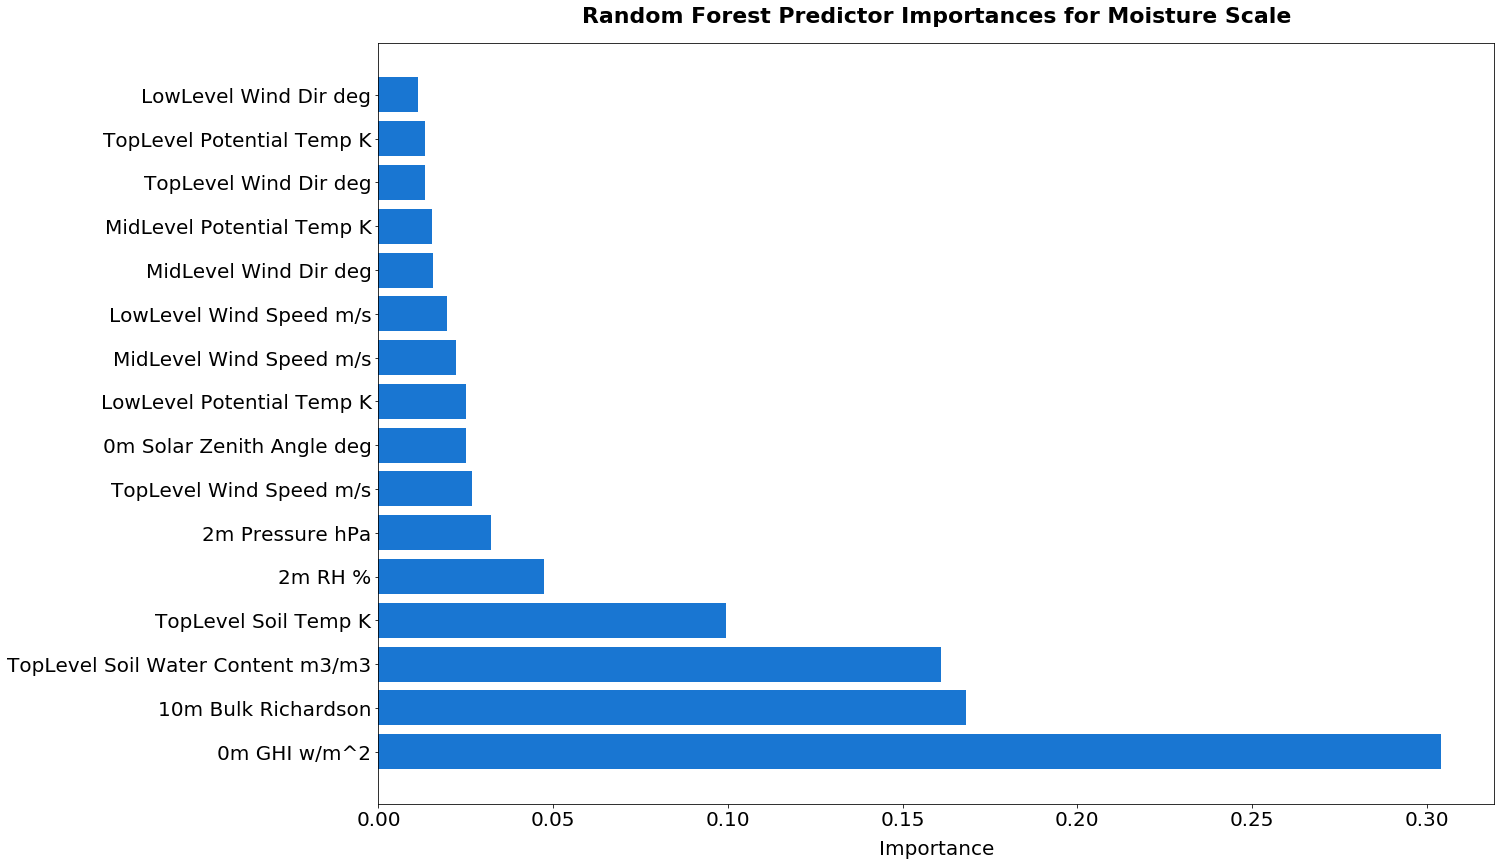

In [16]:
dset = pd.DataFrame()
train_featuresM = train_featuresM.iloc[:,0:16]
dset['attr'] = train_featuresM.columns
dset['importance'] = rfM.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importances for Moisture Scale', fontsize=22, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlabel('Importance', fontsize=20, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-MoistureScale-Idaho.png')
plt.show()

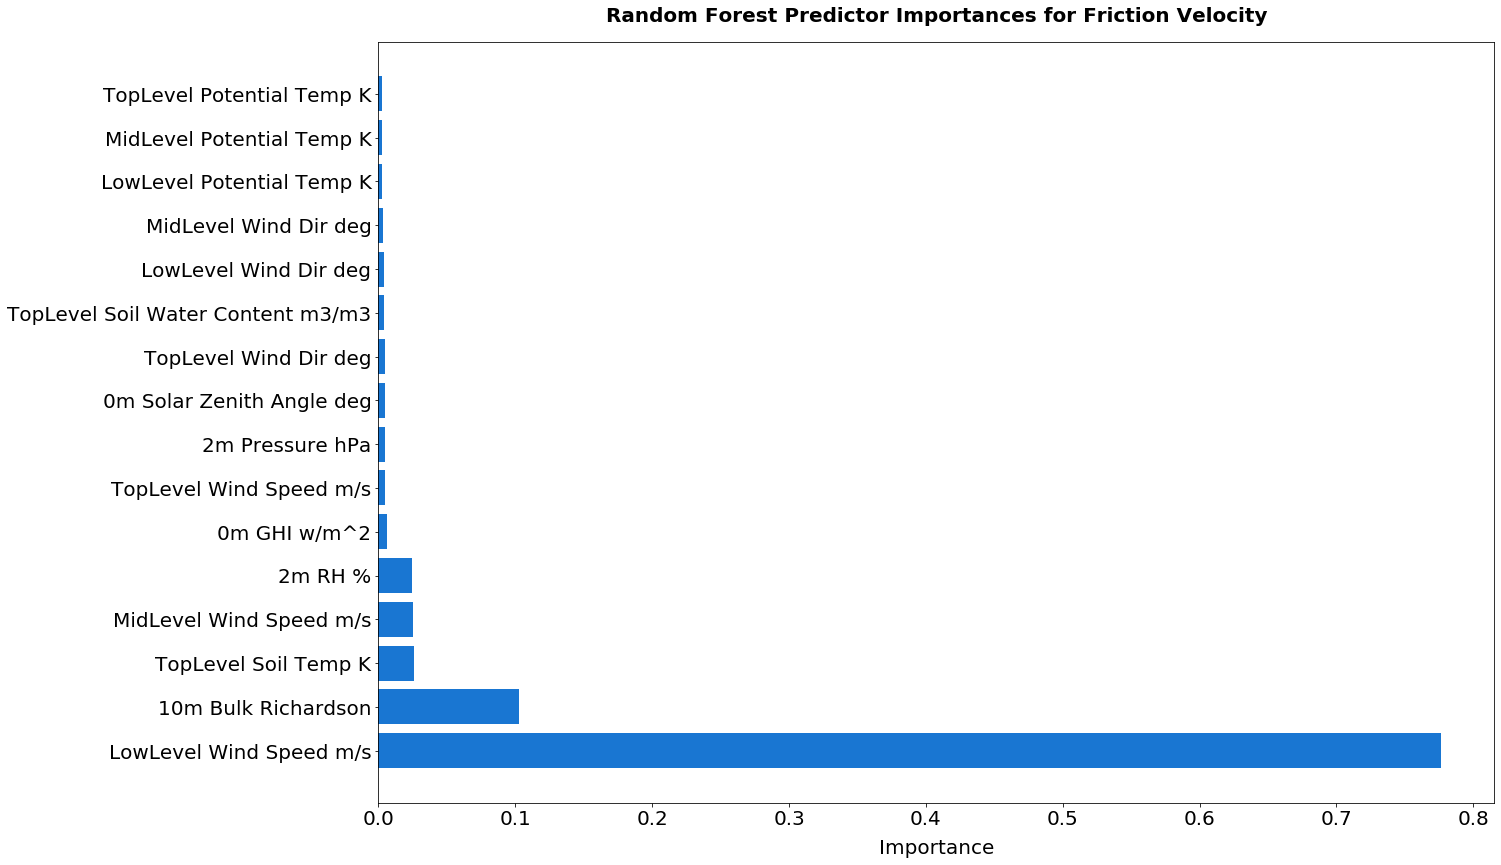

In [17]:
dset = pd.DataFrame()
train_featuresF = train_featuresF.iloc[:,0:16]
dset['attr'] = train_featuresF.columns
dset['importance'] = rfF.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importances for Friction Velocity', fontsize=20, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlabel('Importance', fontsize=20, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-FrictionVelocity-Idaho.png')
plt.show()

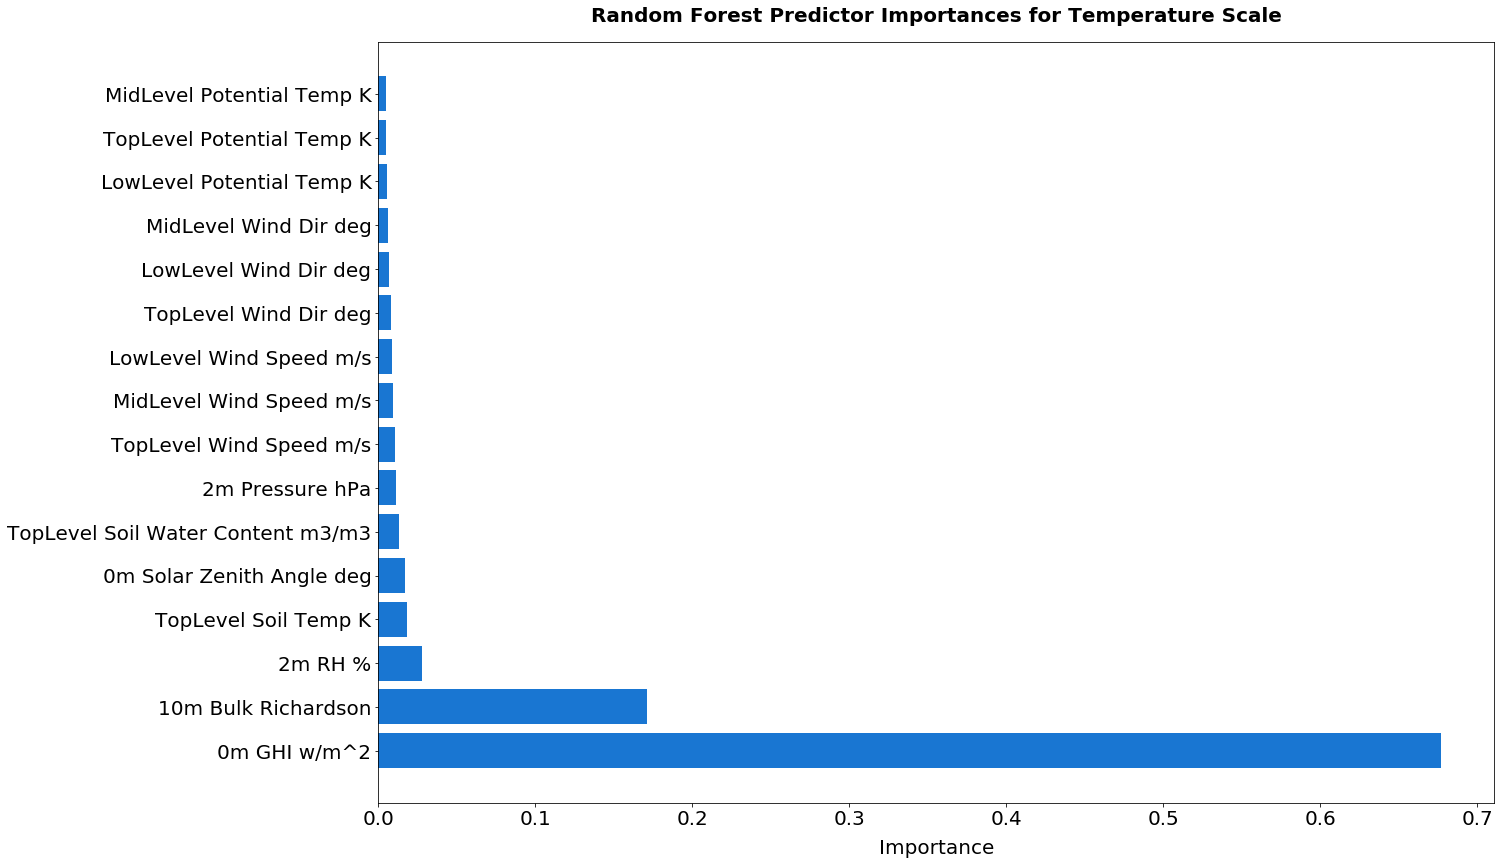

In [18]:
dset = pd.DataFrame()
train_featuresT = train_featuresT.iloc[:,0:16]
dset['attr'] = train_featuresT.columns
dset['importance'] = rfT.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importances for Temperature Scale', fontsize=20, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlabel('Importance', fontsize=20, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-TemperatureScale-Idaho.png')
plt.show()

## Train Neural Net Idaho

In [19]:
## Update this to train ANN rather than RF for different regimes
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
def build_model(train_data):
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu",
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    #batch_size=512
    model.compile(loss='mae',
                 optimizer=optimizer,
                 metrics=['mae'])
    return model

# Train ANN on negative BRN predictions
EPOCHS = 30
batch_size=128

######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
ANN_M = build_model(np.asarray(train_featuresM.iloc[:,0:16]))
ANN_T = build_model(np.asarray(train_featuresT.iloc[:,0:16]))
ANN_F = build_model(np.asarray(train_featuresF.iloc[:,0:16]))
scaler_M = StandardScaler()
train_features_norm = scaler_M.fit_transform(train_featuresM.iloc[:,0:16])
# Train the model on training data
historyM = ANN_M.fit(train_features_norm, np.asarray(train_labelsM), batch_size=batch_size, epochs=EPOCHS, validation_split=0.2,verbose=1)
historyF = ANN_F.fit(train_features_norm, np.asarray(train_labelsF), batch_size=batch_size, epochs=EPOCHS, validation_split=0.2,verbose=1)
historyT = ANN_T.fit(train_features_norm, np.asarray(train_labelsT), batch_size=batch_size, epochs=EPOCHS, validation_split=0.2,verbose=1)
test_features_norm  = scaler_M.transform(test_featuresM.iloc[:,0:16])
# Use the forest's predict method on the test data
ANNpredictionsM = ANN_M.predict(test_features_norm)
ANNpredictionsT = ANN_T.predict(test_features_norm)
ANNpredictionsF = ANN_F.predict(test_features_norm)

ANNpredictionsM = ANNpredictionsM.reshape(len(ANNpredictionsM,))
ANNpredictionsT = ANNpredictionsT.reshape(len(ANNpredictionsT,))
ANNpredictionsF = ANNpredictionsF.reshape(len(ANNpredictionsF,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsM = abs(ANNpredictionsM - test_labelsM)
ANNerrorsT = abs(ANNpredictionsT - test_labelsT)
ANNerrorsF = abs(ANNpredictionsF - test_labelsF)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsM), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsT), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsF), 4))

Train on 23131 samples, validate on 5783 samples
Epoch 1/30
23131/23131 [==============================] - 1s 39us/sample - loss: 0.0628 - mae: 0.0628 - val_loss: 0.0382 - val_mae: 0.0382
Epoch 2/30
23131/23131 [==============================] - 0s 12us/sample - loss: 0.0336 - mae: 0.0336 - val_loss: 0.0278 - val_mae: 0.0278
Epoch 3/30
23131/23131 [==============================] - 0s 12us/sample - loss: 0.0278 - mae: 0.0278 - val_loss: 0.0238 - val_mae: 0.0238
Epoch 4/30
23131/23131 [==============================] - 0s 13us/sample - loss: 0.0248 - mae: 0.0248 - val_loss: 0.0213 - val_mae: 0.0213
Epoch 5/30
23131/23131 [==============================] - 0s 13us/sample - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0201 - val_mae: 0.0201
Epoch 6/30
23131/23131 [==============================] - 0s 13us/sample - loss: 0.0216 - mae: 0.0216 - val_loss: 0.0188 - val_mae: 0.0188
Epoch 7/30
23131/23131 [==============================] - 0s 13us/sample - loss: 0.0207 - mae: 0.0207 - val_loss: 0.0

## Cabauw Data Loading

In [21]:
#data = pd.read_csv("/Volumes/d1/mccandle/mlsurfacelayer/cabauw_derived_data_20200330_10min_raw.csv", index_col="Time", parse_dates=["Time"])
data = pd.read_csv("/Users/dgagne/data/cabauw_derived_data_20200401_10min_raw.csv", index_col="Time", parse_dates=["Time"]).dropna()


In [22]:
split_date = pd.Timestamp("2011-01-01")
train_data = data.loc[:split_date]
test_data = data.loc[split_date:]

In [297]:
data.columns

Index(['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees', 'temperature_2 m_K', 'temperature_10 m_K',
       'temperature_20 m_K', 'temperature_40 m_K', 'pressure_2 m_hPa',
       'potential temperature_2 m_K', 'potential temperature_10 m_K',
       'potential temperature_20 m_K', 'potential temperature_40 m_K',
       'virtual potential temperature_2 m_K',
       'virtual potential temperature_10 m_K',
       'virtual potential temperature_20 m_K',
       'virtual potential temperature_40 m_K', 'mixing ratio_2 m_g kg-1',
       'mixing ratio_10 m_g kg-1', 'mixing ratio_20 m_g kg-1',
       'mixing ratio_40 m_g kg-1', 'relative humidity_2 m_%',
       'relative humidity_10 m_%', 'relative humidity_20 m_%',
       'relative humidity_40 m_%', 'temperature change_4 m_K m-1',
       'temperature change_15 m_K m-1', 'temperature change_30 m_K m-1',
       'mixing ratio change_4 m_g kg-1 m-1',
       'mixing ratio change_15 m_g kg-1 m-1',
       'mix

In [23]:
input_cols = ['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees',
       'pressure_2 m_hPa', 'potential temperature_10 m_K',
       'potential temperature_2 m_K', 'mixing ratio_10 m_g kg-1',
       'relative humidity_10 m_%',
       'air density_10 m_kg m-3', 'wind speed_10 m_m s-1',
       'wind speed_20 m_m s-1',
       'wind speed_40 m_m s-1',
       'mixing ratio_2 m_g kg-1',
       'relative humidity_2 m_%', 'bulk richardson_10-2 m_']
output_col_1 = 'friction velocity_surface_m s-1'

## Create Cabauw train and test dataframes and random forest

In [25]:
# Test adding in Bulk Richardson Number as a Predictor
datasetC = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
datasetC['LowLevel Potential Temp K'] = train_data['potential temperature_10 m_K']
datasetC['MidLevel Potential Temp K'] = train_data['potential temperature_20 m_K']
datasetC['TopLevel Potential Temp K'] = train_data['potential temperature_40 m_K']
datasetC['LowLevel Wind Speed m/s'] = train_data['wind speed_10 m_m s-1']
datasetC['LowLevel Wind Dir deg'] = train_data['wind direction_10 m_degrees']
datasetC['MidLevel Wind Speed m/s'] = train_data['wind speed_20 m_m s-1']
datasetC['MidLevel Wind Dir deg'] = train_data['wind direction_20 m_degrees']
datasetC['TopLevel Wind Speed m/s'] = train_data['wind speed_40 m_m s-1']
datasetC['TopLevel Wind Dir deg'] = train_data['wind direction_40 m_degrees']
datasetC['2m RH %'] = train_data['relative humidity_2 m_%']
datasetC['0m GHI w/m^2'] = train_data['global horizontal irradiance_0 m_W m-2']
datasetC['2m Pressure hPa'] = train_data['pressure_2 m_hPa']
datasetC['0m Solar Zenith Angle deg'] = train_data['zenith_0 m_degrees']
datasetC['TopLevel Soil Water Content m3/m3'] = train_data['soil water content_3 cm_m3 m-3']
datasetC['TopLevel Soil Temp K'] = train_data['soil temperature_4 cm_K']
datasetC['10m Bulk Richardson'] = train_data['bulk richardson_10-2 m_']
# These are potentially needed for other computations, but not as predictors
datasetC['10m Temp K'] = train_data['temperature_10 m_K']
datasetC['2m Temp K'] = train_data['temperature_2 m_K']
datasetC['10m U-Wind m/s'] = train_data['u wind_10 m_m s-1']
datasetC['10m V-Wind m/s'] = train_data['v wind_10 m_m s-1']

datasetTestC = pd.DataFrame()
# Create datasets for training and testing.  
# Predictors to use:
datasetTestC['LowLevel Potential Temp K'] = test_data['potential temperature_10 m_K']
datasetTestC['MidLevel Potential Temp K'] = test_data['potential temperature_20 m_K']
datasetTestC['TopLevel Potential Temp K'] = test_data['potential temperature_40 m_K']
datasetTestC['LowLevel Wind Speed m/s'] = test_data['wind speed_10 m_m s-1']
datasetTestC['LowLevel Wind Dir deg'] = test_data['wind direction_10 m_degrees']
datasetTestC['MidLevel Wind Speed m/s'] = test_data['wind speed_20 m_m s-1']
datasetTestC['MidLevel Wind Dir deg'] = test_data['wind direction_20 m_degrees']
datasetTestC['TopLevel Wind Speed m/s'] = test_data['wind speed_40 m_m s-1']
datasetTestC['TopLevel Wind Dir deg'] = test_data['wind direction_40 m_degrees']
datasetTestC['2m RH %'] = test_data['relative humidity_2 m_%']
datasetTestC['0m GHI w/m^2'] = test_data['global horizontal irradiance_0 m_W m-2']
datasetTestC['2m Pressure hPa'] = test_data['pressure_2 m_hPa']
datasetTestC['0m Solar Zenith Angle deg'] = test_data['zenith_0 m_degrees']
datasetTestC['TopLevel Soil Water Content m3/m3'] = test_data['soil water content_3 cm_m3 m-3']
datasetTestC['TopLevel Soil Temp K'] = test_data['soil temperature_4 cm_K']
datasetTestC['10m Bulk Richardson'] = test_data['bulk richardson_10-2 m_']
# These are potentially needed for other computations, but not as predictors
datasetTestC['10m Temp K'] = test_data['temperature_10 m_K']
datasetTestC['2m Temp K'] = test_data['temperature_2 m_K']
datasetTestC['10m U-Wind m/s'] = test_data['u wind_10 m_m s-1']
datasetTestC['10m V-Wind m/s'] = test_data['v wind_10 m_m s-1']

featuresMC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresBC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
featuresFC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']

MoistureScaleTrainC = train_data['moisture scale_surface_g kg-1']
TemperatureScaleTrainC = train_data['temperature scale_surface_K']
FrictionVelocityTrainC = train_data['friction velocity_surface_m s-1']

MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
TemperatureScaleTestC = test_data['temperature scale_surface_K']
FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

# Put in nomenclature so that either yearly or random split can be used
train_featuresMC = datasetC
train_labelsMC = MoistureScaleTrainC
train_featuresFC = datasetC
train_labelsFC = FrictionVelocityTrainC
train_featuresTC = datasetC
train_labelsTC = TemperatureScaleTrainC

test_featuresMC = datasetTestC
test_labelsMC = MoistureScaleTestC
test_featuresFC = datasetTestC
test_labelsFC = FrictionVelocityTestC
test_featuresTC = datasetTestC
test_labelsTC = TemperatureScaleTestC

######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
rfMC = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 256, criterion='mse', verbose=2)
rfTC = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 256, criterion='mse', verbose=2)
rfFC = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 256, criterion='mse', verbose=2)
# Train the model on training data
rfMC.fit(train_featuresMC.iloc[:,0:16], train_labelsMC);
rfFC.fit(train_featuresFC.iloc[:,0:16], train_labelsFC);
rfTC.fit(train_featuresTC.iloc[:,0:16], train_labelsTC);

# Use the forest's predict method on the test data
predictionsMC = rfMC.predict(test_featuresMC.iloc[:,0:16])
predictionsTC = rfTC.predict(test_featuresTC.iloc[:,0:16])
predictionsFC = rfFC.predict(test_featuresFC.iloc[:,0:16])

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsMC = abs(predictionsMC - test_labelsMC)
errorsTC = abs(predictionsTC - test_labelsTC)
errorsFC = abs(predictionsFC - test_labelsFC)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsMC), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsTC), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsFC), 4))
print('Moisture Scale Mean: ',np.mean(MoistureScaleTestC))
print('Moisture Scale Standard Deviation: ',np.std(MoistureScaleTestC))
print('Temperature Scale Mean: ',np.mean(TemperatureScaleTestC))
print('Temperature Scale Standard Deviation: ',np.std(TemperatureScaleTestC))
print('Friction Velocity Mean: ',np.mean(FrictionVelocityTestC))
print('Friction Velocity Standard Deviation: ',np.std(FrictionVelocityTestC))

# Feature selection
importancesMC = list(rfMC.feature_importances_)
feature_listMC = featuresMC
feature_importancesMC = [(featuresMC,round(importancesMC,2)) for featuresMC, importancesMC in zip(feature_listMC,importancesMC)]
feature_importancesMC = sorted(feature_importancesMC,key = lambda x: x[1],reverse=True)
print("Features importances for predicting moisture scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesMC];

# Feature selection
importancesTC = list(rfTC.feature_importances_)
feature_listTC = featuresBC
feature_importancesTC = [(featuresTC,round(importancesTC,2)) for featuresTC, importancesTC in zip(feature_listTC,importancesTC)]
feature_importancesTC = sorted(feature_importancesTC,key = lambda x: x[1],reverse=True)
print("Features importances for predicting temperature scale")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesTC];

# Feature selection
importancesFC = list(rfFC.feature_importances_)
featuresFC = ['LowLevel Potential Temp K', 'MidLevel Potential Temp K','TopLevel Potential Temp K',
             'LowLevel Wind Speed m/s','LowLevel Wind Dir deg',
             'MidLevel Wind Speed m/s','MidLevel Wind Dir deg',
             'TopLevel Wind Speed m/s','TopLevel Wind Dir deg','2m RH %','0m GHI w/m^2',
             '2m Pressure hPa','0m Solar Zenith Angle deg','5cm Water Content',
             '5cm Soil Temp C','10m bulk richardson number']
feature_listFC = featuresFC
feature_importancesFC = [(featuresFC,round(importancesFC,2)) for featuresFC, importancesFC in zip(feature_listFC,importancesFC)]
feature_importancesFC = sorted(feature_importancesFC,key = lambda x: x[1],reverse=True)
print("Features importances for predicting friction velocity")
[print('Variable:{:20} Importance: {}'.format(*pair)) for pair in feature_importancesFC];

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200building tree 3 of 200
building tree 4 of 200

building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   30.9s


building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.2min


building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  2.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200
building tree 2 of 200building tree 3 of 200

building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   33.3s


building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.4min


building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 200building tree 2 of 200

building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   31.4s


building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.4min


building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:  3.2min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.8s finished


Mean Absolute Error for predicting Moisture Scale: 0.0575
Mean Absolute Error for predicting Temperature Scale: 0.0315
Mean Absolute Error for predicting Friction Velocity: 0.0304
Moisture Scale Mean:  0.03022267033199176
Moisture Scale Standard Deviation:  0.22873765851794936
Temperature Scale Mean:  0.0032672930949086197
Temperature Scale Standard Deviation:  0.1428664948955587
Friction Velocity Mean:  0.23890597927922058
Friction Velocity Standard Deviation:  0.15670400562603676
Features importances for predicting moisture scale
Variable:0m GHI w/m^2         Importance: 0.45
Variable:10m bulk richardson number Importance: 0.28
Variable:LowLevel Wind Speed m/s Importance: 0.04
Variable:2m RH %              Importance: 0.03
Variable:2m Pressure hPa      Importance: 0.03
Variable:0m Solar Zenith Angle deg Importance: 0.03
Variable:MidLevel Wind Speed m/s Importance: 0.02
Variable:TopLevel Wind Speed m/s Importance: 0.02
Variable:5cm Water Content    Importance: 0.02
Variable:5cm Soil T

In [31]:
np.count_nonzero(rfMC.estimators_[0].tree_.children_left == -1)

256

## Random forest feature importance Cabauw

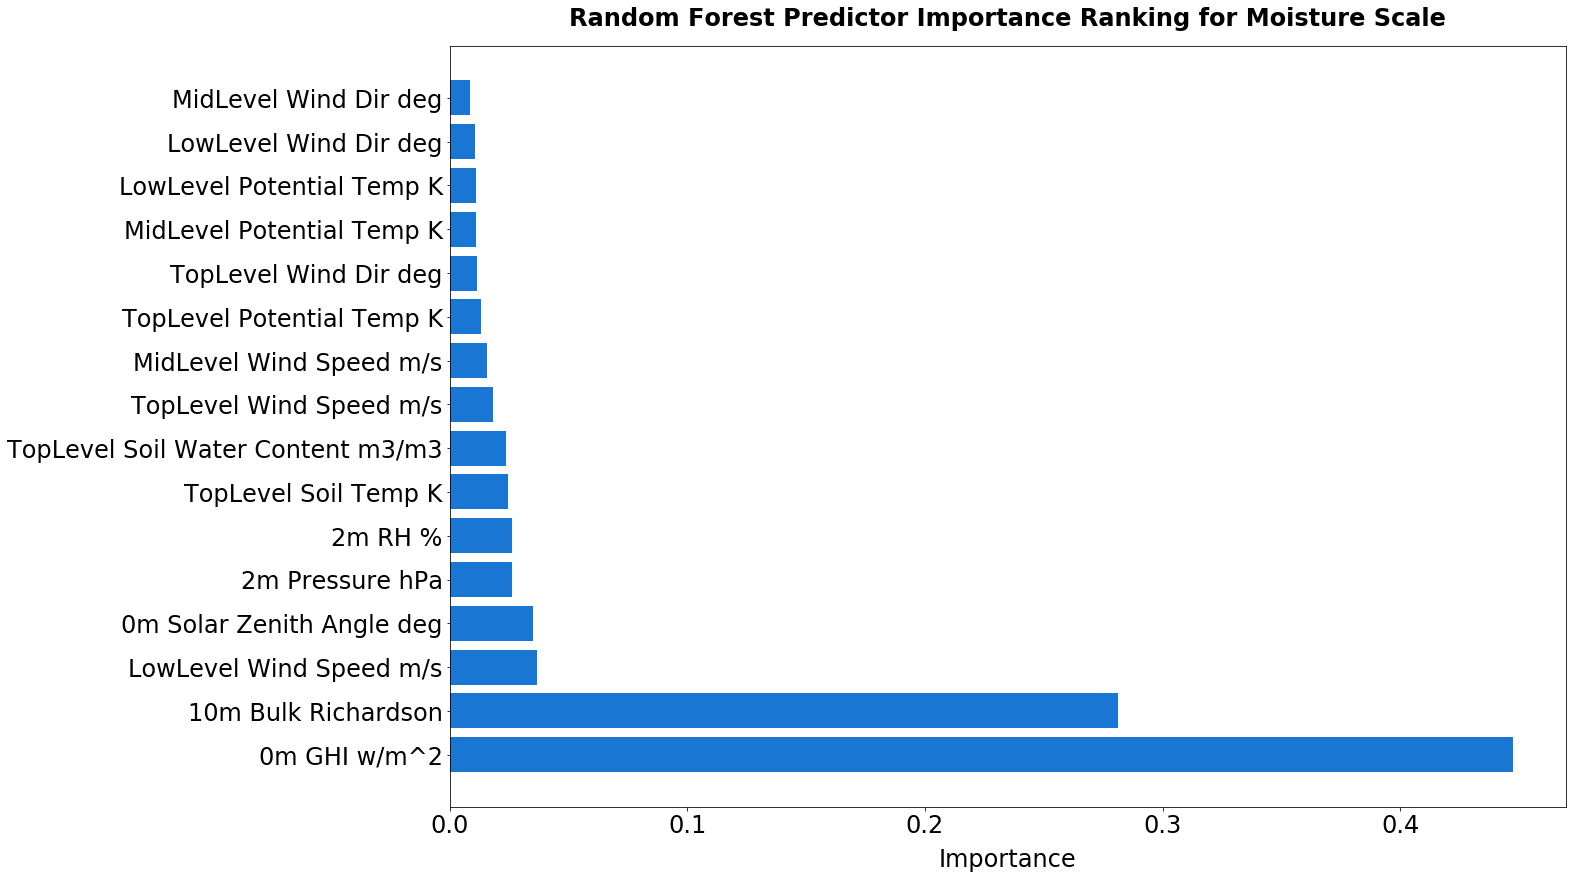

In [32]:
dset = pd.DataFrame()
tf_MC = train_featuresMC.iloc[:,0:16]
dset['attr'] = tf_MC.columns
dset['importance'] = rfMC.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importance Ranking for Moisture Scale', fontsize=24, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.xlabel('Importance', fontsize=24, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-MoistureScale-Cabauw.png')
plt.show()



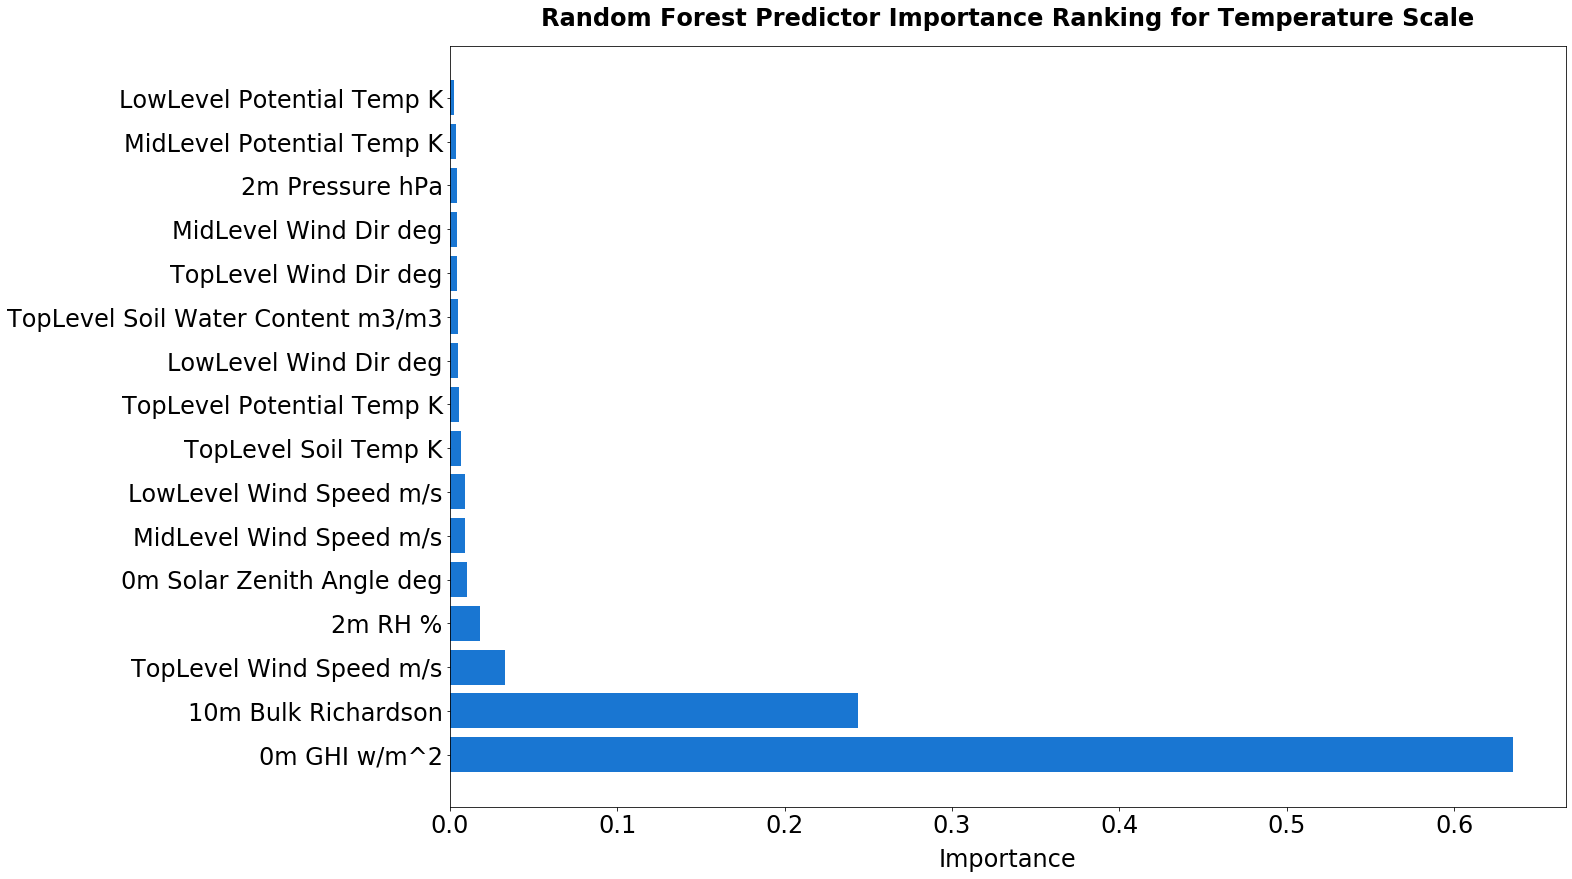

In [33]:
dset = pd.DataFrame()
tf_TC = train_featuresTC.iloc[:,0:16]
dset['attr'] = tf_TC.columns
dset['importance'] = rfTC.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importance Ranking for Temperature Scale', fontsize=24, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.xlabel('Importance', fontsize=24, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-TemperatureScale-Cabauw.png')
plt.show()

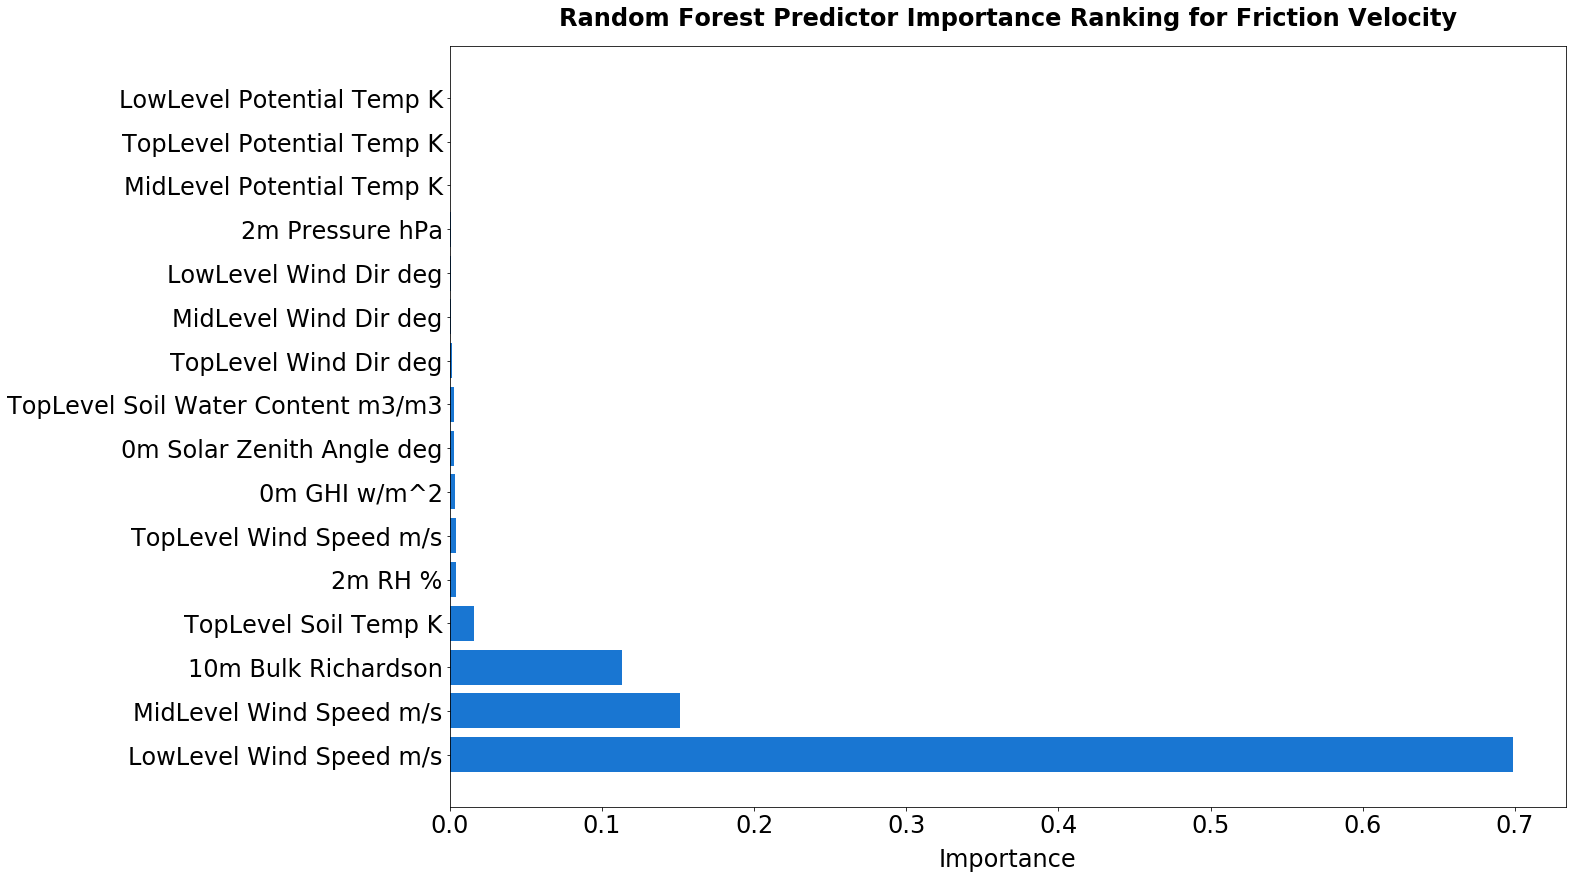

In [34]:
dset = pd.DataFrame()
tf_FC = train_featuresFC.iloc[:,0:16]
dset['attr'] = tf_FC.columns
dset['importance'] = rfFC.feature_importances_

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Random Forest Predictor Importance Ranking for Friction Velocity', fontsize=24, fontweight='bold', pad=20)
plt.rc('xtick', labelsize=24) 
plt.rc('ytick', labelsize=24) 
plt.xlabel('Importance', fontsize=24, labelpad=10)
#plt.ylabel('Predictor', fontsize=20, labelpad=10)
plt.savefig('RF-predictor-importance-FrictionVelocity-Cabauw.png')
plt.show()

## Neural Network Cabauw

In [35]:
## Update this to train ANN rather than RF for different regimes
import tensorflow as tf
from tensorflow import keras
def build_model(train_data):
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(train_data.shape[1],)),
        keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=0.0001)
    model.compile(loss='mae',
                 optimizer=optimizer,
                 metrics=['mae'])
    return model

# Train ANN on negative BRN predictions
EPOCHS = 30
batch_size=128
######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
ANN_MC = build_model(np.asarray(train_featuresMC.iloc[:,0:16]))
ANN_TC = build_model(np.asarray(train_featuresTC.iloc[:,0:16]))
ANN_FC = build_model(np.asarray(train_featuresFC.iloc[:,0:16]))
scaler_cabauw = StandardScaler()
train_features_cabauw_norm = scaler_cabauw.fit_transform(train_featuresMC.iloc[:,0:16])
# Train the model on training data
historyMC = ANN_MC.fit(train_features_cabauw_norm, train_labelsMC.values, epochs=EPOCHS, batch_size=batch_size, validation_split=0.2,verbose=1)
historyFC = ANN_FC.fit(train_features_cabauw_norm, train_labelsFC.values, epochs=EPOCHS, batch_size=batch_size, validation_split=0.2,verbose=1)
historyTC = ANN_TC.fit(train_features_cabauw_norm, train_labelsTC.values, epochs=EPOCHS, batch_size=batch_size, validation_split=0.2,verbose=1)
test_features_cabauw_norm = scaler_cabauw.transform(test_featuresMC.iloc[:,0:16])
# Use the forest's predict method on the test data
ANNpredictionsMC = ANN_MC.predict(test_features_cabauw_norm)
ANNpredictionsTC = ANN_TC.predict(test_features_cabauw_norm)
ANNpredictionsFC = ANN_FC.predict(test_features_cabauw_norm)

ANNpredictionsMC = ANNpredictionsMC.reshape(len(ANNpredictionsMC,))
ANNpredictionsTC = ANNpredictionsTC.reshape(len(ANNpredictionsTC,))
ANNpredictionsFC = ANNpredictionsFC.reshape(len(ANNpredictionsFC,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMC = abs(ANNpredictionsMC - test_labelsMC)
ANNerrorsTC = abs(ANNpredictionsTC - test_labelsTC)
ANNerrorsFC = abs(ANNpredictionsFC - test_labelsFC)
# Print out the mean absolute error (mae)
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMC), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTC), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFC), 4))

Train on 322512 samples, validate on 80628 samples
Epoch 1/30
322512/322512 [==============================] - 4s 14us/sample - loss: 0.0716 - mae: 0.0716 - val_loss: 0.0604 - val_mae: 0.0604
Epoch 2/30
322512/322512 [==============================] - 4s 12us/sample - loss: 0.0580 - mae: 0.0580 - val_loss: 0.0577 - val_mae: 0.0577
Epoch 3/30
322512/322512 [==============================] - 4s 12us/sample - loss: 0.0561 - mae: 0.0561 - val_loss: 0.0582 - val_mae: 0.0582
Epoch 4/30
322512/322512 [==============================] - 4s 13us/sample - loss: 0.0552 - mae: 0.0552 - val_loss: 0.0575 - val_mae: 0.0575
Epoch 5/30
322512/322512 [==============================] - 4s 12us/sample - loss: 0.0544 - mae: 0.0544 - val_loss: 0.0570 - val_mae: 0.0570
Epoch 6/30
322512/322512 [==============================] - 4s 13us/sample - loss: 0.0540 - mae: 0.0540 - val_loss: 0.0567 - val_mae: 0.0567
Epoch 7/30
322512/322512 [==============================] - 4s 13us/sample - loss: 0.0536 - mae: 0.0536

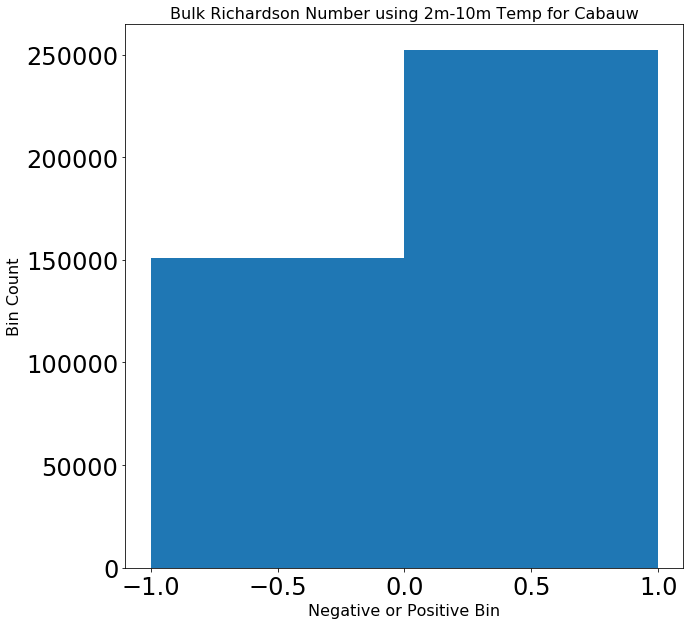

In [381]:
datasetC["BRN_sign"] = np.sign(datasetC['10m Bulk Richardson'])
plt.title('Bulk Richardson Number using 2m-10m Temp for Cabauw', size = 16)
plt.xlabel('Negative or Positive Bin', size = 16)
plt.ylabel('Bin Count', size = 16)
plt.hist(datasetC["BRN_sign"],bins=2)
plt.savefig('BRN_2-10m_Cabauw.png')

In [36]:
from math import log, atan, sqrt
import numpy as np
from numba import jit
@jit(nopython=True)
def mo_similarity(u10, v10, tsk, t2, qsfc, q2, psfc, mavail=1, z0=0.01, zt0=0.001, z10=10.0, z2=2.0):
    """
    Calculate flux information based on Monin-Obukhov similarity theory.

    Args:
        u10: 10 m level zonal wind speed [m/s]
        v10: 10 m level meridional wind speed [m/s]
        tsk: surface skin temperature [K]
        t2: 2 m level temperature [K]
        qsfc: ground mixing ratio [kg /kg]
        q2: 2 m level mixing ratio [kg / kg]
        psfc: surface pressure [hPa]
        z0: momentum roughness length
        zt0: heat flux roughness length
        z10: Height of "10 m" layer
        z2: Height of "2 m" layer

    Returns:
        ustar: friction velocity
        tstar: temperature scale
        wthv0: -ustar * tstar
        zeta10: z/L for a z of 10 m. Used for momentum flux
        phim10: momentum universal function at 10 m
        zeta2: z/L for a z of 2 m.
        phih2: sensible heat flux universal function at 2 m.
    """
    if z0 > 0:
        z10oz0 = z10 / z0
        z2oz0 = z2 / z0
        z2ozt0 = z2 / zt0
    else:
        raise ValueError("z0 must be greater than 0")
    # else:
    #    sys.exit("Surface roughnes, z0, must be greter than 0.!")
    #
    # Gravitational acceleration
    g = 9.81
    #
    # Gas constant over spcific heat capacity at constant pressure
    r = 287.058
    cp = 1005.
    rocp = r / cp
    #
    # Reference pressure and temperature
    p0 = 1000.
    t0 = 300.
    #
    # Set M-O parameters based on Dyer 1974 paper
    karman = 0.4
    beta = 5.0
    gamma = 16.0
    #
    # Air density
    rho = psfc / (r * t2)
    #
    # Potential temperature speed at level 1
    th2 = t2 * (p0 / psfc) ** rocp
    th0 = tsk * (p0 / psfc) ** rocp
    #
    # Virtual potential temperature
    thv2 = th2 * (1. + 0.61 * q2)
    thv0 = th0 * (1. + 0.61 * qsfc)
    #
    # Small number
    epsilon = 1.e-6
    #
    # Initial values of drag coefficients - neutrally stratified case
    cd = karman ** 2 / ((log(z10oz0)) ** 2)
    ch = karman ** 2 / ((log(z2ozt0)) ** 2)
    cq = karman ** 2 / ((log(z2oz0)) ** 2)
    #
    # Initial values of surface friction velocity, temperature scale, and
    # heat flux
    wind_speed = sqrt(u10 * u10 + v10 * v10)
    if wind_speed < 0.1:
        wind_speed = 0.1
        u10 = 0.1
    tauxz = cd * wind_speed * u10
    tauyz = cd * wind_speed * v10
    ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25

    tstar = -ch / ustar * wind_speed * (thv0 - thv2)
    qstar = cq / ustar * mavail * wind_speed * (qsfc - q2)
    wthv0 = -ustar * tstar
    #
    # Set stopping criterion
    diff = 1.
    #
    # Set stability functions
    psim10 = 0.
    psim2 = 0.
    psih2 = 0.
    psiq2 = 0.
    phim10 = 0.
    phih2 = 0
    #
    zeta10 = 0.
    zeta2 = 0.
    count = 0
    while diff > epsilon and count < 100:
        #
        # Surface friction velocity and temperature scale
        tauxz = cd * wind_speed * u10
        tauyz = cd * wind_speed * v10
        ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25
        if ustar < 0.01:
            ustar = 0.01
        wspd2 = ustar / karman * (log(z2oz0) - psim2)
        tstar = -ch / ustar * wspd2 * (thv0 - thv2)
        qstar = cq / ustar * mavail * wspd2 * (qsfc - q2)
        wthv0 = -ustar * tstar
        #
        # Compute drag coefficients
        cdold = cd
        chold = ch
        cqold = cq
        #
        # Neutrally stratified case
        if wthv0 == 0:
            zeta10 = 0.
            zeta2 = 0.
            psim10 = 0.
            psim2 = 0.
            psih2 = 0.
            psiq2 = 0.
            phim10 = 1.
            phih2 = 1.
            cd = karman ** 2 / ((log(z10oz0)) ** 2)
            ch = karman ** 2 / ((log(z2ozt0)) ** 2)
            cq = karman ** 2 / ((log(z2oz0)) ** 2)
        elif abs(wthv0) > 0:
            #
            # Obukhov length scale
            olength = -ustar ** 3 / (karman * g / t0 * wthv0)
            if abs(olength) < 10 and olength > 0:
                olength = z10
            elif abs(olength) < 10 and olength < 0:
                olength = -z10
            #
            # Free convection
            # if (olength == 0.):
            #    sys.exit("Free convection!")
            #
            # Monin-Obukhov stability parameter
            zeta10 = z10 / olength
            zeta2 = z2 / olength
            #
            # Convective case
            if (zeta2 < -epsilon) & (zeta10 >= -2.):
                xi10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                xi2 = 1. / ((1. - gamma * zeta2) ** 0.25)
                psim10 = log(0.5 * (1.0 + xi10 ** 2) * (0.5 * (1.0 + xi10)) ** 2) \
                    - 2. * atan(xi10) + 0.5 * np.pi
                psim2 = log(0.5 * (1.0 + xi2 ** 2) * (0.5 * (1.0 + xi2)) ** 2) \
                    - 2. * atan(xi2) + 0.5 * np.pi
                psih2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                psiq2 = 2.0 * log(0.5 * (1.0 + xi2 ** 2))
                phim10 = 1. / ((1. - gamma * zeta10) ** 0.25)
                phih2 = 1. / ((1. - gamma * zeta2) ** 0.25)
            #
            # Stably stratified case
            elif (zeta2 > epsilon) & (zeta2 <= 1.):
                psim10 = - beta * zeta10
                psim2 = - beta * zeta2
                psih2 = - beta * zeta2
                psiq2 = - beta * zeta2
                phim10 = (1. + beta * zeta10)
                phih2 = (1. + beta * zeta2)
            #
            # Neutrally stratified case
            elif (zeta2 <= epsilon) & (zeta2 >= -epsilon):
                psim10 = 0.
                psim2 = 0.
                psih2 = 0.
                psiq2 = 0.
                phim10 = 1.
                phih2 = 1.
            #
            cd = karman ** 2 / ((log(z10oz0) - psim10) ** 2)
            ch = karman ** 2 / ((log(z2ozt0) - psim2) * (log(z2ozt0) - psih2))
            cq = karman ** 2 / ((log(z2oz0) - psim2) * (log(z2oz0) - psiq2))
        #
        diff = abs(cd - cdold) + abs(ch - chold) + abs(cq - cqold)
        count += 1
    #
    return ustar, tstar, qstar, wthv0, zeta10, phim10, zeta2, phih2

In [37]:
from math import log, atan, sqrt
import numpy as np
from numba import jit
def mo_similarity_two_levels(u_low, v_low, u_high, v_high, t_low, t_high, pressure,
                             z_low, z_high, z_o=0.01):
    """
    Calculate flux information based on Monin-Obukhov similarity theory.

    Args:
        u10: 10 m level zonal wind speed [m/s]
        v10: 10 m level meridional wind speed [m/s]
        tsk: surface skin temperature [K]
        t2: 2 m level temperature [K]
        qsfc: ground mixing ratio [kg /kg]
        q2: 2 m level mixing ratio [kg / kg]
        psfc: surface pressure [hPa]
        z0: momentum roughness length
        zt0: heat flux roughness length
        z10: Height of "10 m" layer
        z2: Height of "2 m" layer

    Returns:
        ustar: friction velocity
        tstar: temperature scale
        wthv0: -ustar * tstar
        zeta10: z/L for a z of 10 m. Used for momentum flux
        phim10: momentum universal function at 10 m
        zeta2: z/L for a z of 2 m.
        phih2: sensible heat flux universal function at 2 m.
    """
    z_ratio = z_high / z_low
    z_zo = z_high / z_o
    # else:
    #    sys.exit("Surface roughnes, z0, must be greter than 0.!")
    #
    # Gravitational acceleration
    g = 9.81
    #
    # Gas constant over spcific heat capacity at constant pressure
    r = 287.058
    cp = 1005.
    rocp = r / cp
    #
    # Reference pressure and temperature
    p0 = 1000.
    t0 = 300.
    #
    # Set M-O parameters based on Dyer 1974 paper
    karman = 0.4
    beta = 5.0
    gamma = 16.0
    #
    # Air density
    rho = pressure / (r * t_high)
    #
    # Potential temperature speed at level 1
    th_high = t_high * (p0 / pressure) ** rocp
    th_low = t_low * (p0 / pressure) ** rocp
    #
    # Small number
    epsilon = 1.e-6
    #
    # Initial values of drag coefficients - neutrally stratified case
    cd = karman ** 2 / ((log(z_ratio)) ** 2)
    ch = karman ** 2 / ((log(z_ratio)) ** 2)
    #
    # Initial values of surface friction velocity, temperature scale, and
    # heat flux
    wind_speed_high = sqrt(u_high * u_high + v_high * v_high)
    wind_speed_low = sqrt(u_low * u_low + v_low * v_low)
    if wind_speed_high < 0.1:
        wind_speed_high = 0.1

    if wind_speed_low < 0.01:
        wind_speed_low = 0.01
    #tauxz = cd * (wind_speed_high) * (u_high)
    #tauyz = cd * (wind_speed_high) * (v_high)
    #ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25
    ustar = (cd * (wind_speed_high - wind_speed_low) ** 2) ** 0.5
    if ustar < 0.01:
        ustar = 0.01
    tstar = -ch / ustar * ((wind_speed_high - wind_speed_low) ** 2) ** 0.5 * (th_low - th_high)
    wthv0 = -ustar * tstar
    #
    # Set stopping criterion
    diff = 1.
    #
    # Set stability functions
    psi_m = 0.
    psi_m_low = 0.
    psi_h = 0.
    psi_h_low = 0.
    phi_m = 0.
    phi_h = 0.
    #
    zeta_high = 0.
    zeta_low = 0.
    count = 0
    while diff > epsilon and count < 100:
        #
        # Surface friction velocity and temperature scale
        #tauxz = cd * (wind_speed_high) * (u_high )
        #tauyz = cd * (wind_speed_high) * (v_high)
        #ustar = (tauxz ** 2 + tauyz ** 2) ** 0.25
        ustar = (cd * (wind_speed_high - wind_speed_low) ** 2) ** 0.5 
        if ustar < 0.01:
            ustar = 0.01
        tstar = -ch / ustar * ((wind_speed_high - wind_speed_low) ** 2) ** 0.5  * (th_low - th_high)
        wthv0 = -ustar * tstar
        #
        # Compute drag coefficients
        cdold = cd
        chold = ch
        #
        # Neutrally stratified case
        if wthv0 == 0:
            zeta_high = 0.
            zeta_low = 0.
            psi_m = 0.
            psi_m_low = 0.
            psi_h = 0.
            psi_h_low = 0.
            phi_m = 1.
            phi_h = 1.
            cd = karman ** 2 / ((log(z_ratio )) ** 2)
            ch = karman ** 2 / ((log(z_ratio)) ** 2)
        elif abs(wthv0) > 0:
            #
            # Obukhov length scale
            olength = -ustar ** 3 / (karman * g / th_high * wthv0)
            if abs(olength) < (z_high) and olength > 0:
                olength = z_high
            elif abs(olength) < z_high and olength < 0:
                olength = -(z_high)
            #
            # Free convection
            # if (olength == 0.):
            #    sys.exit("Free convection!")
            #
            # Monin-Obukhov stability parameter
            zeta_high = z_high / olength
            zeta_low = z_low / olength
            #
            # Convective case
            if (zeta_high >= -2.) & (zeta_high < -epsilon):
                xi_high = 1. / ((1. - gamma * zeta_high) ** 0.25)
                xi_low = 1. / ((1. - gamma * zeta_low) ** 0.25)

                psi_m = log(0.5 * (1.0 + xi_high ** 2) * (0.5 * (1.0 + xi_high)) ** 2) \
                    - 2. * atan(xi_high) + 0.5 * np.pi
                
                psi_m_low = log(0.5 * (1.0 + xi_low ** 2) * (0.5 * (1.0 + xi_low)) ** 2) \
                    - 2. * atan(xi_low) + 0.5 * np.pi
                psi_h = 2.0 * log(0.5 * (1.0 + xi_high ** 2))
                psi_h_low = 2.0 * log(0.5 * (1.0 + xi_low ** 2))

                phi_m = 1. / ((1. - gamma * zeta_high) ** 0.25)
                phi_h = 1. / ((1. - gamma * zeta_high) ** 0.25)
            #
            # Stably stratified case
            elif (zeta_high > epsilon) & (zeta_high <= 1.):
                psi_m = - beta * zeta_high
                psi_h = - beta * zeta_high
                psi_m_low = -beta * zeta_low
                psi_h_low = -beta * zeta_low
                phi_m = (1. + beta * zeta_high)
                phi_h = (1. + beta * zeta_high)
            #
            # Neutrally stratified case
            elif (zeta_high <= epsilon) & (zeta_high >= -epsilon):
                psi_m = 0.
                psi_h = 0.
                psi_m_low = 0.
                psi_h_low = 0.
                phi_m = 1.
                phi_h = 1.
            #
            cd = karman ** 2 / ((log(z_ratio) - psi_m + psi_m_low) ** 2)
            ch = karman ** 2 / ((log(z_ratio) - psi_m + psi_m_low) * (log(z_ratio) - psi_h + psi_h_low))
        #
        diff = abs(cd - cdold) + abs(ch - chold)
        count += 1
    #
    return ustar, tstar, wthv0, zeta_high, phi_m, phi_h

In [38]:
# Test the MO Similarity on the test dataset for the RF Predictions #
#--- Inputs
# Wind velocity at 10 m
u10 = datasetTest['10m U-Wind m/s']
v10 = datasetTest['10m V-Wind m/s']

# Skin temperature and temperature at 2 m
tsk = datasetTest['2m Temp K']
t2  = datasetTest['10m Temp K'] 



# Set variable to compute saturation mixing ratio at the surface.
# datasetTest['0m RH %'] = 100
#
# Ground mixing ratio and mixing ratio at 2 m
#qsfc, vap_pressure, sat_vap_pressure = mixing_ratio(datasetTest['2m Temp K']-273.15, 
#                    datasetTest['0m RH %'], datasetTest['2m Pressure hPa'])
q2, vap_pressure, sat_vap_pressure    = mixing_ratio(datasetTest['10m Temp K']-273.15, 
                    datasetTest['2m RH %'], datasetTest['2m Pressure hPa'])

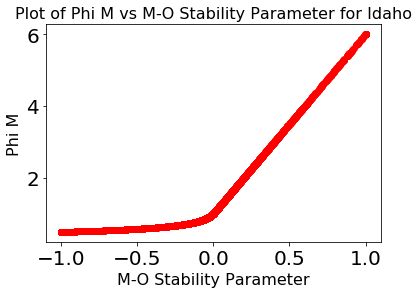

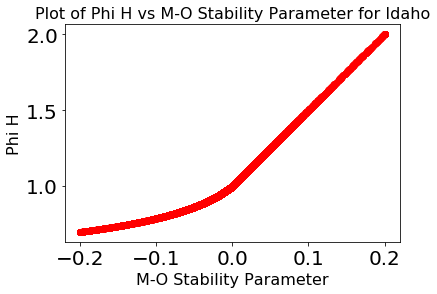

In [29]:
# Test the MO Similarity on the test dataset for the RF Predictions #
#--- Inputs
# Wind velocity at 10 m
u10 = datasetTest['10m U-Wind m/s']
v10 = datasetTest['10m V-Wind m/s']

# Skin temperature and temperature at 2 m
tsk = datasetTest['2m Temp K']
t2  = datasetTest['10m Temp K'] 



# Set variable to compute saturation mixing ratio at the surface.
# datasetTest['0m RH %'] = 100
#
# Ground mixing ratio and mixing ratio at 2 m
#qsfc, vap_pressure, sat_vap_pressure = mixing_ratio(datasetTest['2m Temp K']-273.15, 
#                    datasetTest['0m RH %'], datasetTest['2m Pressure hPa'])
q2, vap_pressure, sat_vap_pressure    = mixing_ratio(datasetTest['10m Temp K']-273.15, 
                    datasetTest['2m RH %'], datasetTest['2m Pressure hPa'])

def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

qsfc = saturation_mixing_ratio(datasetTest['2m Temp K'], datasetTest['2m Pressure hPa'])



qsfc = qsfc / 1000
q2 = q2 /1000
#
# Surface pressure 
psfc = datasetTest['2m Pressure hPa']

#
# Momentum roughness length, heat flux roughness and reference level
z0=0.01 # might want to go back to 0.1 
zt0=2
z10=10.0 
z2=2.0

# Outside the range of M-O Similarity Theory
phim=[]
zolm=[]
phih=[]
zolh=[]
t_2_out=[]
t_sk_out=[]
ustar_out=[]
tstar_out=[]
pred_ustar_out = []
pred_tstar_out = []
actual_ustar_out = []
actual_tstar_out = []
qstar_out = []

# Within the range of M-O Similarity Theory
phimO=[]
zolmO=[]
phihO=[]
zolhO=[]
t_2_in=[]
t_sk_in=[]
ustar_in=[]
tstar_in=[]
pred_ustar_in = []
pred_tstar_in = []
pred_qstar_in = []
actual_ustar_in = []
actual_tstar_in = []
actual_qstar_in = []
qstar_in = []

#ustar,tstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10,v10,tsk,t2,qsfc,q2,psfc,z0,zt0)
#
for i, val in enumerate(u10):
    ustar,tstar,qstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10.iloc[i],v10.iloc[i],tsk.iloc[i],t2.iloc[i],qsfc.iloc[i],q2.iloc[i],psfc.iloc[i],mavail=1, z0=0.01, zt0=0.001, z10=10.0, z2=2.0)
    if ((zeta10 < -2.) | (zeta10 > 1.)):
        phimO.append(phim10)
        zolmO.append(zeta10)
        phihO.append(phih2)
        zolhO.append(zeta2)
        t_2_out.append(t2.iloc[i])
        t_sk_out.append(tsk.iloc[i])
        ustar_out.append(ustar)
        tstar_out.append(tstar)
        qstar_out.append(qstar)
        pred_ustar_out.append(predictionsF[i])
        pred_tstar_out.append(predictionsT[i])
        pred_qstar_out.append(predictionsM[i])
        actual_ustar_out.append(test_labelsF.iloc[i])
        actual_tstar_out.append(test_labelsT.iloc[i])
        actual_qstar_out.append(test_labelsM.iloc[i])
        
    else:
        phim.append(phim10)
        zolm.append(zeta10)
        phih.append(phih2)
        zolh.append(zeta2)
        t_2_in.append(t2.iloc[i])
        t_sk_in.append(tsk.iloc[i])
        ustar_in.append(ustar)
        tstar_in.append(tstar)
        qstar_in.append(qstar)
        pred_ustar_in.append(predictionsF[i])
        pred_tstar_in.append(predictionsT[i])
        pred_qstar_in.append(predictionsM[i])
        actual_ustar_in.append(test_labelsF.iloc[i])
        actual_tstar_in.append(test_labelsT.iloc[i])
        actual_qstar_in.append(test_labelsM.iloc[i])
#
p=plt.plot(zolm,phim,'ro')
plt.title('Plot of Phi M vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi M', size = 16)
plt.show()
q=plt.plot(zolh,phih,'ro')
plt.title('Plot of Phi H vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi H', size = 16)
plt.show()


In [39]:
mo_2_idaho_test = pd.DataFrame(0, index=np.arange(resultTest.shape[0]), columns=["ustar", "tstar", "wthv0", "zeta", "phi_m", "phi_h"])
for i in range(mo_2_idaho_test.shape[0]):
    mo_2_idaho_test.loc[i] = mo_similarity_two_levels(resultTest.loc[i, "2m U-Wind m/s"], 
                                                      resultTest.loc[i, "2m V-Wind m/s"], 
                                                      resultTest.loc[i, "10m U-Wind m/s"],
                                                      resultTest.loc[i, "10m V-Wind m/s"],
                                                      resultTest.loc[i, "2m Temp K"],
                                                      resultTest.loc[i, "10m Temp K"],
                                                      resultTest.loc[i, 'Barometric Pressure hpa'],
                                                      2, 10, 0.05)

In [121]:
test_data.columns

Index(['global horizontal irradiance_0 m_W m-2', 'zenith_0 m_degrees',
       'azimuth_0 m_degrees', 'temperature_2 m_K', 'temperature_10 m_K',
       'temperature_20 m_K', 'temperature_40 m_K', 'pressure_2 m_hPa',
       'potential temperature_2 m_K', 'potential temperature_10 m_K',
       'potential temperature_20 m_K', 'potential temperature_40 m_K',
       'virtual potential temperature_2 m_K',
       'virtual potential temperature_10 m_K',
       'virtual potential temperature_20 m_K',
       'virtual potential temperature_40 m_K', 'mixing ratio_2 m_g kg-1',
       'mixing ratio_10 m_g kg-1', 'mixing ratio_20 m_g kg-1',
       'mixing ratio_40 m_g kg-1', 'relative humidity_2 m_%',
       'relative humidity_10 m_%', 'relative humidity_20 m_%',
       'relative humidity_40 m_%', 'temperature change_4 m_K m-1',
       'temperature change_15 m_K m-1', 'temperature change_30 m_K m-1',
       'mixing ratio change_4 m_g kg-1 m-1',
       'mixing ratio change_15 m_g kg-1 m-1',
       'mix

In [41]:
mo_2_cabauw_test = pd.DataFrame(0, index=test_data.index, columns=["ustar", "tstar", "wthv0", "zeta", "phi_m", "phi_h"])
for i in test_data.index:
    mo_2_cabauw_test.loc[i] = mo_similarity_two_levels(test_data.loc[i, 'u wind_10 m_m s-1'], 
                                                      test_data.loc[i, 'v wind_10 m_m s-1'], 
                                                      test_data.loc[i, 'u wind_20 m_m s-1'],
                                                      test_data.loc[i, 'v wind_20 m_m s-1'],
                                                      test_data.loc[i, 'temperature_10 m_K'],
                                                      test_data.loc[i, 'temperature_20 m_K'],
                                                      test_data.loc[i, 'pressure_2 m_hPa'],
                                                      10, 20, 0.05)

In [45]:
mae_mo_ustar_idaho = np.mean(np.abs(mo_2_idaho_test["ustar"] - resultTest['friction velocity']))
mae_mo_tstar_idaho = np.mean(np.abs(mo_2_idaho_test["tstar"] - resultTest['temperature scale']))
r2_mo_u_star_idaho = np.corrcoef(mo_2_idaho_test["ustar"], resultTest['friction velocity'])[0, 1] ** 2
r2_mo_t_star_idaho = np.corrcoef(mo_2_idaho_test["tstar"], resultTest['temperature scale'])[0, 1] ** 2

print("MAE ustar: ", mae_mo_ustar_idaho)
print("MAE tstar: ", mae_mo_tstar_idaho)
print("R2 ustar:", r2_mo_u_star_idaho)
print("R2 tstar:", r2_mo_t_star_idaho)

MAE ustar:  0.10650944334360034
MAE tstar:  0.17399313304002073
R2 ustar: 0.7234153898814426
R2 tstar: 0.3783889984837756


In [43]:
mae_mo_ustar_cabauw = np.mean(np.abs(mo_2_cabauw_test["ustar"] - test_data['friction velocity_surface_m s-1']))
mae_mo_tstar_cabauw= np.mean(np.abs(mo_2_cabauw_test["tstar"] - test_data['temperature scale_surface_K']))
r2_mo_u_star_cabauw = np.corrcoef(mo_2_cabauw_test["ustar"], test_data['friction velocity_surface_m s-1'])[0, 1] ** 2
r2_mo_t_star_cabauw = np.corrcoef(mo_2_cabauw_test["tstar"], test_data['temperature scale_surface_K'])[0, 1] ** 2

print("MAE ustar: ", mae_mo_ustar_cabauw)
print("MAE tstar: ", mae_mo_tstar_cabauw)
print("R2 ustar : ", r2_mo_u_star_cabauw)
print("R2 tstar : ", r2_mo_t_star_cabauw)

MAE ustar:  0.12991648343612555
MAE tstar:  0.06838237163737078
R2 ustar :  0.3452625583251097
R2 tstar :  0.2741656059335446


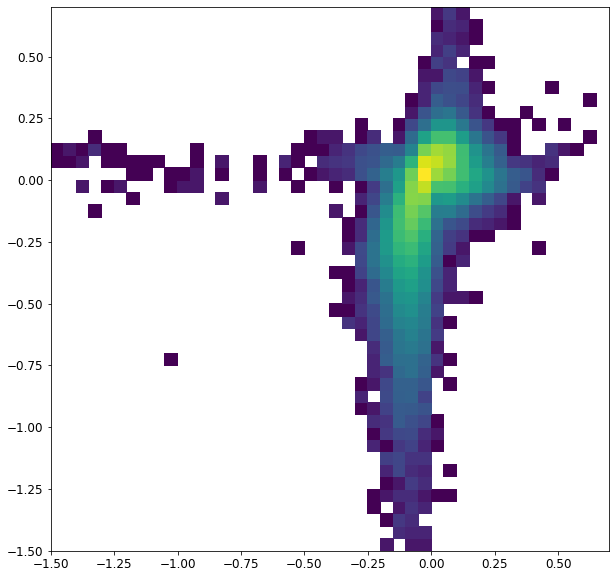

In [130]:
_ = plt.hist2d(mo_2_cabauw_test["tstar"], test_data['temperature scale_surface_K'],  
           (np.arange(-1.5, 0.75, 0.05), np.arange(-1.5, 0.75, 0.05)), cmin=1, norm=LogNorm())

(array([[5.8790e+03, 4.2110e+03, 3.7040e+03, ...,        nan,        nan,
                nan],
        [1.2254e+04, 8.8980e+03, 5.6800e+03, ...,        nan,        nan,
                nan],
        [7.5480e+03, 6.7110e+03, 5.1710e+03, ...,        nan,        nan,
                nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [1.0000e+01,        nan,        nan, ...,        nan,        nan,
                nan],
        [2.1000e+01,        nan,        nan, ...,        nan,        nan,
                nan]]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
        1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
        1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85,

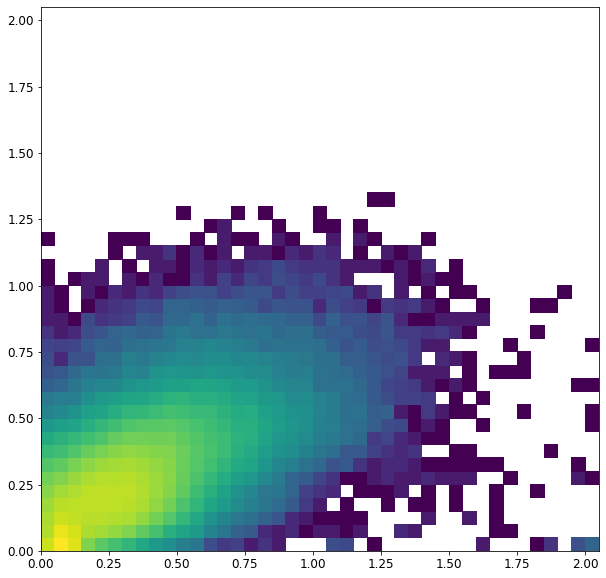

In [132]:
plt.hist2d(mo_2_cabauw_test["ustar"], test_data['friction velocity_surface_m s-1'],  
           (np.arange(0, 2.1, 0.05), np.arange(0,2.1, 0.05)), cmin=1, norm=LogNorm())

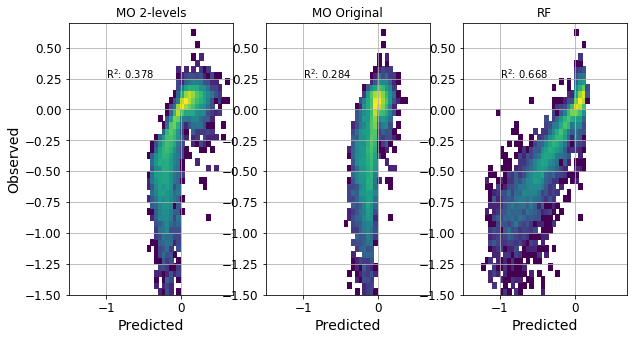

In [139]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
_ = plt.hist2d(mo_2_idaho_test["tstar"], resultTest['temperature scale'], (np.arange(-1.5, 0.75, 0.05), np.arange(-1.5, 0.75, 0.05)), cmin=1, norm=LogNorm())
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("Observed", fontsize=14)
plt.title("MO 2-levels")
mo_r2 = (np.corrcoef(mo_2_idaho_test["tstar"], resultTest['temperature scale'])[0, 1]) ** 2
plt.text(-1, 0.25, f"R$^2$: {mo_r2:0.3f}")
plt.grid()
plt.subplot(1, 3, 2)
_ = plt.hist2d(tstar_in, resultTest['temperature scale'], (np.arange(-1.5, 0.75, 0.05), np.arange(-1.5, 0.75, 0.05)), cmin=1, norm=LogNorm())
plt.grid()
mo_1_r2 = (np.corrcoef(tstar_in, resultTest['temperature scale'])[0, 1])** 2
plt.text(-1, 0.25, f"R$^2$: {mo_1_r2:0.3f}")
plt.xlabel("Predicted", fontsize=14)
plt.title("MO Original")
plt.subplot(1, 3, 3)
_ = plt.hist2d(predictionsT, resultTest['temperature scale'], (np.arange(-1.5, 0.75, 0.05), np.arange(-1.5, 0.75, 0.05)), cmin=1, norm=LogNorm())
plt.grid()
rf_r2 = (np.corrcoef(predictionsT, resultTest['temperature scale'])[0, 1])** 2
plt.text(-1, 0.25, f"R$^2$: {rf_r2:0.3f}")
plt.xlabel("Predicted", fontsize=14)
plt.title("RF")
plt.savefig("mo_old_new_comparison.png", dpi=200, bbox_inches="tight")

In [138]:
print(np.mean(np.abs(mo_2_idaho_test["tstar"] - resultTest['temperature scale'])))

0.17399313304002073


In [279]:
np.mean(np.abs(predictionsT- resultTest['temperature scale']))

0.07873717075839694

(735689.0, 735733.0)

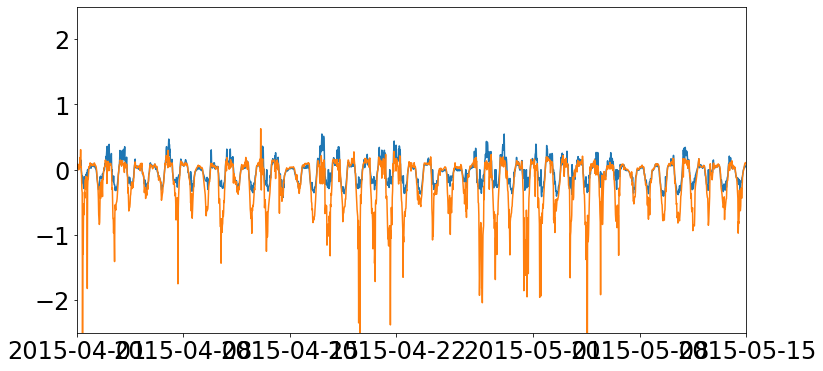

In [322]:
plt.figure(figsize=(12, 6))
plt.plot(resultTest["DateTime"], mo_2_idaho_test["tstar"])
plt.plot(resultTest["DateTime"], resultTest["temperature scale"])
#plt.plot(resultTest["DateTime"], tstar_in)
#plt.plot(resultTest["DateTime"], predictionsT)

plt.ylim(-2.5, 2.5)
plt.xlim("2015-04-01", "2015-05-15")

In [116]:
np.corrcoef(mo_2_idaho_test["tstar"], resultTest['temperature scale'])

array([[1.        , 0.53735728],
       [0.53735728, 1.        ]])

In [103]:
resultTest.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', '2m Wind Speed m/s',
       '2m Wind Gust m/s', '2m Wind Dir deg', '2m Sigma Theta deg',
       '10m Wind Speed m/s', '10m Wind Gust m/s', '10m Wind Dir deg',
       '10m Sigma Theta deg', '15m Wind Speed m/s', '15m Wind Gust m/s',
       '15m Wind Dir deg', '15m Sigma Theta deg', '45m Wind Speed m/s',
       '45m Wind Gust m/s', '45m Wind Dir deg', '45m Sigma Theta deg',
       'Top Wind Speed m/s', 'Top Wind Gust m/s', 'Top Wind Dir deg',
       'Top Sigma Theta deg', '2m Temp C', '10m Temp C', '15m Temp C',
       '45m Temp C', 'Top Temp C', '2m RH %', 'Solar Rad w/m^2',
       'BP inches Hg', 'Rain inches', '5cm Water Content',
       '10cm Water Content', '20cm Water Content', '50cm Water Content',
       '100cm Water Content', '5cm Soil Temp C', '10cm Soil Temp C',
       '20cm Soil Temp C', '50cm Soil Temp C', '100cm Soil Temp C', 'DateTime',
       'date', 'time', 'DOY', 'daytime', 'Tau', 'H', 'LE', 'co2_flux',
       'h2o_flux',

In [97]:
resultTest.loc[i, "2m U-Wind m/s"]

0.7992982640790868

(array([ 107.,  401.,  740., 1598., 2655., 2933., 1992.,  855.,  388.,
         101.]),
 array([836.30814 , 839.104976, 841.901812, 844.698648, 847.495484,
        850.29232 , 853.089156, 855.885992, 858.682828, 861.479664,
        864.2765  ]),
 <a list of 10 Patch objects>)

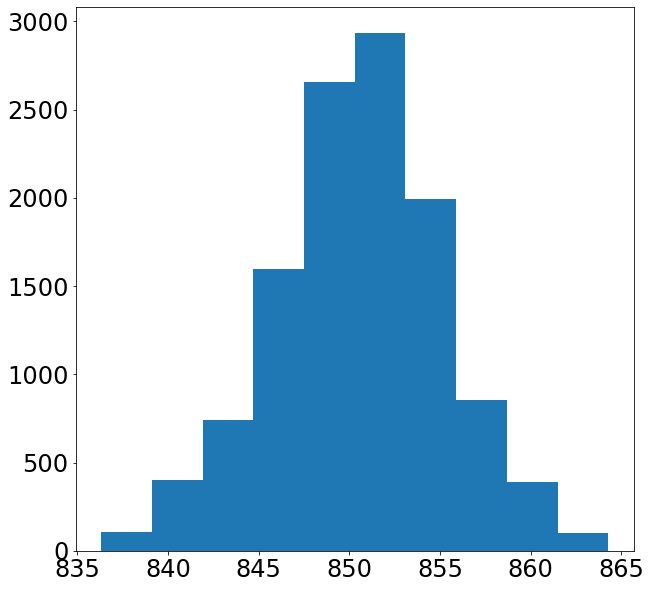

In [384]:
plt.hist(datasetTest['2m Pressure hPa'])

(array([  290.,   652.,  2824., 11165., 27756., 65041., 77227., 46351.,
        17120.,  3379.]),
 array([ 971.4 ,  978.52,  985.64,  992.76,  999.88, 1007.  , 1014.12,
        1021.24, 1028.36, 1035.48, 1042.6 ]),
 <a list of 10 Patch objects>)

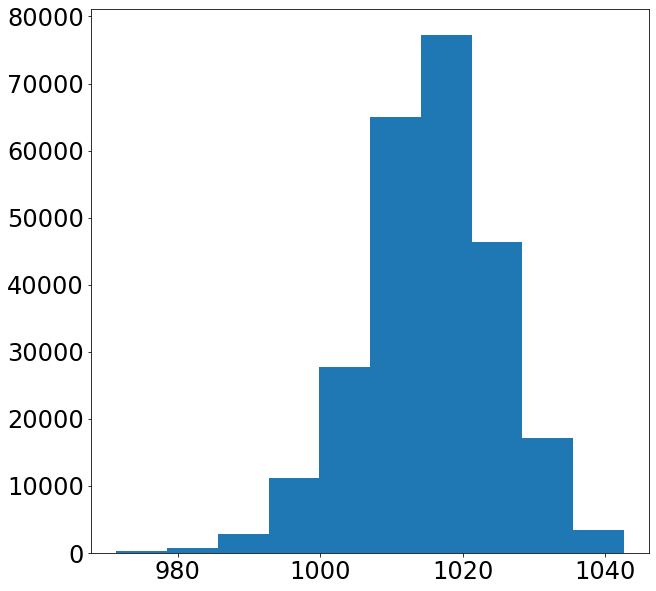

In [385]:
plt.hist(datasetTestC['2m Pressure hPa'])

(array([3026., 3530., 2340., 1104.,  711.,  579.,  239.,  146.,   79.,
          16.]),
 array([0.00052942, 0.00601915, 0.01150888, 0.01699861, 0.02248834,
        0.02797806, 0.03346779, 0.03895752, 0.04444725, 0.04993698,
        0.05542671]),
 <a list of 10 Patch objects>)

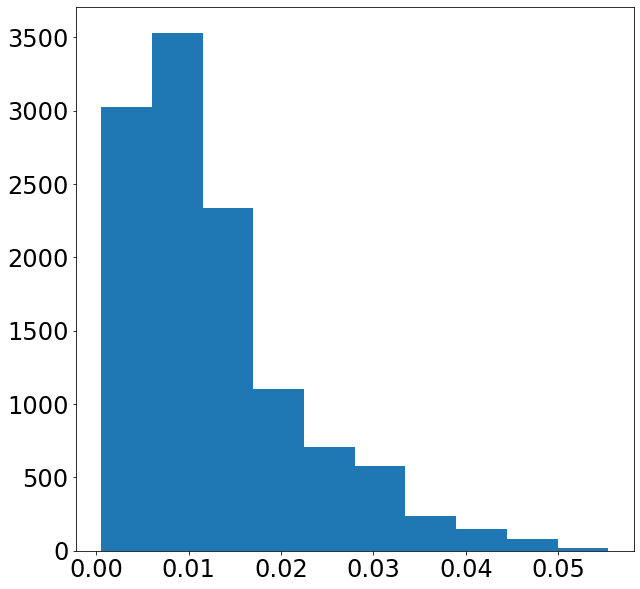

In [386]:
plt.hist(qsfc)

(array([1.004e+03, 3.974e+03, 3.351e+03, 1.648e+03, 1.101e+03, 5.050e+02,
        1.330e+02, 4.000e+01, 1.300e+01, 1.000e+00]),
 array([0.00033918, 0.00197979, 0.00362041, 0.00526102, 0.00690163,
        0.00854225, 0.01018286, 0.01182347, 0.01346409, 0.0151047 ,
        0.01674531]),
 <a list of 10 Patch objects>)

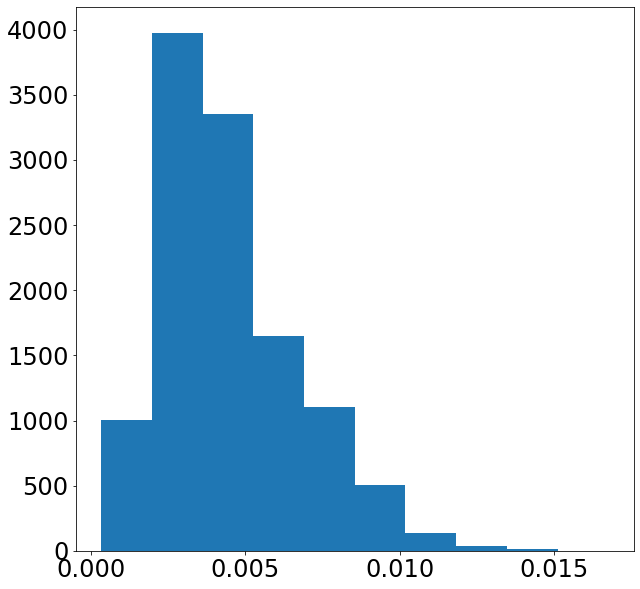

In [387]:
plt.hist(q2)

(array([2124., 3215., 2603., 1504.,  906.,  739.,  351.,  192.,  109.,
          27.]),
 array([ 0.79779942,  6.88092313, 12.96404684, 19.04717056, 25.13029427,
        31.21341798, 37.29654169, 43.37966541, 49.46278912, 55.54591283,
        61.62903654]),
 <a list of 10 Patch objects>)

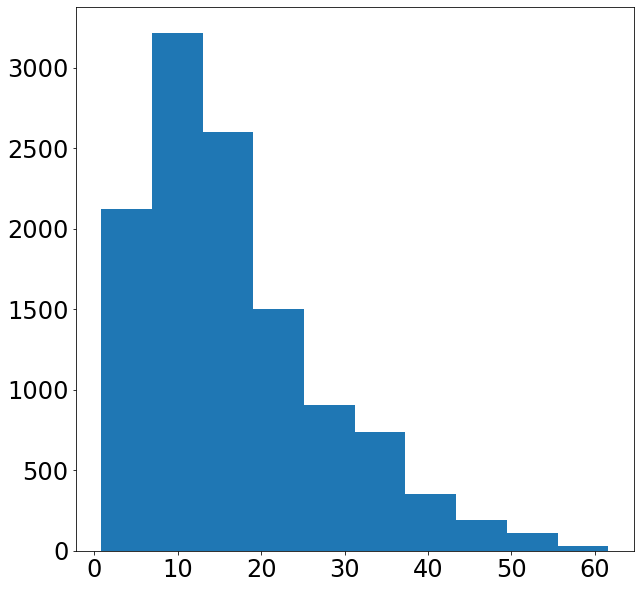

In [388]:
plt.hist(sat_vap_pressure)

(array([2731., 3446., 2438., 1210.,  742.,  642.,  290.,  156.,   96.,
          19.]),
 array([ 0.72596887,  7.61291377, 14.49985866, 21.38680356, 28.27374845,
        35.16069335, 42.04763824, 48.93458314, 55.82152803, 62.70847293,
        69.59541782]),
 <a list of 10 Patch objects>)

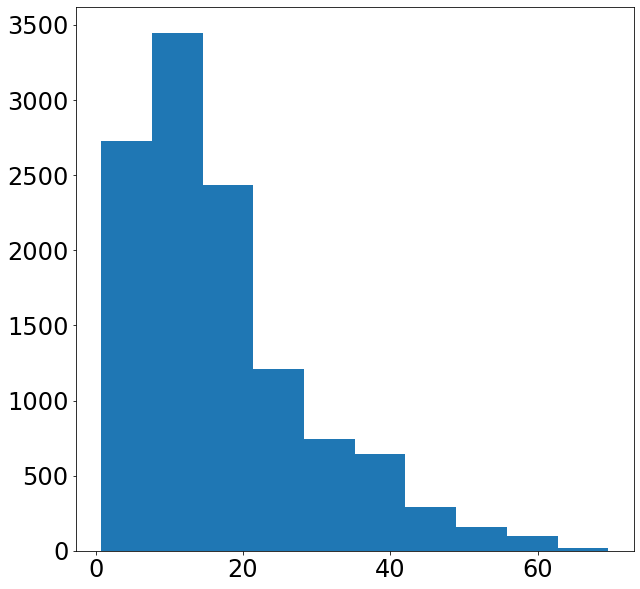

In [389]:

def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

sfc_sat_vap_pres = saturation_vapor_pressure(datasetTest['2m Temp K'])
plt.hist(sfc_sat_vap_pres)

The R^2 value is... 0.7936402736996997


/Users/dgagne/miniconda3/envs/tf2/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


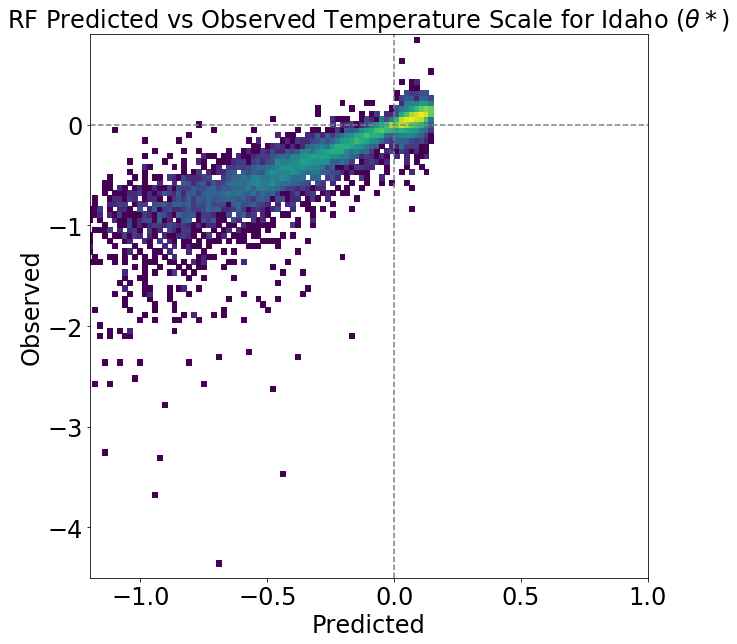

In [46]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsT
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
plt.ylim(-4.5, 0.9)
plt.xlim(-1.2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
#plt.text(-1,-3,"$R^2$: {0:0.2f}".format(r2),fontsize=16)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Observed_tscale_idaho.png')
plt.show()

The R^2 value is... 0.7941814463750047


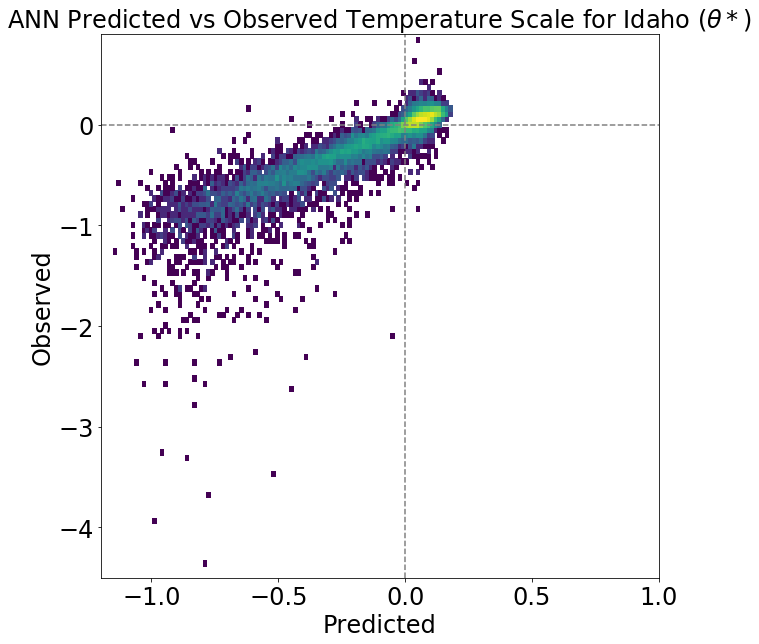

In [47]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsT
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
plt.ylim(-4.5, 0.9)
plt.xlim(-1.2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
#plt.text(-1,-3,"$R^2$: {0:0.2f}".format(r2),fontsize=16)
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Observed_tscale_idaho.png')
plt.show()

In [48]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats

plt.rcParams['figure.figsize'] = [10, 10]
y = np.array(actual_tstar_in)
x = np.array(mo_2_idaho_test["tstar"]) 
#x = x[y>-5] # Filter out a bad data point
#y = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
plt.ylim(-4.5, 0.9)
plt.xlim(-4.5, 0.9)
#plt.xlim(-1.2,1)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
#plt.text(-1,-3,"$R^2$: {0:0.2f}".format(r2),fontsize=16)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_tscale_idaho.png')
plt.show()

print("MAE for MO Similarity on T-Scale...")
errorsMO_TI_C = abs(x - y)
print(np.mean(errorsMO_TI_C))

NameError: name 'actual_tstar_in' is not defined

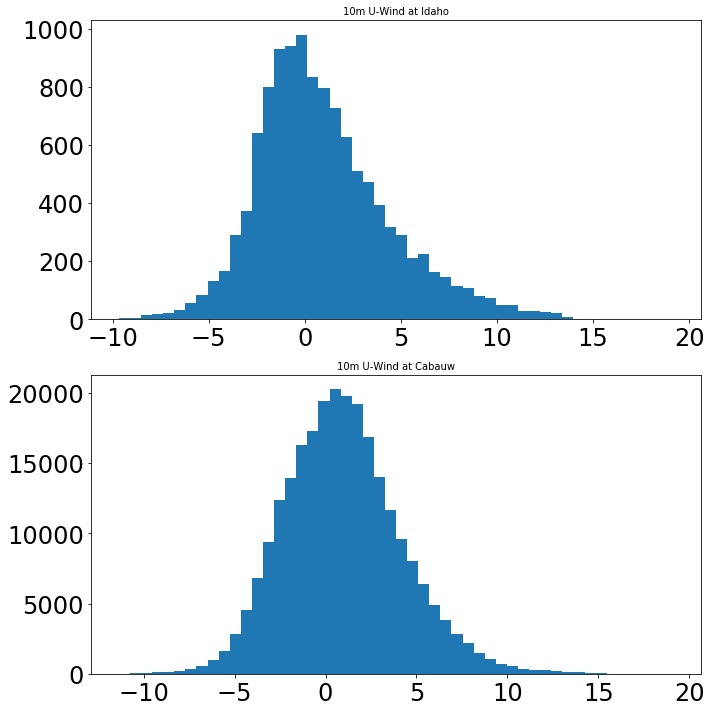

In [393]:
plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(datasetTest['10m U-Wind m/s'],bins=50)
        ax.set_title('10m U-Wind at Idaho', size = 10)
    elif i == 2:
        ax.hist(datasetTestC['10m U-Wind m/s'],bins=50)
        ax.set_title('10m U-Wind at Cabauw', size = 10)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

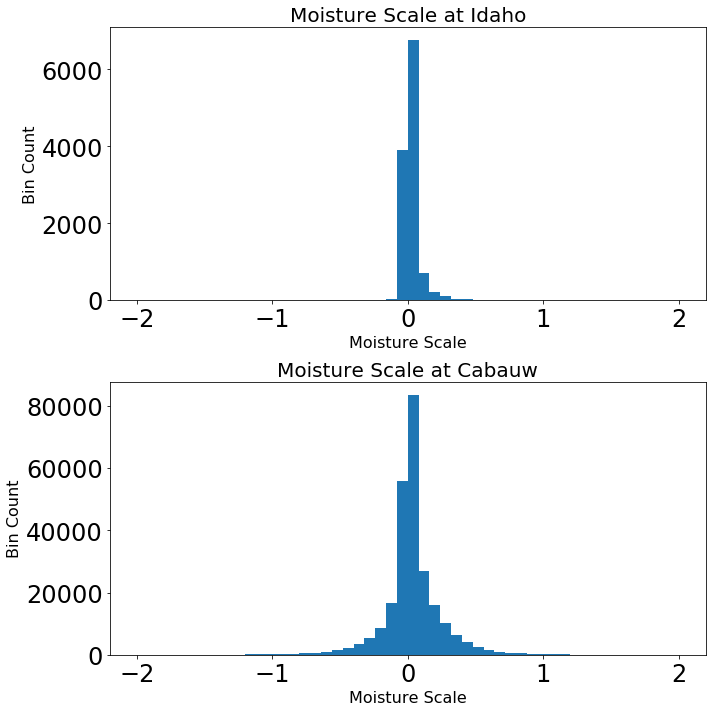

In [394]:
#MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
#TemperatureScaleTestC = test_data['temperature scale_surface_K']
#FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(MoistureScaleTest,range =(-2, 2),bins=50)
        ax.set_title('Moisture Scale at Idaho', size = 20)
        ax.set_xlabel('Moisture Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    elif i == 2:
        ax.hist(MoistureScaleTestC,range =(-2, 2),bins=50)
        ax.set_title('Moisture Scale at Cabauw', size = 20)
        ax.set_xlabel('Moisture Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

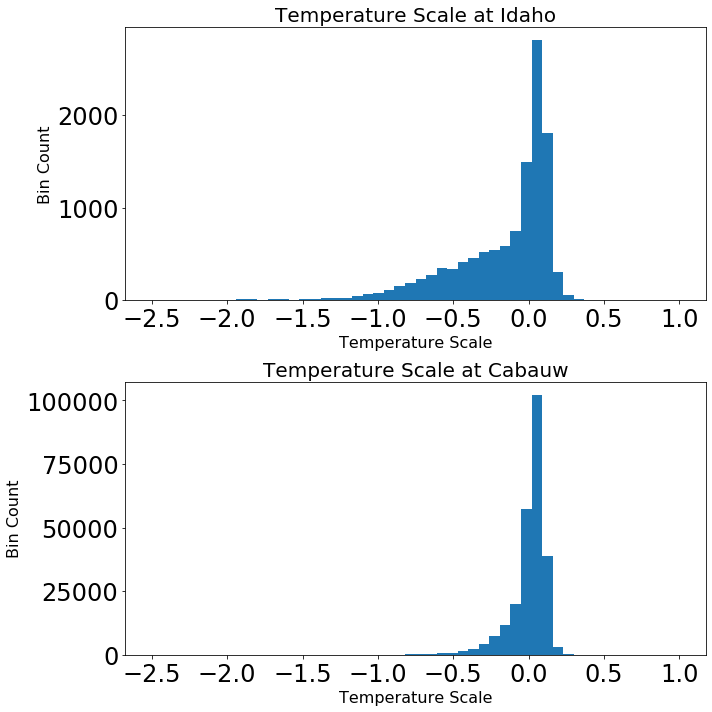

In [395]:
#MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
#TemperatureScaleTestC = test_data['temperature scale_surface_K']
#FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(TemperatureScaleTest,range =(-2.5, 1),bins=50)
        ax.set_title('Temperature Scale at Idaho', size = 20)
        ax.set_xlabel('Temperature Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    elif i == 2:
        ax.hist(TemperatureScaleTestC,range =(-2.5, 1),bins=50)
        ax.set_title('Temperature Scale at Cabauw', size = 20)
        ax.set_xlabel('Temperature Scale', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

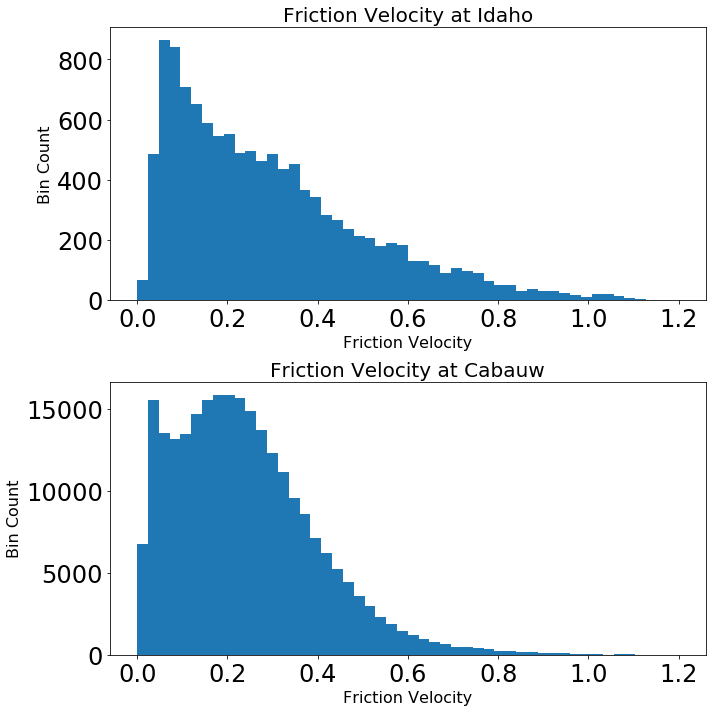

In [396]:
#MoistureScaleTestC = test_data['moisture scale_surface_g kg-1']
#TemperatureScaleTestC = test_data['temperature scale_surface_K']
#FrictionVelocityTestC = test_data['friction velocity_surface_m s-1']

plt.rcParams['figure.figsize'] = [10, 10]
for i in range(1,3):
    
    # Set up the plot
    ax = plt.subplot(2, 1, i)
    
    # Draw the plot
    if i == 1:
        ax.hist(FrictionVelocityTest,range =(0, 1.2),bins=50)
        ax.set_title('Friction Velocity at Idaho', size = 20)
        ax.set_xlabel('Friction Velocity', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
        
    elif i == 2:
        ax.hist(FrictionVelocityTestC,range =(0, 1.2),bins=50)
        ax.set_title('Friction Velocity at Cabauw', size = 20)
        ax.set_xlabel('Friction Velocity', size = 16)
        ax.set_ylabel('Bin Count', size = 16)
    
    # Title and labels
#    ax.set_title('Histogram with Binwidth = %d' % binwidth, size = 30)
#    ax.set_xlabel('Delay (min)', size = 22)
#    ax.set_ylabel('Flights', size= 22)

plt.tight_layout()
plt.show()

In [82]:
def plot_error_histograms(random_forest_preds, ann_preds, mo_preds, truth, value_range, num_bins, output_name, site, out_file,
                          tick_spacing=0.5):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    plt.rc('xtick', labelsize=12) 
    plt.rc('ytick', labelsize=12) 
    bins = np.linspace(value_range[0], value_range[1], num_bins)
    ticks = np.arange(value_range[0], value_range[1] + tick_spacing, tick_spacing)
    models = ["Random Forest", "Neural Network", "M-O Similarity"]
    preds = [random_forest_preds, ann_preds, mo_preds]
    for a, ax in enumerate(axes):
        ax.hist2d(preds[a], truth, (bins, bins), cmin=1, norm=LogNorm())
        if a == 0:
            ax.set_ylabel("Observed " + output_name, fontsize=14)
        ax.set_xlabel(models[a], fontsize=14)
        ax.axhline(0,color='gray',linestyle = '--') # x = 0
        ax.axvline(0,color='gray',linestyle = '--')
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)

    fig.suptitle(output_name + " Errors for " + site, fontsize=16)
    plt.savefig(out_file, dpi=300, bbox_inches="tight")

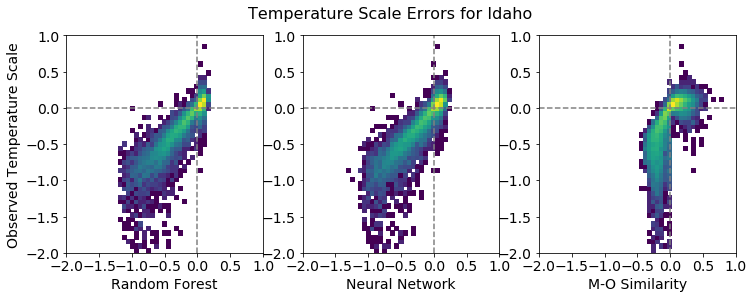

In [83]:
plot_error_histograms(predictionsT, ANNpredictionsT, mo_2_idaho_test["tstar"], actual_tstar_in, (-2, 1), 50, "Temperature Scale", 
                      "Idaho", "error_hist_tstar_idaho.png")

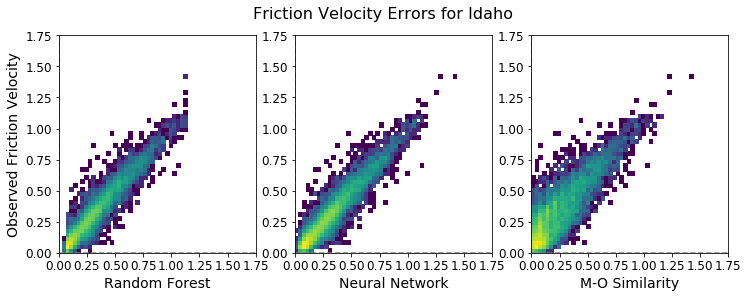

In [85]:
plot_error_histograms(predictionsF, ANNpredictionsF, mo_2_idaho_test["ustar"], actual_ustar_in, (0, 1.6), 50, "Friction Velocity", 
                      "Idaho", "error_hist_ustar_idaho.png", 0.25)

In [65]:
mo_2_idaho_test["qstar"] = np.nan

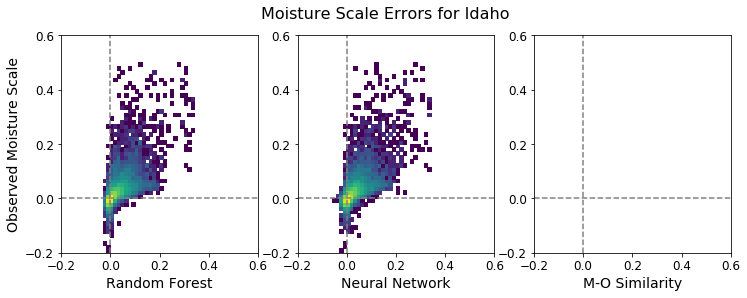

In [87]:
plot_error_histograms(predictionsM, ANNpredictionsM, mo_2_idaho_test["qstar"], actual_qstar_in, (-0.2, 0.5), 50, "Moisture Scale", 
                      "Idaho", "error_hist_qstar_idaho.png", 0.2)

The R^2 value is... 0.4109915839064089


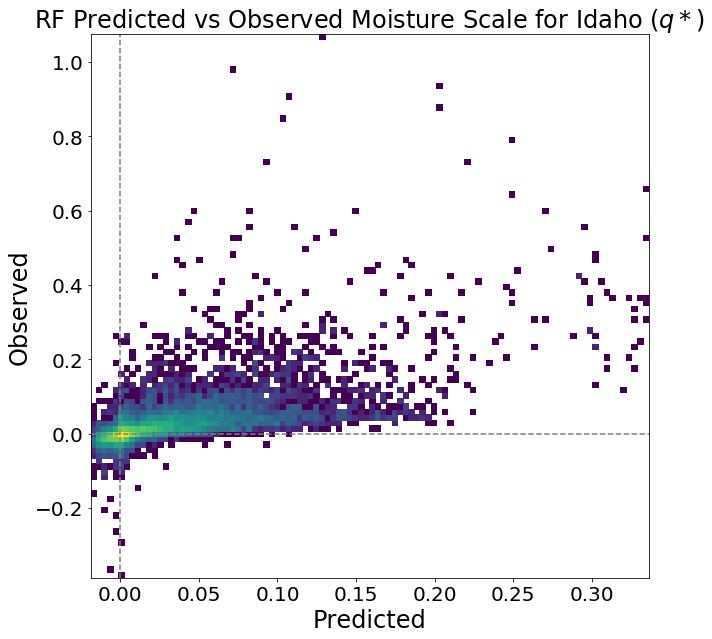

In [40]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsM
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.439895935541928


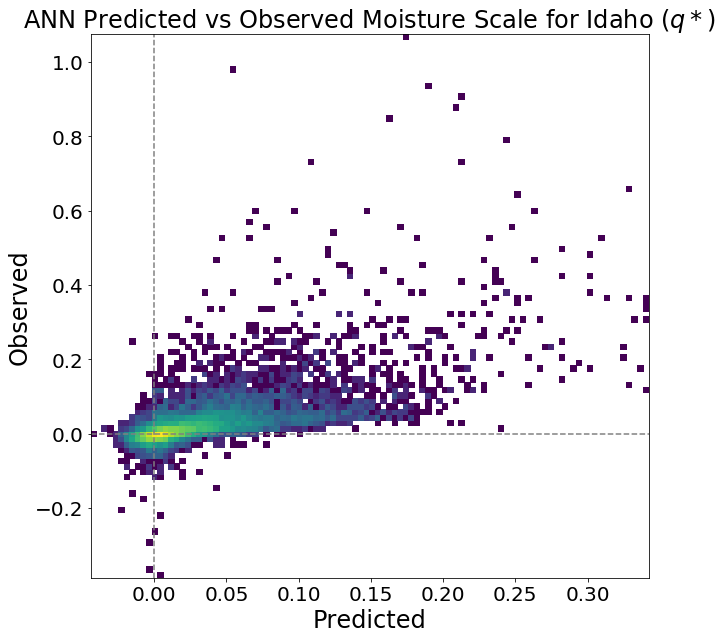

In [41]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsM
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.01093791432240012


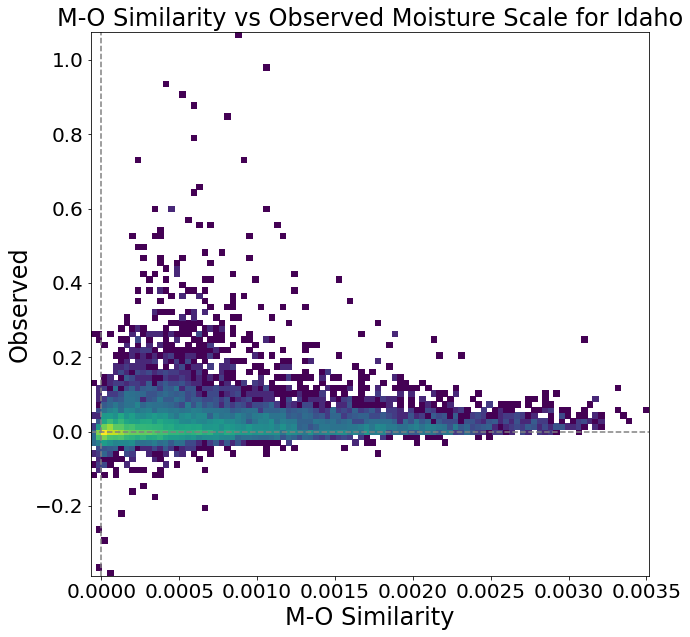

MAE for MO Similarity on Moisture Scale...
0.032242921057041386


In [42]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]

x = np.array(qstar_in)
y = np.array(actual_qstar_in) 

y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Moisture Scale for Idaho', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_mscale_idaho.png')
plt.show()

print("MAE for MO Similarity on Moisture Scale...")
errorsMO_FVI_C = abs(x - y)
print(np.mean(errorsMO_FVI_C))

The R^2 value is... 0.9082015158013524


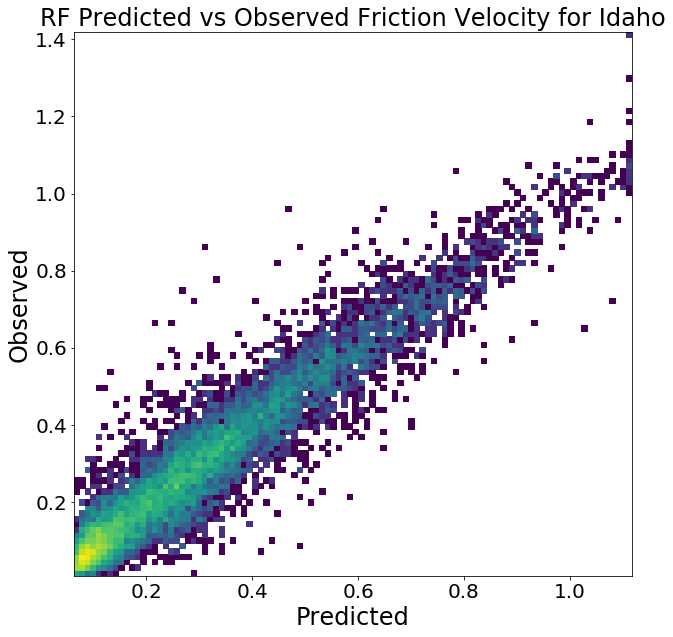

In [43]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsF
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_friction-velocity_idaho.png')
plt.show()

The R^2 value is... 0.8980186474849127


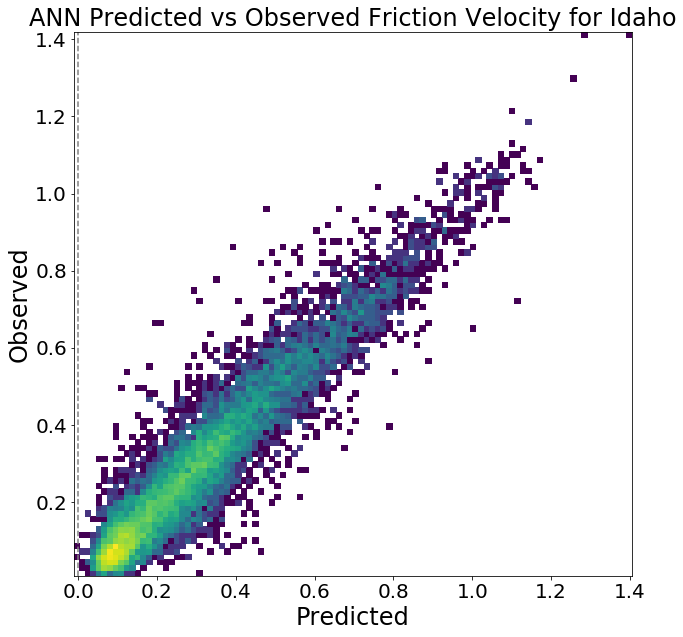

In [44]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsF
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_friction-velocity_idaho.png')
plt.show()

The R^2 value is... 0.835266746801673


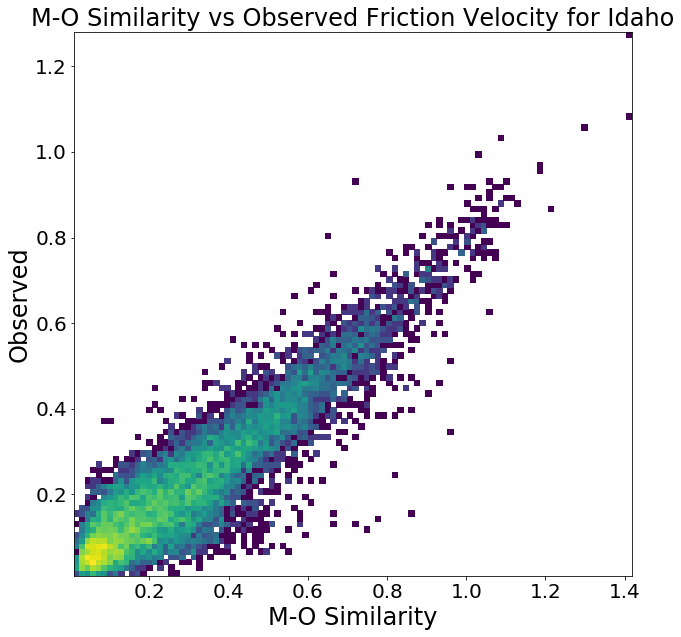

MAE for MO Similarity on Friction Velocity...
0.0905073390109177


In [45]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = np.array(actual_ustar_in)
y = np.array(ustar_in) 
y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_friction-velocity_idaho.png')
plt.show()

print("MAE for MO Similarity on Friction Velocity...")
errorsMO_FVI_C = abs(x - y)
print(np.mean(errorsMO_FVI_C))

(array([5051., 2869., 1466.,  851.,  604.,  465.,  239.,  123.,   84.,
          18.]),
 array([-0.00107968,  0.00403003,  0.00913973,  0.01424944,  0.01935915,
         0.02446885,  0.02957856,  0.03468827,  0.03979797,  0.04490768,
         0.05001739]),
 <a list of 10 Patch objects>)

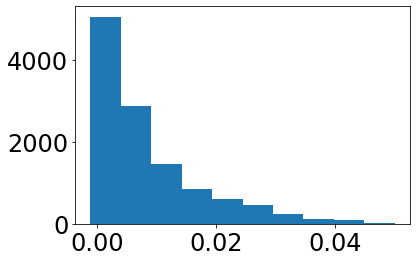

In [48]:
plt.hist(qsfc - q2)

In [ ]:
plt.hist()

0.00021597954019539272 22.204547960002962


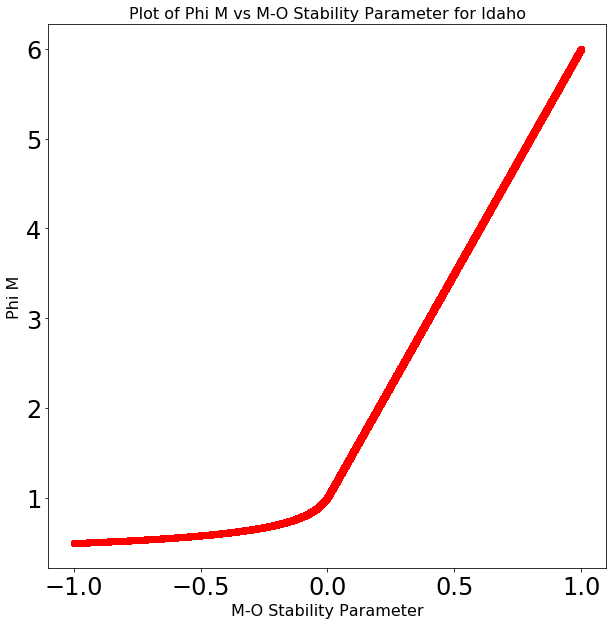

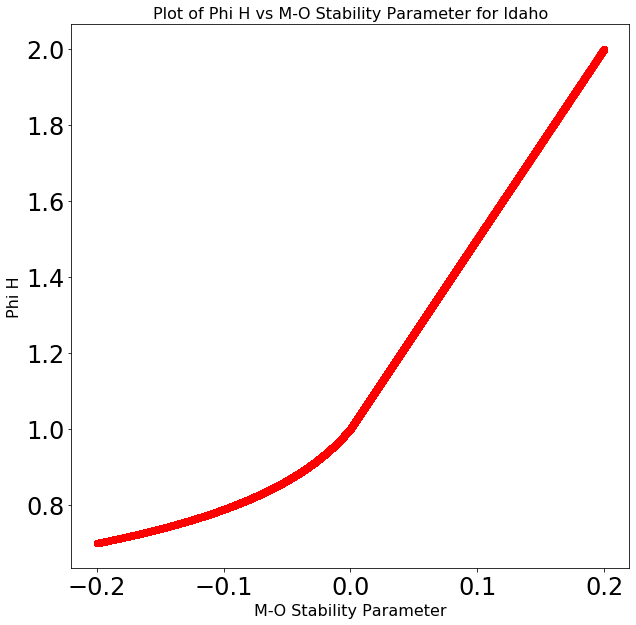

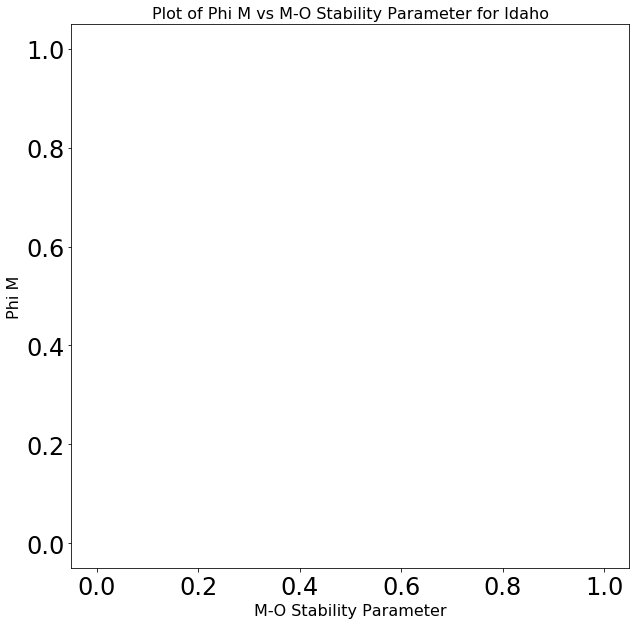

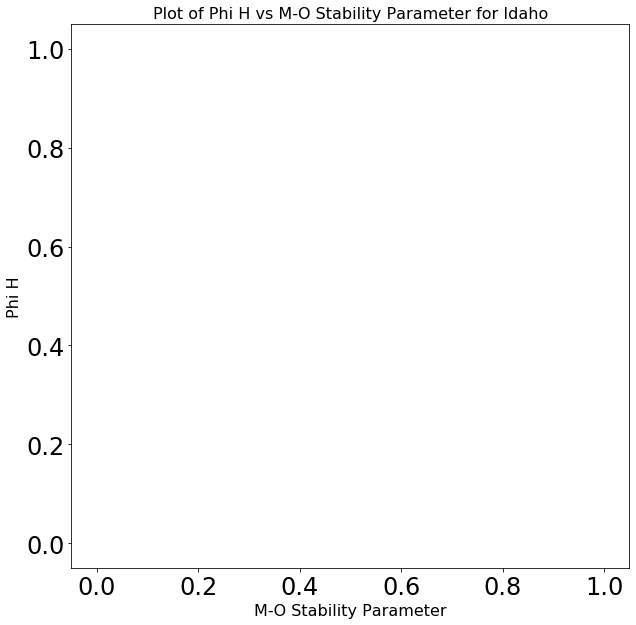

In [61]:
# Test the MO Similarity on the test dataset for the RF Predictions #
#--- Inputs
# Wind velocity at 10 m
u10 = datasetTestC['10m U-Wind m/s']
v10 = datasetTestC['10m V-Wind m/s']

# Skin temperature and temperature at 2 m
tsk = datasetTestC['2m Temp K']
t2  = datasetTestC['10m Temp K'] 
#
# Ground mixing ratio and mixing ratio at 2 m
#qsfc, vap_pressure, sat_vap_pressure = mixing_ratio(datasetTestC['2m Temp K']-273.15, 
#                    datasetTestC['2m RH %'], datasetTestC['2m Pressure hPa'])
q2, vap_pressure, sat_vap_pressure    = mixing_ratio(datasetTestC['10m Temp K']-273.15, 
                    datasetTestC['2m RH %'], datasetTestC['2m Pressure hPa'])
print(q2.min(), q2.max())
def saturation_vapor_pressure(temperature_K):
    """
    Calculate saturation vapor pressure from Clausius-Clapeyron equation in A First Course in
    Atmospheric Thermodynamics by Grant W. Petty
    Args:
        temperature_K: Temperature in Kelvin
    Returns:
        saturation vapor pressure in hPa/q2//q2
    """
    Rv = 461.0
    T0 = 273.0
    es0 = 6.11
    L = 2.5e6
    return es0 * np.exp(L / Rv * (1 / T0 - 1 / temperature_K))

qsfc = saturation_mixing_ratio(datasetTestC['2m Temp K'], datasetTestC['2m Pressure hPa'])

qsfc = qsfc / 1000
q2 = q2 /1000
#
# Surface pressure 
psfc = datasetTestC['2m Pressure hPa']
#
# Momentum roughness length, heat flux roughness and reference level
z0=0.01 # might want to go back to 0.1 
zt0=0.001 
z10=10.0 
z2=2.0

# Outside the range of M-O Similarity Theory
phim=[]
zolm=[]
phih=[]
zolh=[]
t_2_out=[]
t_sk_out=[]
ustar_out=[]
tstar_out=[]
pred_ustar_out = []
pred_tstar_out = []
actual_ustar_out = []
actual_tstar_out = []
qstar_out = []

# Within the range of M-O Similarity Theory
phimO=[]
zolmO=[]
phihO=[]
zolhO=[]
t_2_in=[]
t_sk_in=[]
ustar_in=[]
tstar_in=[]
pred_ustar_in = []
pred_tstar_in = []
pred_qstar_in = []
actual_ustar_in = []
actual_tstar_in = []
actual_qstar_in = []
qstar_in = []

#ustar,tstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10,v10,tsk,t2,qsfc,q2,psfc,z0,zt0)
#
for i, val in enumerate(u10):
    ustar,tstar,qstar,wthv0,zeta10,phim10,zeta2,phih2 = mo_similarity(u10.iloc[i],v10.iloc[i],tsk.iloc[i],t2.iloc[i],qsfc.iloc[i],q2.iloc[i],psfc.iloc[i],mavail=1, z0=0.01, zt0=0.001, z10=10.0, z2=2.0)
    if ((zeta10 < -2.) | (zeta10 > 1.)):
        phimO.append(phim10)
        zolmO.append(zeta10)
        phihO.append(phih2)
        zolhO.append(zeta2)
        t_2_out.append(t2.iloc[i])
        t_sk_out.append(tsk.iloc[i])
        ustar_out.append(ustar)
        tstar_out.append(tstar)
        qstar_out.append(qstar)
        pred_ustar_out.append(predictionsFC[i])
        pred_tstar_out.append(predictionsTC[i])
        pred_qstar_out.append(predictionsMC[i])
        actual_ustar_out.append(test_labelsFC.iloc[i])
        actual_tstar_out.append(test_labelsTC.iloc[i])
        actual_qstar_out.append(test_labelsMC.iloc[i])
        
    else:
        phim.append(phim10)
        zolm.append(zeta10)
        phih.append(phih2)
        zolh.append(zeta2)
        t_2_in.append(t2.iloc[i])
        t_sk_in.append(tsk.iloc[i])
        ustar_in.append(ustar)
        tstar_in.append(tstar)
        qstar_in.append(qstar)
        pred_ustar_in.append(predictionsFC[i])
        pred_tstar_in.append(predictionsTC[i])
        pred_qstar_in.append(predictionsMC[i])
        actual_ustar_in.append(test_labelsFC.iloc[i])
        actual_tstar_in.append(test_labelsTC.iloc[i])
        actual_qstar_in.append(test_labelsMC.iloc[i])
#
p=plt.plot(zolm,phim,'ro')
plt.title('Plot of Phi M vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi M', size = 16)
plt.show()
q=plt.plot(zolh,phih,'ro')
plt.title('Plot of Phi H vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi H', size = 16)
plt.show()
p=plt.plot(zolmO,phimO,'ro')
plt.title('Plot of Phi M vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi M', size = 16)
plt.show()
q=plt.plot(zolhO,phihO,'ro')
plt.title('Plot of Phi H vs M-O Stability Parameter for Idaho', size = 16)
plt.xlabel('M-O Stability Parameter', size = 16)
plt.ylabel('Phi H', size = 16)
plt.show()

(array([4.1980e+03, 3.6530e+04, 8.7662e+04, 6.6172e+04, 4.0417e+04,
        1.4140e+04, 2.3530e+03, 3.1200e+02, 1.7000e+01, 4.0000e+00]),
 array([2.62334400e-05, 2.24406489e-03, 4.46189634e-03, 6.67972780e-03,
        8.89755925e-03, 1.11153907e-02, 1.33332222e-02, 1.55510536e-02,
        1.77688851e-02, 1.99867165e-02, 2.22045480e-02]),
 <a list of 10 Patch objects>)

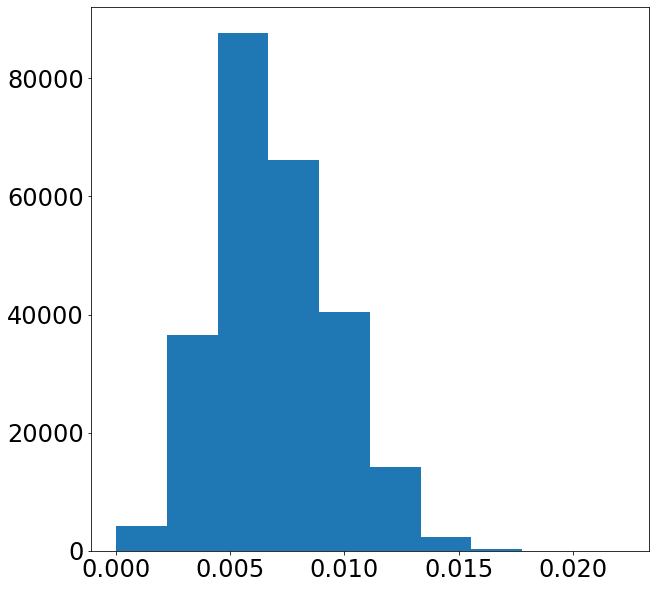

In [404]:
mo_2_cabauw_test = pd.DataFrame(0, index=np.arange(resultTest.shape[0]), columns=["ustar", "tstar", "wthv0", "zeta", "phi_m", "phi_h"])
for i in range(mo_2_idaho_test.shape[0]):
    mo_2_idaho_test.loc[i] = mo_similarity_two_levels(resultTest.loc[i, "2m U-Wind m/s"], 
                                                      resultTest.loc[i, "2m V-Wind m/s"], 
                                                      resultTest.loc[i, "10m U-Wind m/s"],
                                                      resultTest.loc[i, "10m V-Wind m/s"],
                                                      resultTest.loc[i, "2m Temp K"],
                                                      resultTest.loc[i, "10m Temp K"],
                                                      resultTest.loc[i, 'Barometric Pressure hpa'],
                                                      2, 10, 0.05)

(array([2.0929e+04, 9.9592e+04, 7.3755e+04, 3.8879e+04, 1.2460e+04,
        4.1670e+03, 1.3510e+03, 3.8700e+02, 2.2100e+02, 6.4000e+01]),
 array([0.00078271, 0.00426558, 0.00774845, 0.01123133, 0.0147142 ,
        0.01819707, 0.02167994, 0.02516281, 0.02864568, 0.03212856,
        0.03561143]),
 <a list of 10 Patch objects>)

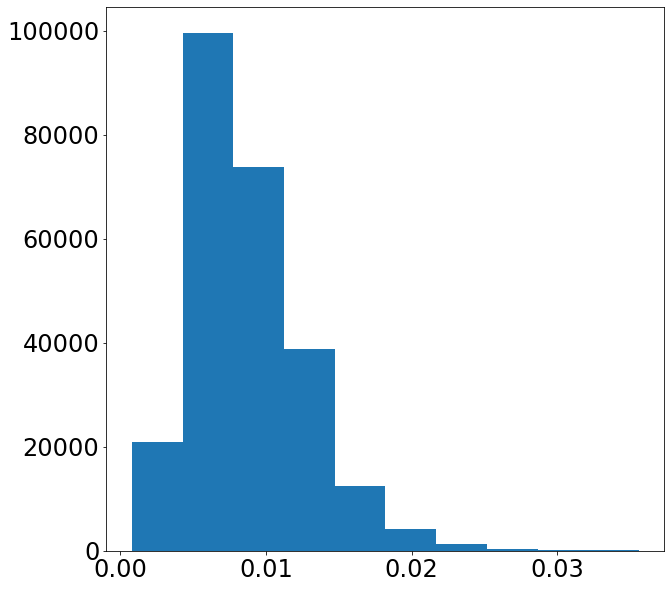

In [405]:
plt.hist(qsfc)

(array([1.7794e+04, 9.4931e+04, 7.3560e+04, 4.3737e+04, 1.4542e+04,
        4.8170e+03, 1.6510e+03, 4.3400e+02, 2.6800e+02, 7.1000e+01]),
 array([ 1.30895084,  6.64476984, 11.98058885, 17.31640786, 22.65222686,
        27.98804587, 33.32386488, 38.65968388, 43.99550289, 49.3313219 ,
        54.6671409 ]),
 <a list of 10 Patch objects>)

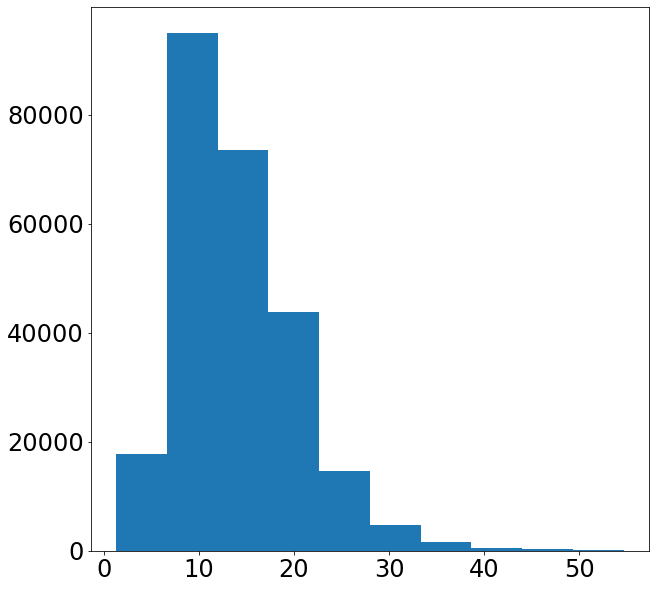

In [406]:
svp2m = saturation_vapor_pressure(tsk)
plt.hist(svp2m)

(array([16816., 87651., 72714., 49281., 16916.,  5524.,  1962.,   548.,
          289.,   104.]),
 array([ 1.87325896,  6.74436456, 11.61547016, 16.48657576, 21.35768136,
        26.22878696, 31.09989256, 35.97099816, 40.84210376, 45.71320936,
        50.58431496]),
 <a list of 10 Patch objects>)

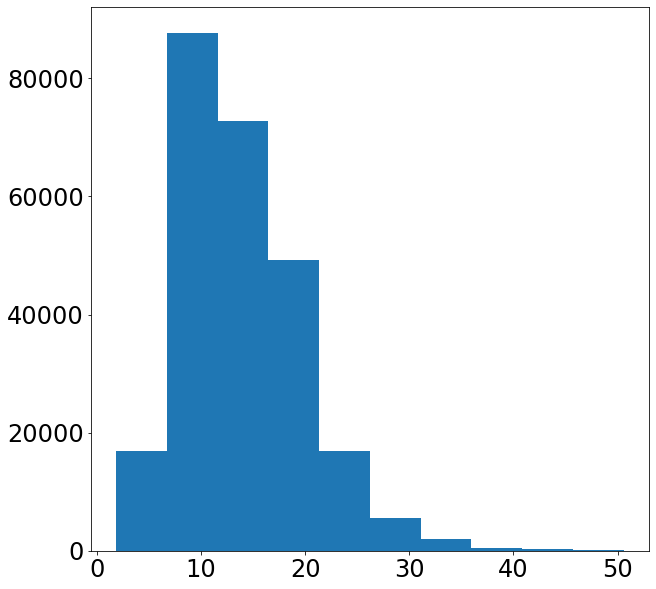

In [407]:
plt.hist(sat_vap_pressure)

The R^2 value is... 0.7869216466564389


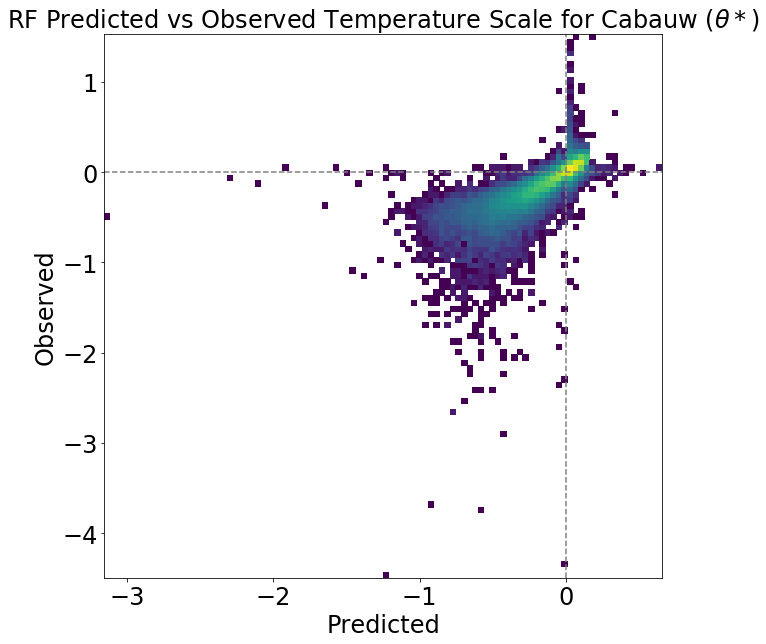

In [49]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsTC
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Observed_tscale_cabauw.png')
plt.show()

The R^2 value is... 0.8135496586128192


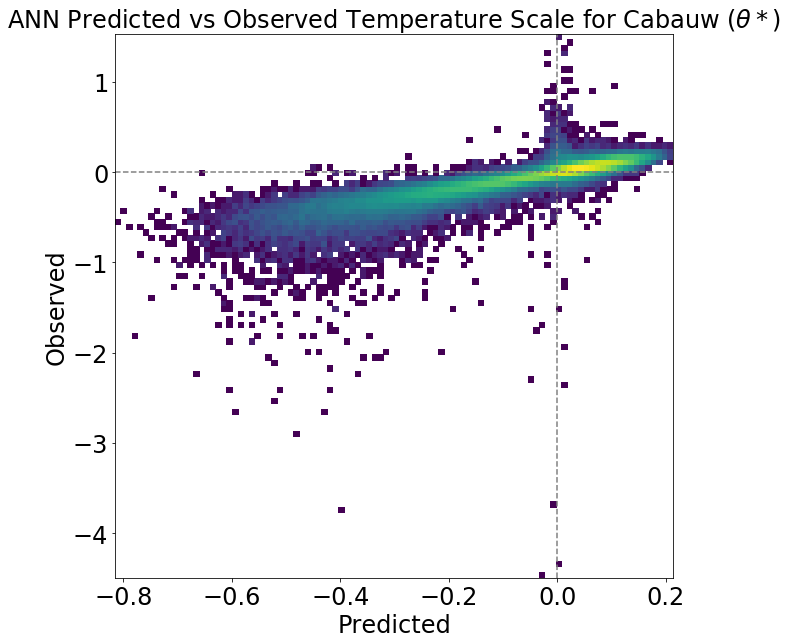

In [50]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsTC
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Observed_tscale_cabauw.png')
plt.show()

In [51]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = np.array(actual_tstar_in)
y = np.array(tstar_in) 
y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_tscale_cabauw.png')
plt.show()

print("MAE for MO Similarity on T-Scale...")
errorsMO_T_C = abs(x - y)
print(np.mean(errorsMO_T_C))

NameError: name 'actual_tstar_in' is not defined

The R^2 value is... 0.669260369634187


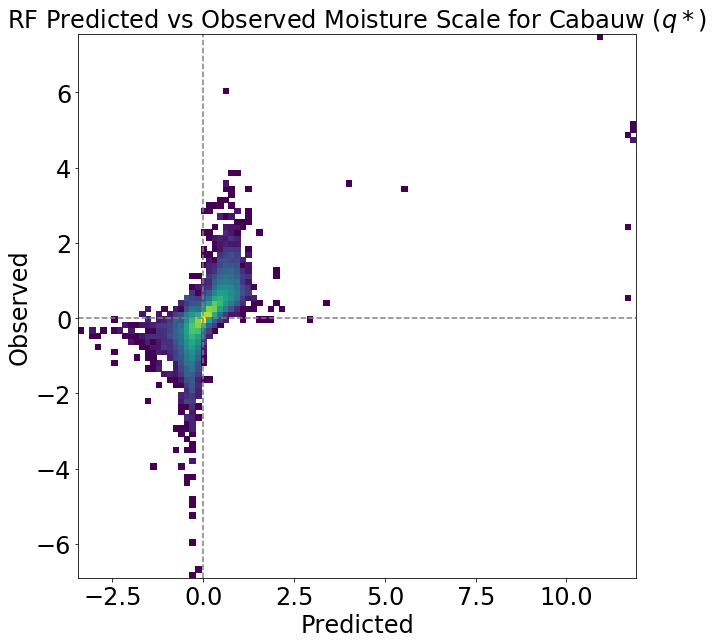

In [52]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsMC
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_mscale_cabauw.png')
plt.show()

The R^2 value is... 0.6953113817001896


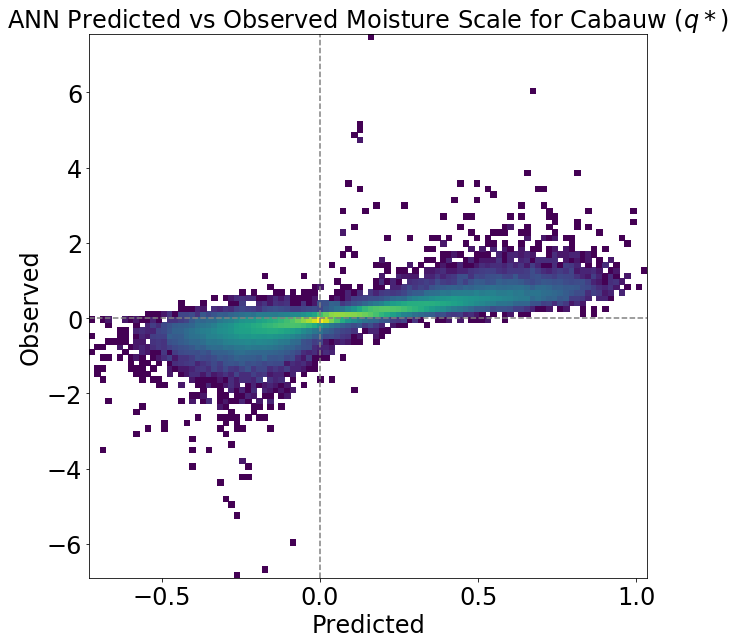

In [53]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsMC
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_mscale_cabauw.png')
plt.show()

In [54]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]

x = np.array(qstar_in)
y = np.array(actual_qstar_in) 

y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Moisture Scale for Cabauw', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_mscale_cabauw.png')
plt.show()

print("MAE for MO Similarity on Moisture Scale...")
errorsMO_FVI_C = abs(x - y)
print(np.mean(errorsMO_FVI_C))

NameError: name 'qstar_in' is not defined

The R^2 value is... 0.9316859960839927


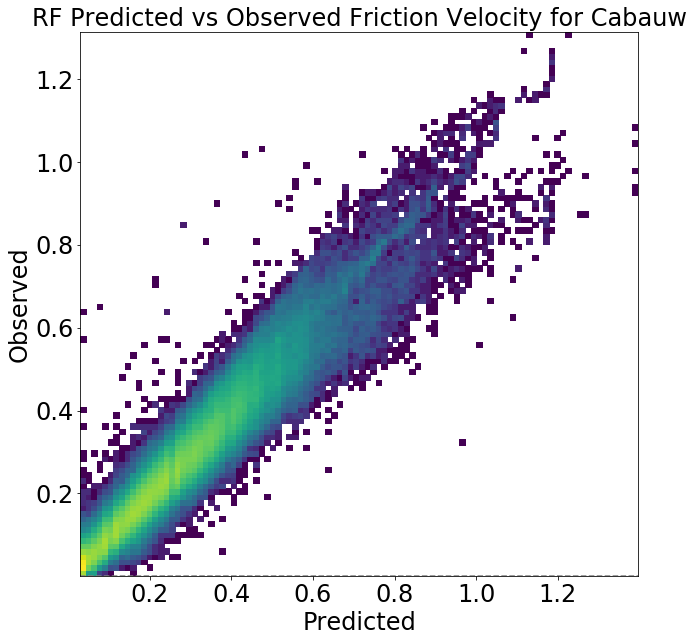

In [55]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsFC
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF Predicted vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Observed_friction-velocity_cabauw.png')
plt.show()

The R^2 value is... 0.9293476558141677


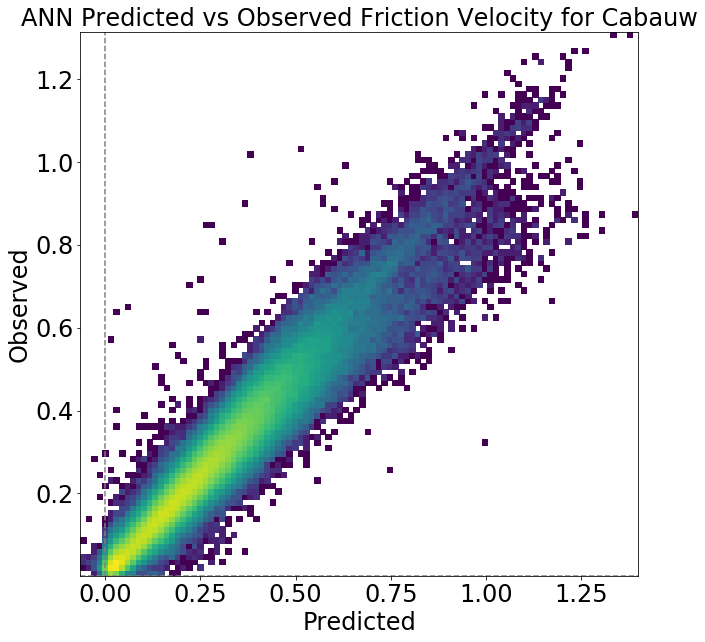

In [56]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsFC
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN Predicted vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Observed_friction-velocity_cabauw.png')
plt.show()

In [57]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = np.array(actual_ustar_in)
y = np.array(ustar_in) 
y = y[x>-5] # Filter out a bad data point
x = x[x>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('M-O Similarity vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('M-O Similarity', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('MO_Observed_friction-velocity_cabauw.png')
plt.show()

print("MAE for MO Similarity on Friction Velocity...")
errorsMO_FV_C = abs(x - y)
print(np.mean(errorsMO_FV_C))


NameError: name 'actual_ustar_in' is not defined

In [60]:
# Use the forest's predict method on the test data
predictionsMI_C = rfM.predict(test_featuresMC.iloc[:,0:16])
predictionsTI_C = rfT.predict(test_featuresTC.iloc[:,0:16])
predictionsFI_C = rfF.predict(test_featuresFC.iloc[:,0:16])

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsMI_C = abs(predictionsMI_C - test_labelsMC)
errorsTI_C = abs(predictionsTI_C - test_labelsTC)
errorsFI_C = abs(predictionsFI_C - test_labelsFC)
# Print out the mean absolute error (mae)
print('Results below for RF trained on Idaho and applied to Cabauw')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsMI_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsTI_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsFI_C), 4))
print("R2 Moisture Scale:", np.corrcoef(predictionsMI_C, test_labelsMC)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(predictionsTI_C, test_labelsTC)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(predictionsFI_C, test_labelsFC)[0, 1] ** 2)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    1.0s


Results below for RF trained on Idaho and applied to Cabauw
Mean Absolute Error for predicting Moisture Scale: 0.1068
Mean Absolute Error for predicting Temperature Scale: 0.07
Mean Absolute Error for predicting Friction Velocity: 0.0799
R2 Moisture Scale: 0.4358913583390969
R2 Temperature Scale: 0.5254081885829646
R2 Friction Velocity: 0.8962068763968545


[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.3s finished


In [112]:
test_labelsTC

Time
2011-01-01 00:00:00    0.058993
2011-01-01 00:10:00    0.068002
2011-01-01 00:20:00    0.045932
2011-01-01 00:30:00    0.085433
2011-01-01 00:40:00    0.074261
                         ...   
2017-04-12 06:30:00   -0.001990
2017-04-12 06:40:00    0.000676
2017-04-12 06:50:00    0.014875
2017-04-12 07:00:00   -0.001975
2017-04-12 07:10:00    0.010915
Name: temperature scale_surface_K, Length: 318714, dtype: float64

In [ ]:
scal

In [64]:
# Use the forest's predict method on the test data
ANNpredictionsMI_C = ANN_M.predict(scaler_cabauw.transform(test_featuresMC.iloc[:,0:16]))
ANNpredictionsTI_C = ANN_T.predict(scaler_cabauw.transform(test_featuresTC.iloc[:,0:16]))
ANNpredictionsFI_C = ANN_F.predict(scaler_cabauw.transform(test_featuresFC.iloc[:,0:16]))


ANNpredictionsMI_C = ANNpredictionsMI_C.reshape(len(ANNpredictionsMI_C,))
ANNpredictionsTI_C = ANNpredictionsTI_C.reshape(len(ANNpredictionsTI_C,))
ANNpredictionsFI_C = ANNpredictionsFI_C.reshape(len(ANNpredictionsFI_C,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMI_C = abs(ANNpredictionsMI_C - test_labelsMC)
ANNerrorsTI_C = abs(ANNpredictionsTI_C - test_labelsTC)
ANNerrorsFI_C = abs(ANNpredictionsFI_C - test_labelsFC)
# Print out the mean absolute error (mae)
print('Results below for ANN trained on Idaho and applied to Cabauw')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMI_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTI_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFI_C), 4))
print("R2 Moisture Scale:", np.corrcoef(ANNpredictionsMI_C, test_labelsMC)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(ANNpredictionsTI_C, test_labelsTC)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(ANNpredictionsFI_C, test_labelsFC)[0, 1] ** 2)

Results below for ANN trained on Idaho and applied to Cabauw
Mean Absolute Error for predicting Moisture Scale: 0.1182
Mean Absolute Error for predicting Temperature Scale: 0.1083
Mean Absolute Error for predicting Friction Velocity: 0.0556
R2 Moisture Scale: 0.3391850777874817
R2 Temperature Scale: 0.5459994918783224
R2 Friction Velocity: 0.8640739853636191


In [468]:
print(np.median(ANNerrorsTI_C))

0.4370791227010669


The R^2 value is... 0.7701536211754917


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


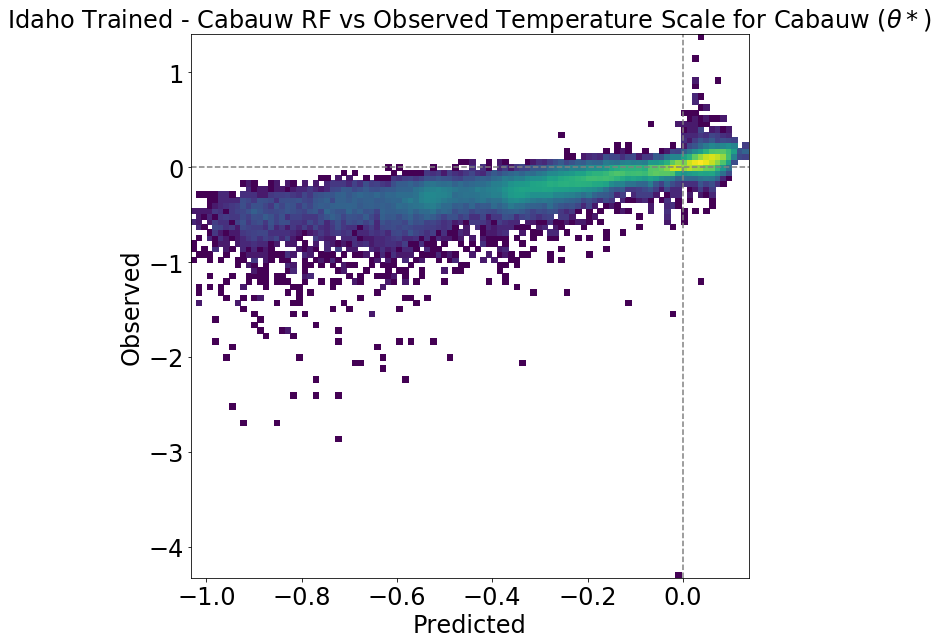

In [419]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsTI_C
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw RF vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Idaho-on-Cabauw_Observed_tscale_cabauw.png')
plt.show()

In [97]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsTI_C
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw ANN vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Idaho-on-Cabauw_Observed_tscale_cabauw.png')
plt.show()

NameError: name 'ANNpredictionsTI_C' is not defined

The R^2 value is... 0.4921762504750218


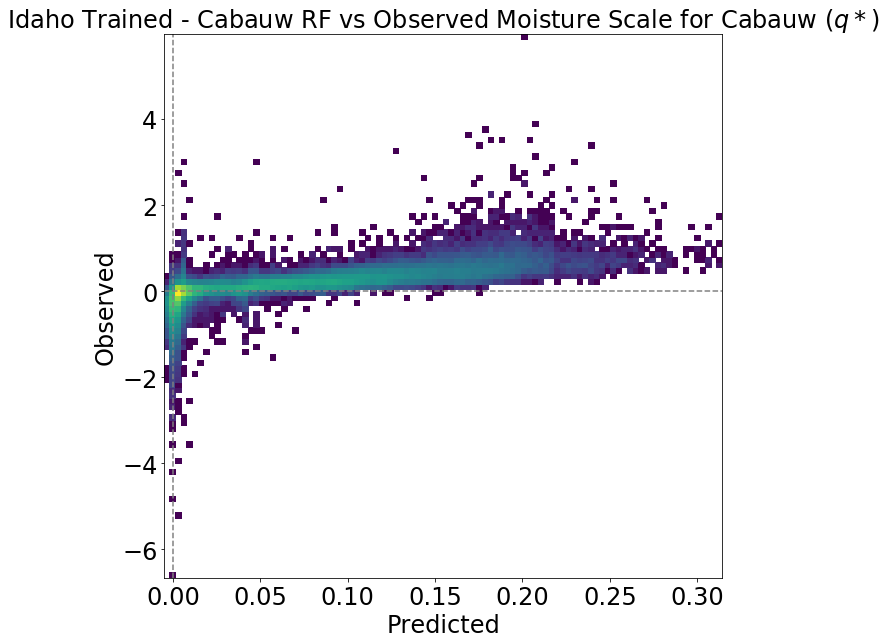

In [421]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsMI_C
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw RF vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Idaho-on-Cabauw_Observed_mscale_cabauw.png')
plt.show()

The R^2 value is... 0.07439238987989465


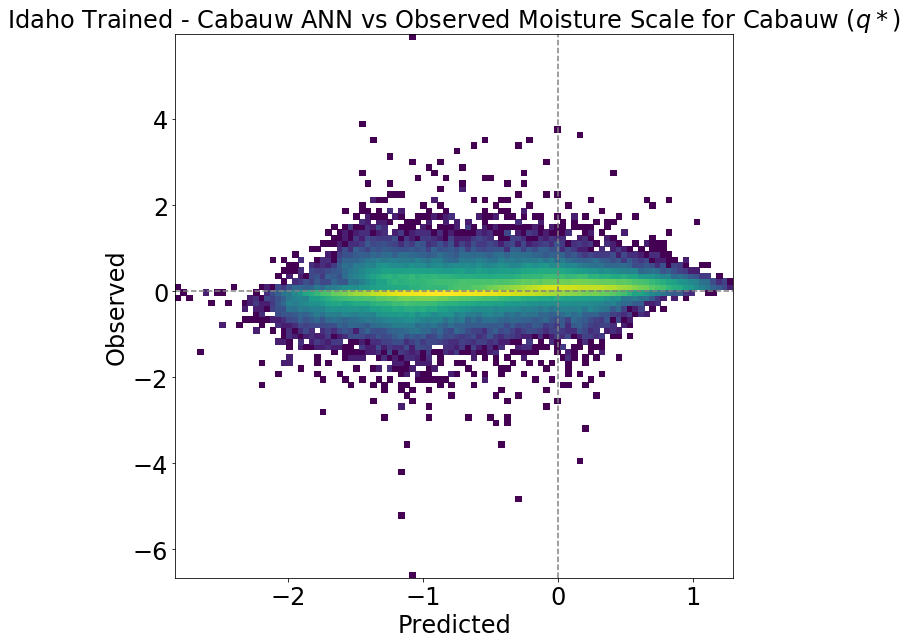

In [422]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsMI_C
y = test_labelsMC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw ANN vs Observed Moisture Scale for Cabauw ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
plt.savefig('ANN_Idaho-on-Cabauw_Observed_mscale_cabauw.png')
plt.show()

The R^2 value is... 0.9048183383234842


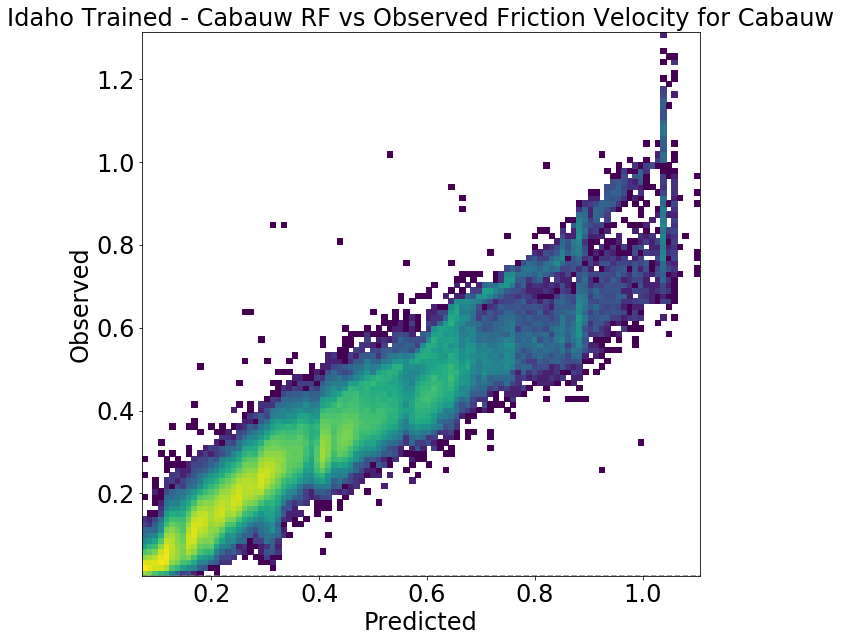

In [423]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsFI_C
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw RF vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Idaho-on-Cabauw_Observed_friction-velocity_cabauw.png')
plt.show()

The R^2 value is... 0.00416069602852991


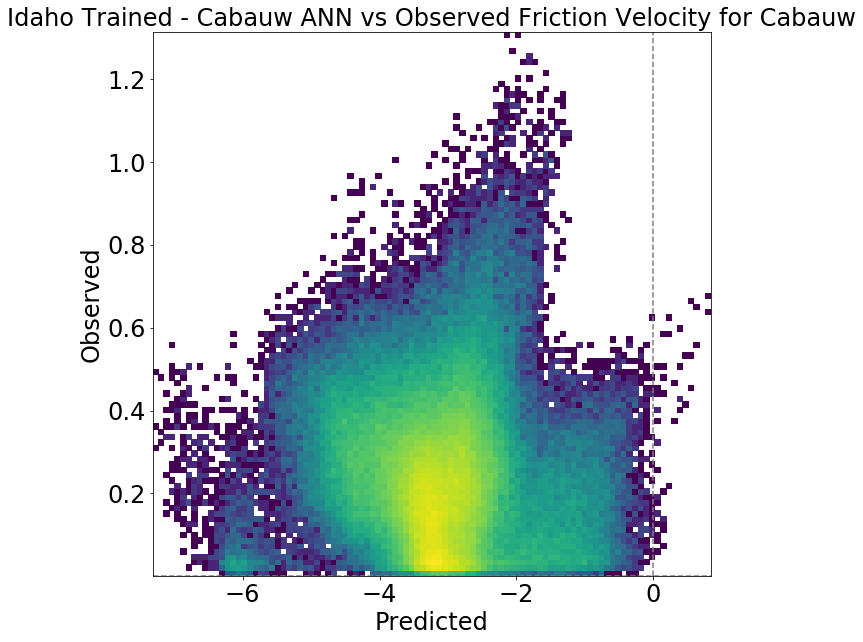

In [424]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsFI_C
y = test_labelsFC
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho Trained - Cabauw ANN vs Observed Friction Velocity for Cabauw', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Idaho-on-Cabauw_Observed_friction-velocity_cabauw.png')
plt.show()

In [68]:
# Use the forest's predict method on the test data
predictionsMC_I = rfMC.predict(test_featuresM.iloc[:,0:16])
predictionsTC_I = rfTC.predict(test_featuresT.iloc[:,0:16])
predictionsFC_I = rfFC.predict(test_featuresF.iloc[:,0:16])


######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsMC_I = abs(predictionsMC_I - test_labelsM)
errorsTC_I = abs(predictionsTC_I - test_labelsT)
errorsFC_I = abs(predictionsFC_I - test_labelsF)
# Print out the mean absolute error (mae)
print('results are for RF Cabauw trained and Idaho predicted:')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsMC_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsTC_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsFC_I), 4))
print("R2 Moisture Scale:", np.corrcoef(predictionsMC_I, test_labelsM)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(predictionsTC_I, test_labelsT)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(predictionsFC_I, test_labelsF)[0, 1] ** 2)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


results are for RF Cabauw trained and Idaho predicted:
Mean Absolute Error for predicting Moisture Scale: 0.3324
Mean Absolute Error for predicting Temperature Scale: 0.1311
Mean Absolute Error for predicting Friction Velocity: 0.0936
R2 Moisture Scale: 0.20073192287762665
R2 Temperature Scale: 0.5490355307186058
R2 Friction Velocity: 0.8806305611817206


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [69]:
# Use the forest's predict method on the test data

ANNpredictionsMC_I = ANN_MC.predict(scaler_M.transform(test_featuresM.iloc[:,0:16]))
ANNpredictionsTC_I = ANN_TC.predict(scaler_M.transform(test_featuresT.iloc[:,0:16]))
ANNpredictionsFC_I = ANN_FC.predict(scaler_M.transform(test_featuresF.iloc[:,0:16]))

ANNpredictionsMC_I = ANNpredictionsMC_I.reshape(len(ANNpredictionsMC_I,))
ANNpredictionsTC_I = ANNpredictionsTC_I.reshape(len(ANNpredictionsTC_I,))
ANNpredictionsFC_I = ANNpredictionsFC_I.reshape(len(ANNpredictionsFC_I,))

######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMC_I = abs(ANNpredictionsMC_I - test_labelsM)
ANNerrorsTC_I = abs(ANNpredictionsTC_I - test_labelsT)
ANNerrorsFC_I = abs(ANNpredictionsFC_I - test_labelsF)
# Print out the mean absolute error (mae)
print('results are for ANN Cabauw trained and Idaho predicted:')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMC_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTC_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFC_I), 4))
print("R2 Moisture Scale:", np.corrcoef(ANNpredictionsMC_I, test_labelsM)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(ANNpredictionsTC_I, test_labelsT)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(ANNpredictionsFC_I, test_labelsF)[0, 1] ** 2)

results are for ANN Cabauw trained and Idaho predicted:
Mean Absolute Error for predicting Moisture Scale: 0.1072
Mean Absolute Error for predicting Temperature Scale: 0.2025
Mean Absolute Error for predicting Friction Velocity: 0.0709
R2 Moisture Scale: 0.21063564610776722
R2 Temperature Scale: 0.46927092547366855
R2 Friction Velocity: 0.8510419917544085


The R^2 value is... 0.7587030335380971


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


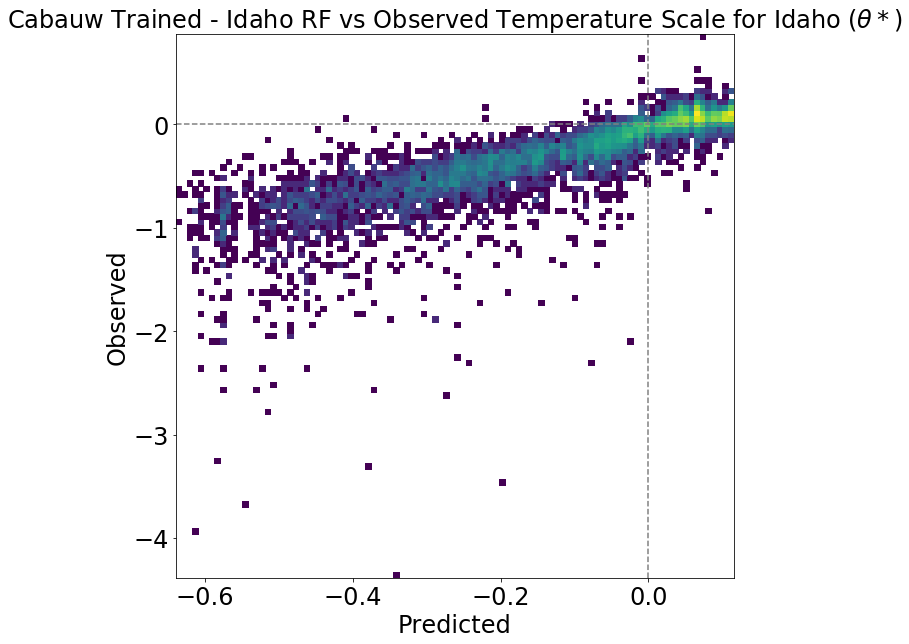

In [427]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsTC_I
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho RF vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_Cabauw-on-Idaho_Observed_tscale_idaho.png')
plt.show()

The R^2 value is... 0.002646127035214109


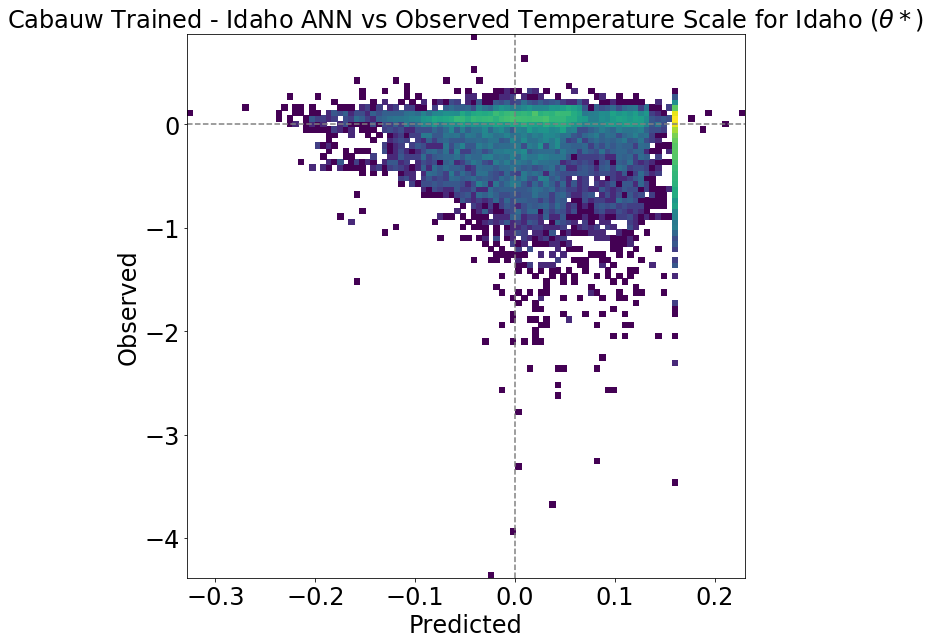

In [428]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsTC_I
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho ANN vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_Cabauw-on-Idaho_Observed_tscale_idaho.png')
plt.show()

The R^2 value is... 0.21943504407999243


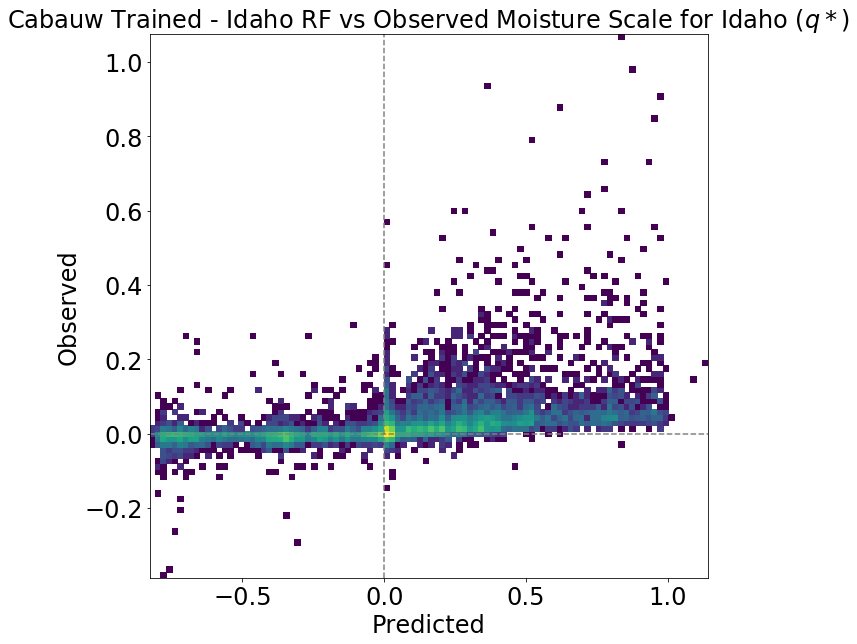

In [429]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsMC_I
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho RF vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Cabauw-on-Idaho_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.25927427321198787


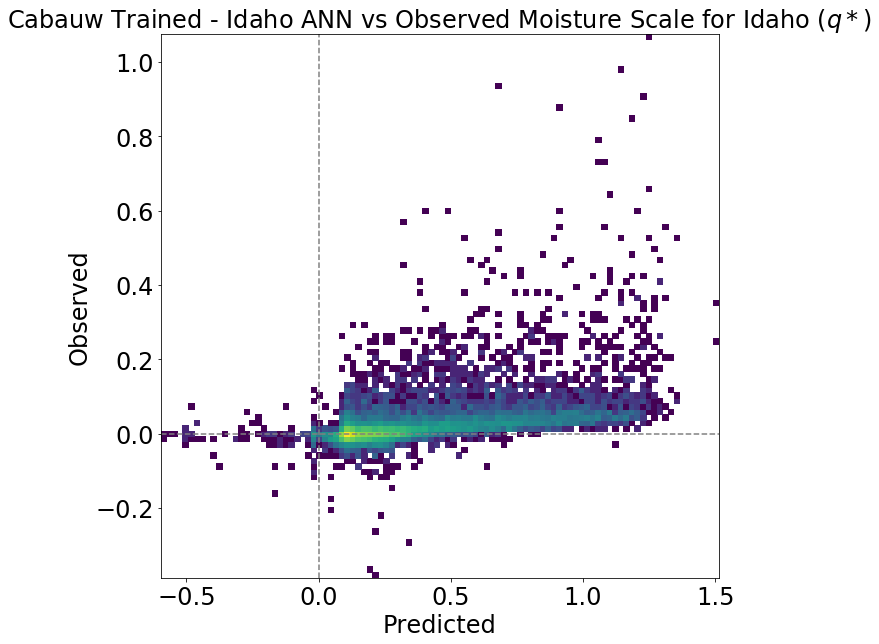

In [430]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsMC_I
y = test_labelsM
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho ANN vs Observed Moisture Scale for Idaho ($q*$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Cabauw-on-Idaho_Observed_mscale_idaho.png')
plt.show()

The R^2 value is... 0.876504269101724


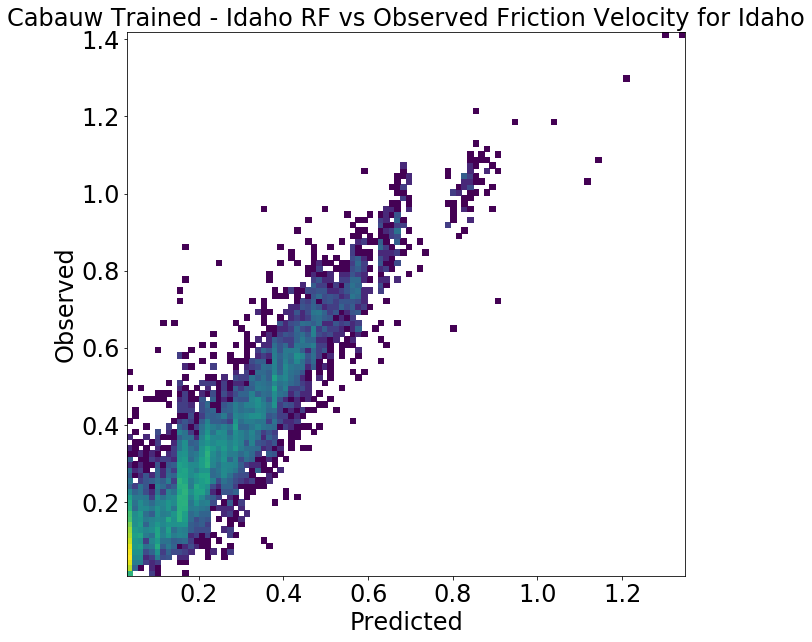

In [431]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsFC_I
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho RF vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('RF_Cabauw-on-Idaho_Observed_friction-velocity_idaho.png')
plt.show()

The R^2 value is... 0.34574859070184316


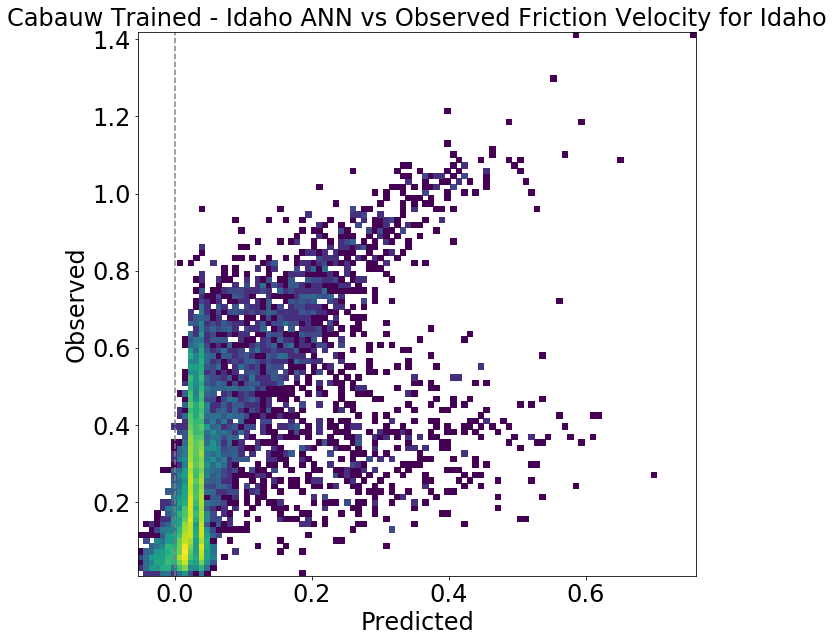

In [432]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsFC_I
y = test_labelsF
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Cabauw Trained - Idaho ANN vs Observed Friction Velocity for Idaho', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(0, 1.5), np.linspace(0, 1.5), 'k--')
plt.savefig('ANN_Cabauw-on-Idaho_Observed_friction-velocity_idaho.png')
plt.show()

## Combined Training and Testing

In [70]:
## Add training datasets together and predicted on combined test datasets
trainingM = [train_featuresM.iloc[:,0:16],train_featuresMC.iloc[:,0:16]]
trainM = pd.concat(trainingM)
trainingF = [train_featuresF.iloc[:,0:16],train_featuresFC.iloc[:,0:16]]
trainF = pd.concat(trainingF)
trainingT = [train_featuresT.iloc[:,0:16],train_featuresTC.iloc[:,0:16]]
trainT = pd.concat(trainingT)

testingM = [test_featuresM.iloc[:,0:16],test_featuresMC.iloc[:,0:16]]
testM = pd.concat(testingM)
testingF = [test_featuresF.iloc[:,0:16],test_featuresFC.iloc[:,0:16]]
testF = pd.concat(testingF)
testingT = [test_featuresT.iloc[:,0:16],test_featuresTC.iloc[:,0:16]]
testT = pd.concat(testingT)

training_labelsM = [train_labelsM,train_labelsMC]
train_labelsMA = pd.concat(training_labelsM)
training_labelsF = [train_labelsF,train_labelsFC]
train_labelsFA = pd.concat(training_labelsF)
training_labelsT = [train_labelsT,train_labelsTC]
train_labelsTA = pd.concat(training_labelsT)

testing_labelsM = [test_labelsM,test_labelsMC]
test_labelsMA = pd.concat(testing_labelsM)
testing_labelsF = [test_labelsF,test_labelsFC]
test_labelsFA = pd.concat(testing_labelsF)
testing_labelsT = [test_labelsT,test_labelsTC]
test_labelsTA = pd.concat(testing_labelsT)

In [434]:
print(np.shape(train_labelsM))
print(np.shape(train_labelsMC))
print(np.shape(train_featuresM))
print(np.shape(train_featuresMC))

(28918,)
(403140,)
(28918, 16)
(403140, 21)


In [71]:
######### Configure and train the Random Forest ##############
# Import the Random Forest Model
# Instantiate model 
rfM_All = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfT_All = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
rfF_All = RandomForestRegressor(n_estimators= 200, n_jobs=4, random_state=2, max_leaf_nodes = 200,criterion='mse',min_samples_split=50,min_samples_leaf=50)
# Train the model on training data
rfM_All.fit(trainM, train_labelsMA)
rfF_All.fit(trainF, train_labelsFA)
rfT_All.fit(trainT, train_labelsTA)

# Use the forest's predict method on the test data
predictionsM_All = rfM_All.predict(testM)
predictionsT_All = rfT_All.predict(testT)
predictionsF_All = rfF_All.predict(testF)

######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM_All = abs(predictionsM_All - test_labelsMA)
errorsT_All = abs(predictionsT_All - test_labelsTA)
errorsF_All = abs(predictionsF_All - test_labelsFA)
# Print out the mean absolute error (mae)
print('MAES for RF trained on all')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM_All), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT_All), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF_All), 4))
print("R2 Moisture Scale:", np.corrcoef(predictionsM_All, test_labelsMA)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(predictionsT_All, test_labelsTA)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(predictionsF_All, test_labelsFA)[0, 1] ** 2)

MAES for RF trained on all
Mean Absolute Error for predicting Moisture Scale: 0.0552
Mean Absolute Error for predicting Temperature Scale: 0.0335
Mean Absolute Error for predicting Friction Velocity: 0.032
R2 Moisture Scale: 0.7003038169136334
R2 Temperature Scale: 0.6500673277633542
R2 Friction Velocity: 0.9267410512399145


In [436]:
print(np.shape(ANNpredictionsMC_All))
print(np.shape(testM))

(263575,)
(263575, 16)


In [72]:
ANN_MC_All = build_model(np.asarray(trainM))
ANN_TC_All = build_model(np.asarray(trainT))
ANN_FC_All = build_model(np.asarray(trainF))
scaler_all = StandardScaler()
train_all_norm = scaler_all.fit_transform(trainM)
test_all_norm = scaler_all.transform(testM)
# Train the model on training data
historyMC_All = ANN_MC_All.fit(train_all_norm, np.asarray(train_labelsMA), epochs=EPOCHS, validation_split=0.2,verbose=1)
historyFC_All = ANN_FC_All.fit(train_all_norm, np.asarray(train_labelsFA), epochs=EPOCHS, validation_split=0.2,verbose=1)
historyTC_All = ANN_TC_All.fit(train_all_norm, np.asarray(train_labelsTA), epochs=EPOCHS, validation_split=0.2,verbose=1)

# Use the forest's predict method on the test data
ANNpredictionsMC_All = ANN_MC_All.predict(test_all_norm)
ANNpredictionsTC_All = ANN_TC_All.predict(test_all_norm)
ANNpredictionsFC_All = ANN_FC_All.predict(test_all_norm)

ANNpredictionsMC_All = ANNpredictionsMC_All.reshape(len(ANNpredictionsMC_All,))
ANNpredictionsTC_All = ANNpredictionsTC_All.reshape(len(ANNpredictionsTC_All,))
ANNpredictionsFC_All = ANNpredictionsFC_All.reshape(len(ANNpredictionsFC_All,))


Train on 345643 samples, validate on 86411 samples
Epoch 1/30
345643/345643 [==============================] - 19s 55us/sample - loss: 0.0593 - mae: 0.0593 - val_loss: 0.0583 - val_mae: 0.05830s - loss: 0.0594 - mae
Epoch 2/30
345643/345643 [==============================] - 21s 60us/sample - loss: 0.0535 - mae: 0.0535 - val_loss: 0.0584 - val_mae: 0.0584
Epoch 3/30
345643/345643 [==============================] - 23s 67us/sample - loss: 0.0519 - mae: 0.0519 - val_loss: 0.0557 - val_mae: 0.0557
Epoch 4/30
345643/345643 [==============================] - 21s 60us/sample - loss: 0.0511 - mae: 0.0511 - val_loss: 0.0551 - val_mae: 0.0551
Epoch 5/30
345643/345643 [==============================] - 20s 58us/sample - loss: 0.0505 - mae: 0.0505 - val_loss: 0.0558 - val_mae: 0.0558
Epoch 6/30
345643/345643 [==============================] - 19s 56us/sample - loss: 0.0501 - mae: 0.0501 - val_loss: 0.0547 - val_mae: 0.0547
Epoch 7/30
345643/345643 [==============================] - 20s 57us/sampl

In [81]:
######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsMC_All = abs(ANNpredictionsMC_All - test_labelsMA)
ANNerrorsTC_All = abs(ANNpredictionsTC_All - test_labelsTA)
ANNerrorsFC_All = abs(ANNpredictionsFC_All - test_labelsFA)
# Print out the mean absolute error (mae)
print('MAES for ANNs trained on all for cabauw')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsMC_All), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsTC_All), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsFC_All), 4))
print("R2 Moisture Scale:", np.corrcoef(ANNpredictionsMC_All, test_labelsMA)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(ANNpredictionsTC_All, test_labelsTA)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(ANNpredictionsFC_All, test_labelsFA)[0, 1] ** 2)


MAES for ANNs trained on all for cabauw
Mean Absolute Error for predicting Moisture Scale: 0.0534
Mean Absolute Error for predicting Temperature Scale: 0.0321
Mean Absolute Error for predicting Friction Velocity: 0.0317
R2 Moisture Scale: 0.7032565335171512
R2 Temperature Scale: 0.6596521371549904
R2 Friction Velocity: 0.926153734261176


In [79]:
# Use the RF-All to predict the Idaho and Cabauw Test Datasets
predictionsM_Idaho_All = rfM_All.predict(test_featuresM.iloc[:,0:16])
predictionsT_Idaho_All = rfT_All.predict(test_featuresT.iloc[:,0:16])
predictionsF_Idaho_All = rfF_All.predict(test_featuresF.iloc[:,0:16])

predictionsM_Cabauw_All = rfM_All.predict(test_featuresMC.iloc[:,0:16])
predictionsT_Cabauw_All = rfT_All.predict(test_featuresTC.iloc[:,0:16])
predictionsF_Cabauw_All = rfF_All.predict(test_featuresFC.iloc[:,0:16])

# Use the ANN-All to predict the Idaho and Cabauw Test Datasets
test_idaho_norm_all = scaler_all.transform(test_featuresM.iloc[:,0:16])
ANNpredictionsM_Idaho_All = ANN_MC_All.predict(test_idaho_norm_all)
ANNpredictionsT_Idaho_All = ANN_TC_All.predict(test_idaho_norm_all)
ANNpredictionsF_Idaho_All = ANN_FC_All.predict(test_idaho_norm_all)

ANNpredictionsM_Idaho_All = ANNpredictionsM_Idaho_All.reshape(len(ANNpredictionsM_Idaho_All,))
ANNpredictionsT_Idaho_All = ANNpredictionsT_Idaho_All.reshape(len(ANNpredictionsT_Idaho_All,))
ANNpredictionsF_Idaho_All = ANNpredictionsF_Idaho_All.reshape(len(ANNpredictionsF_Idaho_All,))
test_cabauw_norm_all = scaler_all.transform(test_featuresMC.iloc[:,0:16])
ANNpredictionsM_Cabauw_All = ANN_MC_All.predict(test_cabauw_norm_all)
ANNpredictionsT_Cabauw_All = ANN_TC_All.predict(test_cabauw_norm_all)
ANNpredictionsF_Cabauw_All = ANN_FC_All.predict(test_cabauw_norm_all)

ANNpredictionsM_Cabauw_All = ANNpredictionsM_Cabauw_All.reshape(len(ANNpredictionsM_Cabauw_All,))
ANNpredictionsT_Cabauw_All = ANNpredictionsT_Cabauw_All.reshape(len(ANNpredictionsT_Cabauw_All,))
ANNpredictionsF_Cabauw_All = ANNpredictionsF_Cabauw_All.reshape(len(ANNpredictionsF_Cabauw_All,))

In [82]:
######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM_All_C = abs(predictionsM_Cabauw_All - test_labelsMC)
errorsT_All_C = abs(predictionsT_Cabauw_All - test_labelsTC)
errorsF_All_C = abs(predictionsF_Cabauw_All - test_labelsFC)
# Print out the mean absolute error (mae)
print('RF for Cabauw trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM_All_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT_All_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF_All_C), 4))
print("R2 Moisture Scale:", np.corrcoef(predictionsM_Cabauw_All, test_labelsMC)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(predictionsT_Cabauw_All, test_labelsTC)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(predictionsF_Cabauw_All, test_labelsFC)[0, 1] ** 2)
# Calculate the absolute errors
ANNerrorsM_All_C = abs(ANNpredictionsM_Cabauw_All - test_labelsMC)
ANNerrorsT_All_C = abs(ANNpredictionsT_Cabauw_All - test_labelsTC)
ANNerrorsF_All_C = abs(ANNpredictionsF_Cabauw_All - test_labelsFC)
# Print out the mean absolute error (mae)
print('ANN for Cabauw trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsM_All_C), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsT_All_C), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsF_All_C), 4))
print("R2 Moisture Scale:", np.corrcoef(ANNpredictionsM_Cabauw_All, test_labelsMC)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(ANNpredictionsT_Cabauw_All, test_labelsTC)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(ANNpredictionsF_Cabauw_All, test_labelsFC)[0, 1] ** 2)

RF for Cabauw trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.0562
Mean Absolute Error for predicting Temperature Scale: 0.0316
Mean Absolute Error for predicting Friction Velocity: 0.0313
R2 Moisture Scale: 0.701534041579232
R2 Temperature Scale: 0.6348342772137686
R2 Friction Velocity: 0.9292974570167524
ANN for Cabauw trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.0546
Mean Absolute Error for predicting Temperature Scale: 0.0304
Mean Absolute Error for predicting Friction Velocity: 0.0312
R2 Moisture Scale: 0.7040740435794209
R2 Temperature Scale: 0.6437741385794831
R2 Friction Velocity: 0.9269913395893168


In [84]:
######### Compute Errors on Test Data #############
# Calculate the absolute errors
errorsM_All_I = abs(predictionsM_Idaho_All - test_labelsM)
errorsT_All_I = abs(predictionsT_Idaho_All - test_labelsT)
errorsF_All_I = abs(predictionsF_Idaho_All - test_labelsF)
# Print out the mean absolute error (mae)
print('RF for Idaho trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(errorsM_All_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(errorsT_All_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(errorsF_All_I), 4))
print("R2 Moisture Scale:", np.corrcoef(predictionsM_Idaho_All, test_labelsM)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(predictionsT_Idaho_All, test_labelsT)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(predictionsF_Idaho_All, test_labelsF)[0, 1] ** 2)
######### Compute Errors on Test Data #############
# Calculate the absolute errors
ANNerrorsM_All_I = abs(ANNpredictionsM_Idaho_All - test_labelsM)
ANNerrorsT_All_I = abs(ANNpredictionsT_Idaho_All - test_labelsT)
ANNerrorsF_All_I = abs(ANNpredictionsF_Idaho_All - test_labelsF)
# Print out the mean absolute error (mae)
print('ANN for Idaho trained on all data')
print('Mean Absolute Error for predicting Moisture Scale:', round(np.mean(ANNerrorsM_All_I), 4))
print('Mean Absolute Error for predicting Temperature Scale:', round(np.mean(ANNerrorsT_All_I), 4))
print('Mean Absolute Error for predicting Friction Velocity:', round(np.mean(ANNerrorsF_All_I), 4))
print("R2 Moisture Scale:", np.corrcoef(ANNpredictionsM_Idaho_All, test_labelsM)[0, 1] ** 2)
print("R2 Temperature Scale:", np.corrcoef(ANNpredictionsT_Idaho_All, test_labelsT)[0, 1] ** 2)
print("R2 Friction Velocity:", np.corrcoef(ANNpredictionsF_Idaho_All, test_labelsF)[0, 1] ** 2)

RF for Idaho trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.029
Mean Absolute Error for predicting Temperature Scale: 0.0835
Mean Absolute Error for predicting Friction Velocity: 0.0518
R2 Moisture Scale: 0.26306327228787213
R2 Temperature Scale: 0.6622294912760475
R2 Friction Velocity: 0.8889302637966685
ANN for Idaho trained on all data
Mean Absolute Error for predicting Moisture Scale: 0.0216
Mean Absolute Error for predicting Temperature Scale: 0.0787
Mean Absolute Error for predicting Friction Velocity: 0.0459
R2 Moisture Scale: 0.49352582401544826
R2 Temperature Scale: 0.6670480479797235
R2 Friction Velocity: 0.9109543333936307


The R^2 value is... 0.7954570724867629


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


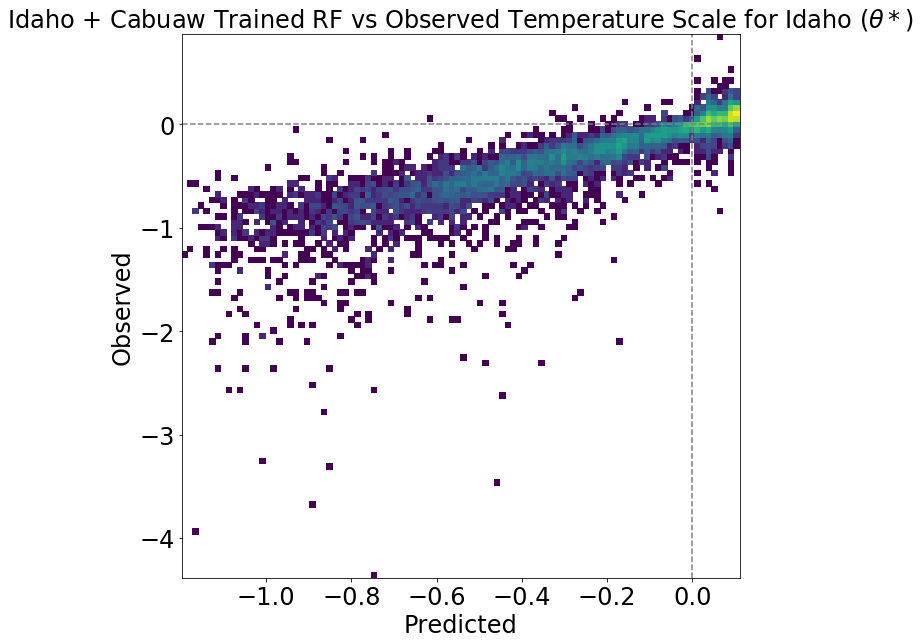

In [442]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsT_Idaho_All
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-idaho_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7839440326784866


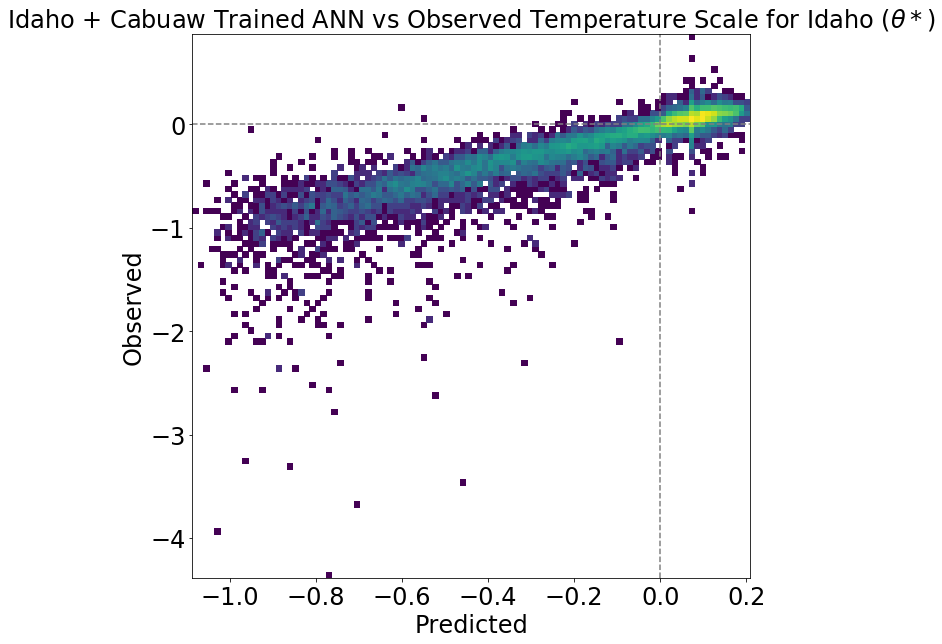

In [443]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsT_Idaho_All
y = test_labelsT
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Temperature Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-idaho_Observed_tscale.png')
plt.show()

The R^2 value is... 0.24516255087555866


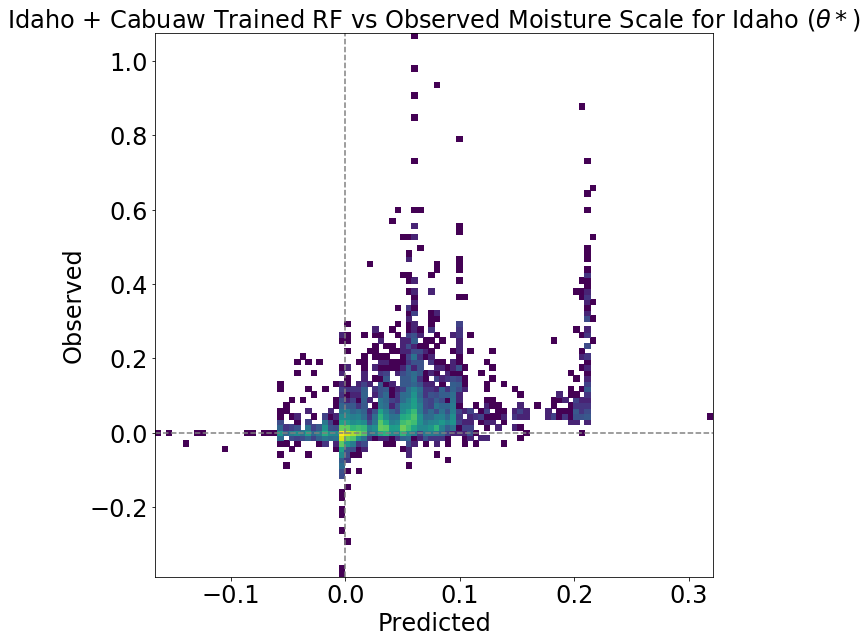

In [444]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsM_Idaho_All
y = test_labelsM
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Moisture Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-idaho_Observed_mscale.png')
plt.show()

The R^2 value is... 0.3154384313058464


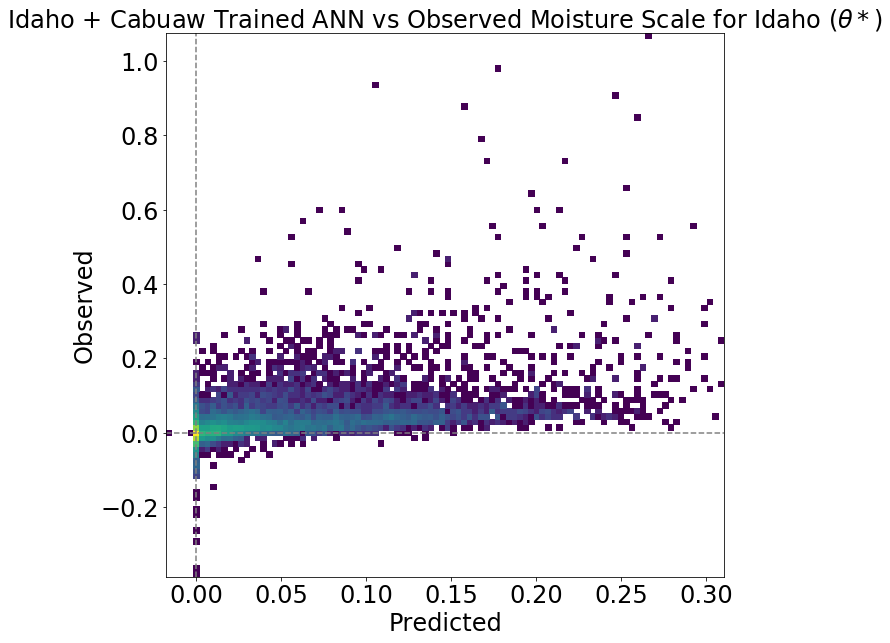

In [445]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsM_Idaho_All
y = test_labelsM
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Moisture Scale for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-idaho_Observed_mscale.png')
plt.show()

The R^2 value is... 0.8887763261130883


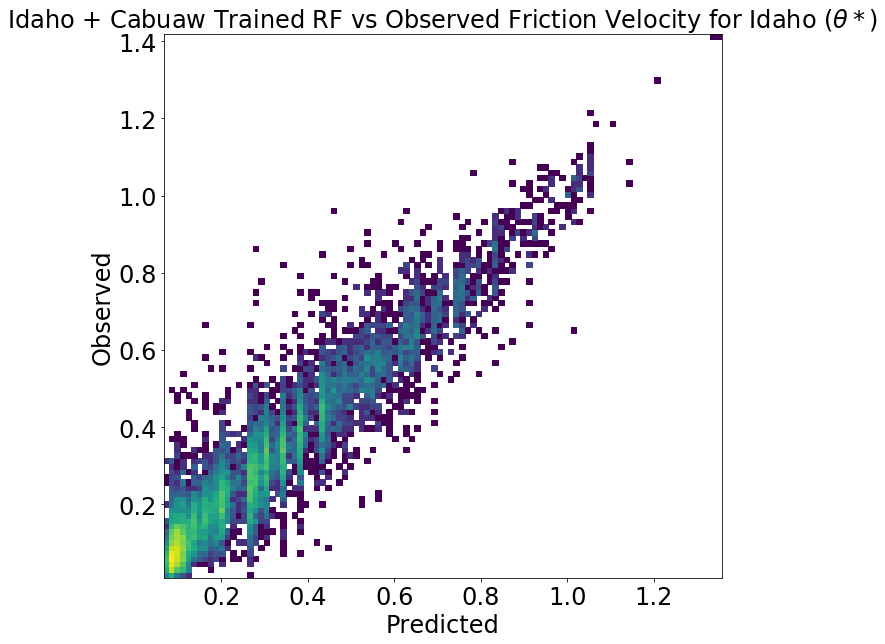

In [446]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsF_Idaho_All
y = test_labelsF
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Friction Velocity for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-idaho_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8955673967154788


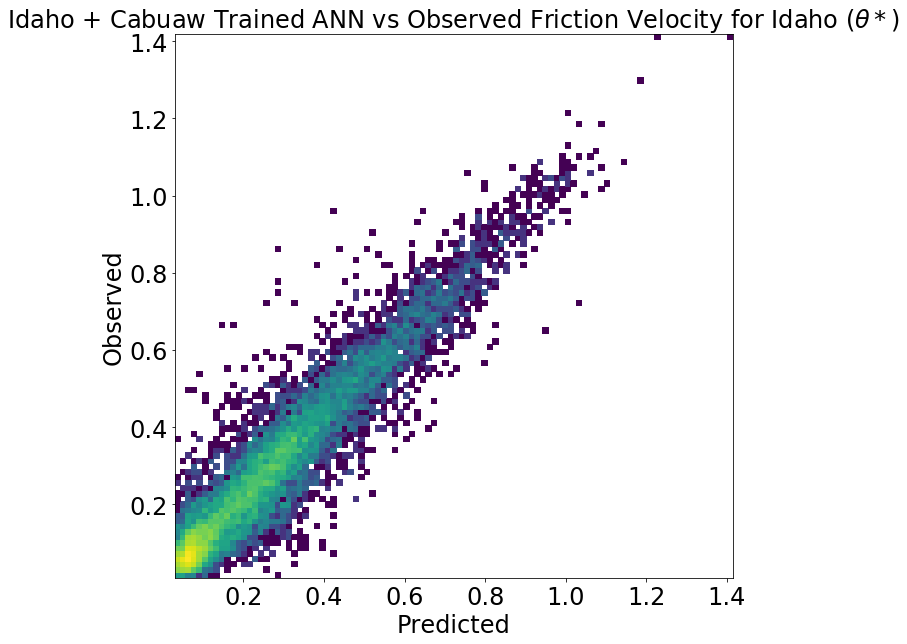

In [447]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsF_Idaho_All
y = test_labelsF
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Friction Velocity for Idaho ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-idaho_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8160811318049878


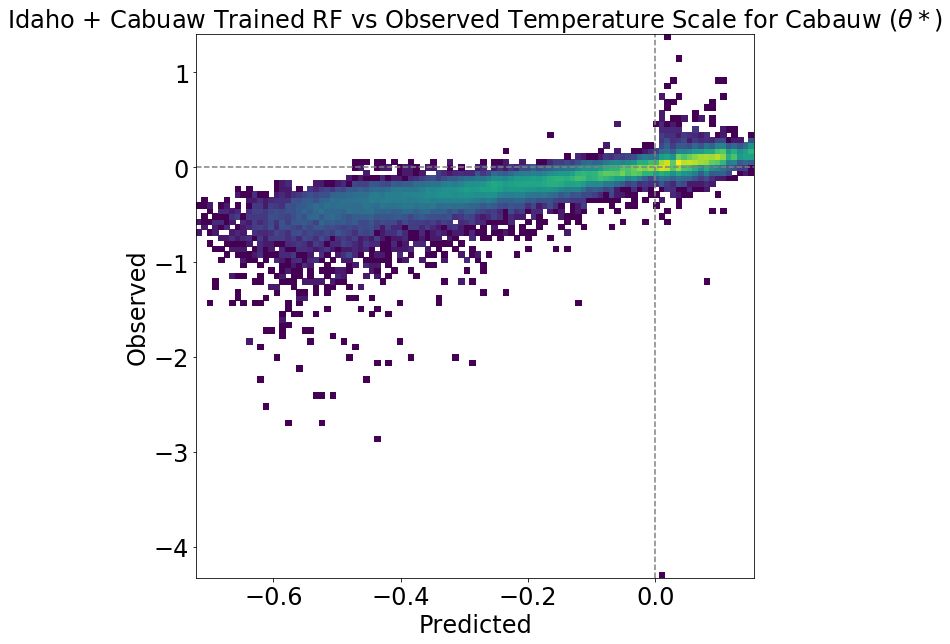

In [448]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsT_Cabauw_All
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-cabauw_Observed_tscale.png')
plt.show()

The R^2 value is... 0.8023072221087385


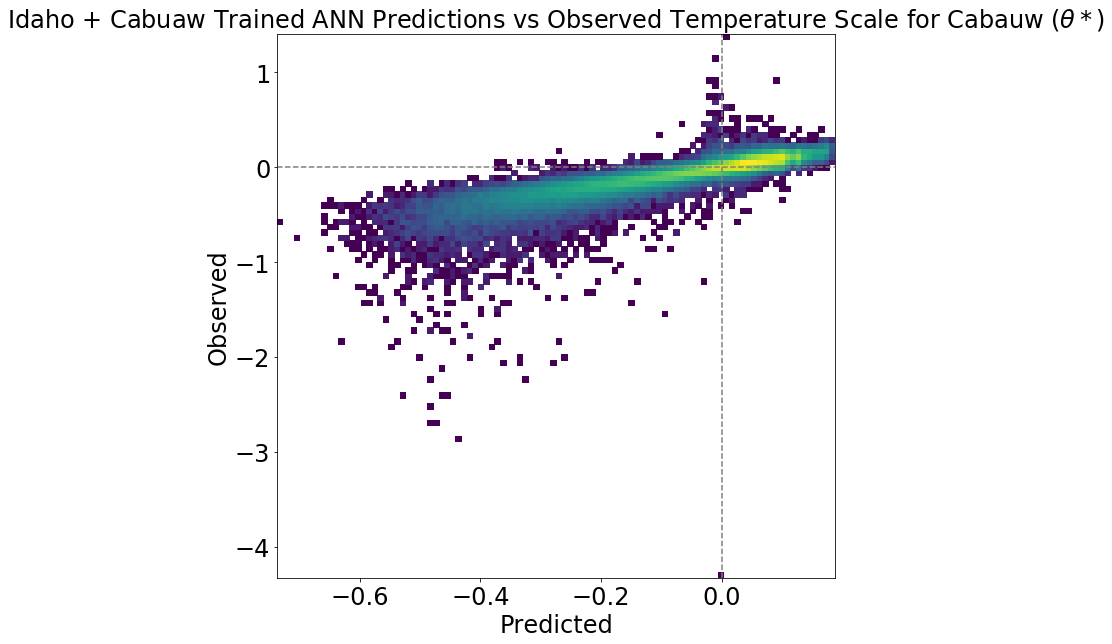

In [449]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsT_Cabauw_All
y = test_labelsTC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN Predictions vs Observed Temperature Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-cabauw_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7326985692497611


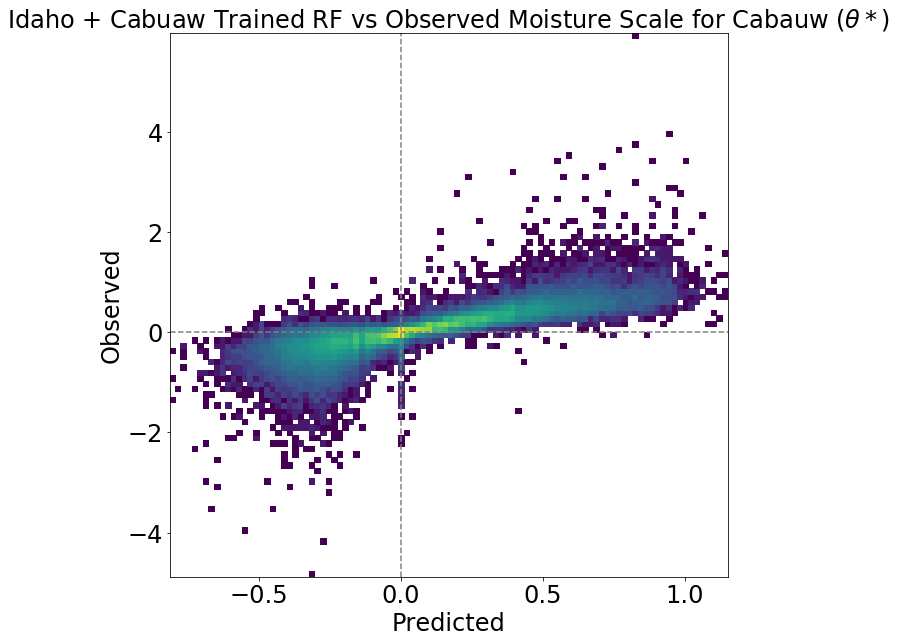

In [450]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsM_Cabauw_All
y = test_labelsMC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Moisture Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-cabauw_Observed_mscale.png')
plt.show()

The R^2 value is... 0.7162078476656472


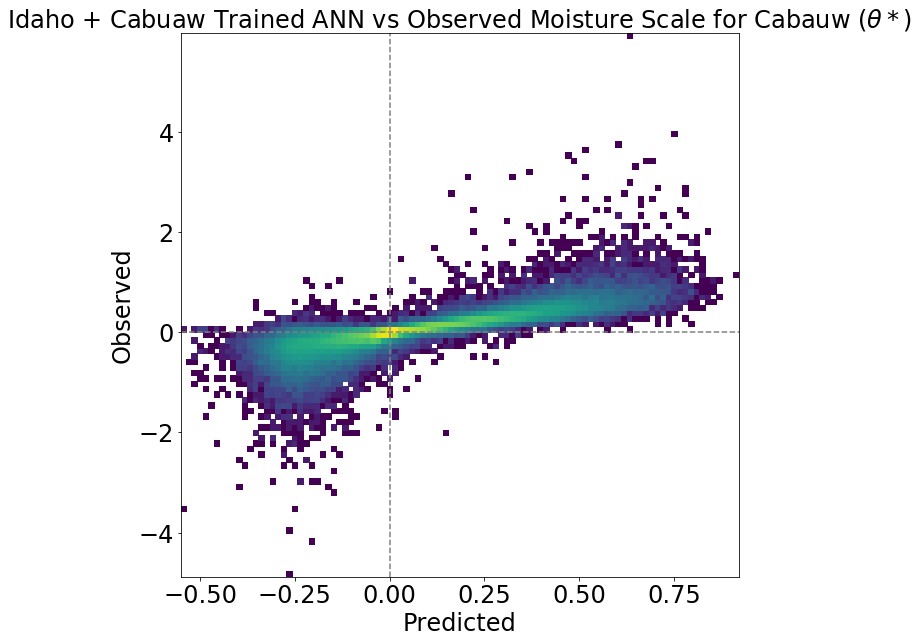

In [451]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsM_Cabauw_All
y = test_labelsMC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Moisture Scale for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-cabauw_Observed_mscale.png')
plt.show()

The R^2 value is... 0.9281857312455808


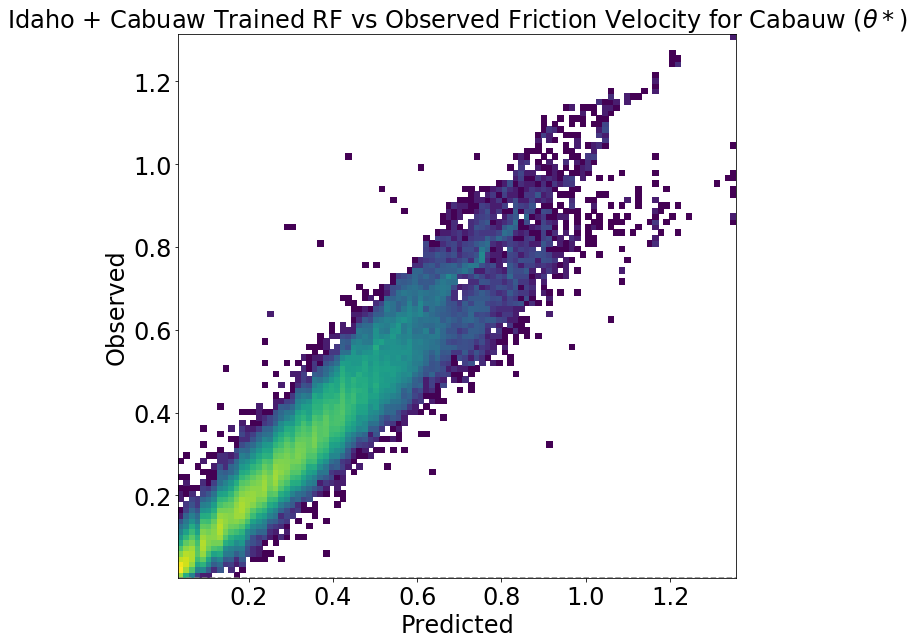

In [452]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predictionsF_Cabauw_All
y = test_labelsFC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained RF vs Observed Friction Velocity for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_all-on-cabauw_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.9301802884067307


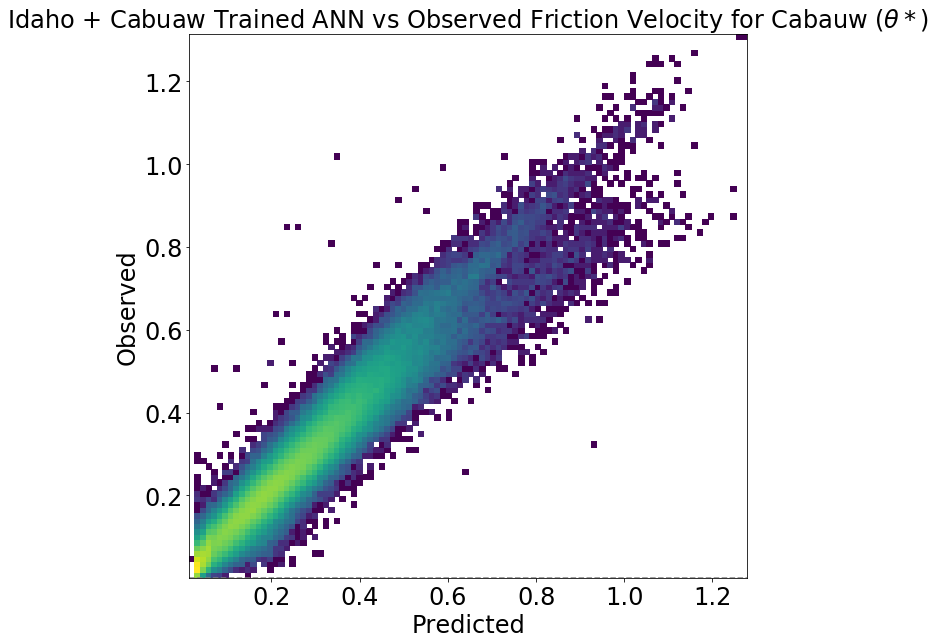

In [453]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredictionsF_Cabauw_All
y = test_labelsFC
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('Idaho + Cabuaw Trained ANN vs Observed Friction Velocity for Cabauw ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_all-on-cabauw_Observed_friction-velocity.png')
plt.show()

In [454]:
# Split results by Bulk Richardson Number
TestCF = datasetTestC
TestCF['FrictionVelocityTestC'] = FrictionVelocityTestC
TestCM = datasetTestC
TestCM['MoistureScaleTestC'] = MoistureScaleTestC
TestCT = datasetTestC
TestCT['TemperatureScaleTestC'] = TemperatureScaleTestC

test_featuresMC_Neg = TestCM.loc[TestCM['10m Bulk Richardson']<0]
test_labelsMC_Neg = test_featuresMC_Neg['MoistureScaleTestC']
test_featuresMC_Neg = test_featuresMC_Neg.drop(columns=['MoistureScaleTestC'])
test_featuresMC_Pos = TestCM.loc[TestCM['10m Bulk Richardson']>0]
test_labelsMC_Pos = test_featuresMC_Pos['MoistureScaleTestC']
test_featuresMC_Pos = test_featuresMC_Pos.drop(columns=['MoistureScaleTestC'])
predMC_Neg = rfMC.predict(test_featuresMC_Neg.iloc[:,0:16]) 
predMC_Pos = rfMC.predict(test_featuresMC_Pos.iloc[:,0:16])
ANNpredMC_Neg = ANN_MC.predict(np.asarray(test_featuresMC_Neg.iloc[:,0:16])) 
ANNpredMC_Pos = ANN_MC.predict(np.asarray(test_featuresMC_Pos.iloc[:,0:16]))

ANNpredMC_Neg = ANNpredMC_Neg.reshape(len(ANNpredMC_Neg,))
ANNpredMC_Pos = ANNpredMC_Pos.reshape(len(ANNpredMC_Pos,))

test_featuresTC_Neg = TestCT.loc[TestCT['10m Bulk Richardson']<0]
test_labelsTC_Neg = test_featuresTC_Neg['TemperatureScaleTestC']
test_featuresTC_Neg = test_featuresTC_Neg.drop(columns=['TemperatureScaleTestC'])
test_featuresTC_Pos = TestCT.loc[TestCT['10m Bulk Richardson']>0]
test_labelsTC_Pos = test_featuresTC_Pos['TemperatureScaleTestC']
test_featuresTC_Pos = test_featuresTC_Pos.drop(columns=['TemperatureScaleTestC'])
predTC_Neg = rfTC.predict(test_featuresTC_Neg.iloc[:,0:16])  
predTC_Pos = rfTC.predict(test_featuresTC_Pos.iloc[:,0:16]) 
ANNpredTC_Neg = ANN_TC.predict(np.asarray(test_featuresTC_Neg.iloc[:,0:16]))  
ANNpredTC_Pos = ANN_TC.predict(np.asarray(test_featuresTC_Pos.iloc[:,0:16])) 

ANNpredTC_Neg = ANNpredTC_Neg.reshape(len(ANNpredTC_Neg,))
ANNpredTC_Pos = ANNpredTC_Pos.reshape(len(ANNpredTC_Pos,))

test_featuresFC_Neg = TestCF.loc[TestCF['10m Bulk Richardson']<0]
test_labelsFC_Neg = test_featuresFC_Neg['FrictionVelocityTestC']
test_featuresFC_Neg = test_featuresFC_Neg.drop(columns=['FrictionVelocityTestC'])
test_featuresFC_Pos = TestCF.loc[TestCF['10m Bulk Richardson']>0]
test_labelsFC_Pos = test_featuresFC_Pos['FrictionVelocityTestC']
test_featuresFC_Pos = test_featuresFC_Pos.drop(columns=['FrictionVelocityTestC'])
predFC_Neg = rfFC.predict(test_featuresFC_Neg.iloc[:,0:16])  
predFC_Pos = rfFC.predict(test_featuresFC_Pos.iloc[:,0:16])  
ANNpredFC_Neg = ANN_FC.predict(np.asarray(test_featuresFC_Neg.iloc[:,0:16]))  
ANNpredFC_Pos = ANN_FC.predict(np.asarray(test_featuresFC_Pos.iloc[:,0:16]))

ANNpredFC_Neg = ANNpredFC_Neg.reshape(len(ANNpredFC_Neg,))
ANNpredFC_Pos = ANNpredFC_Pos.reshape(len(ANNpredFC_Pos,))

The R^2 value is... 0.9454392203306208


/Users/mccandle/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


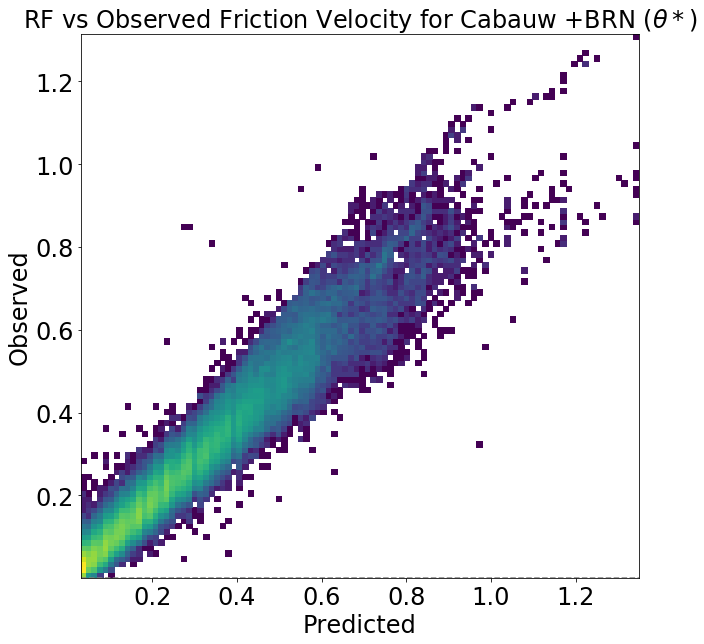

In [455]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predFC_Pos
y = test_labelsFC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Friction Velocity for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_pos_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.9465163296810595


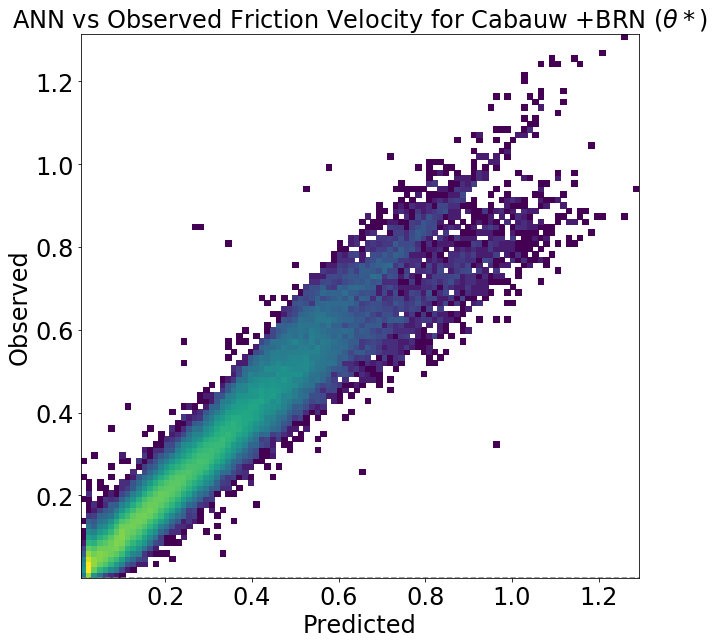

In [456]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredFC_Pos
y = test_labelsFC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Friction Velocity for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_pos_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8894722676939197


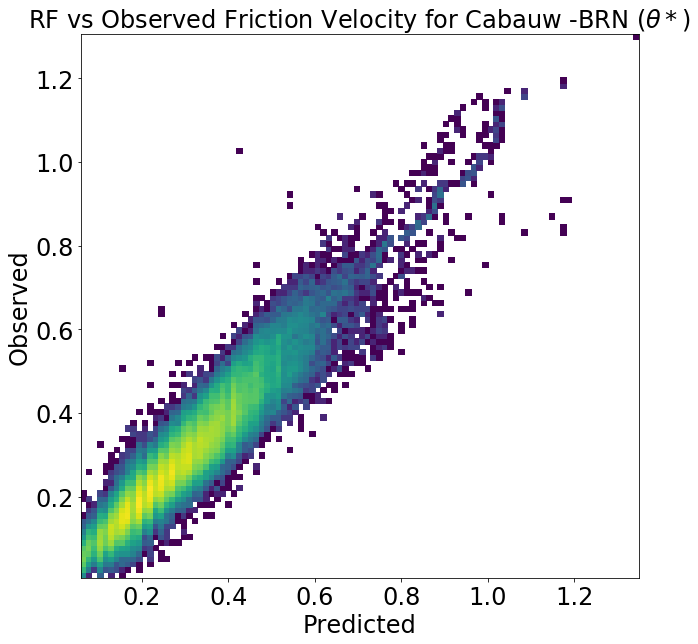

In [457]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predFC_Neg
y = test_labelsFC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Friction Velocity for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_neg_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.8951226939850279


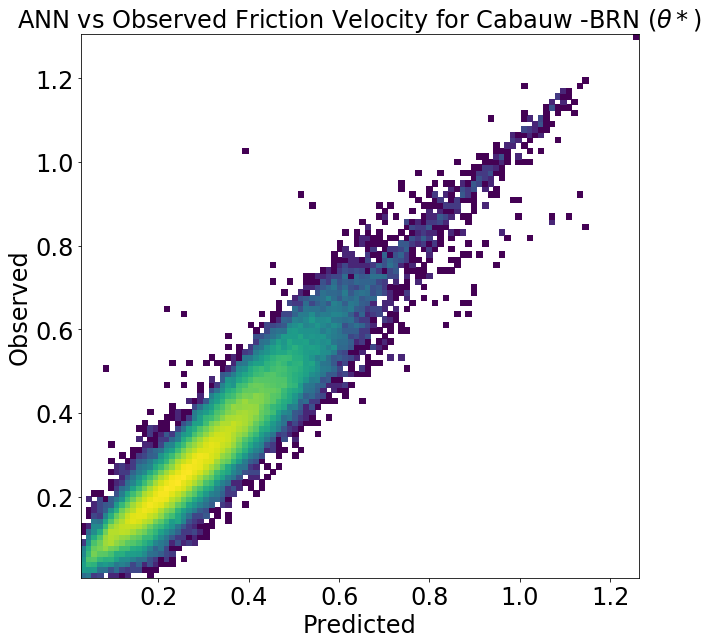

In [458]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredFC_Neg
y = test_labelsFC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Friction Velocity for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_neg_BRN_Observed_friction-velocity.png')
plt.show()

The R^2 value is... 0.49967421807161294


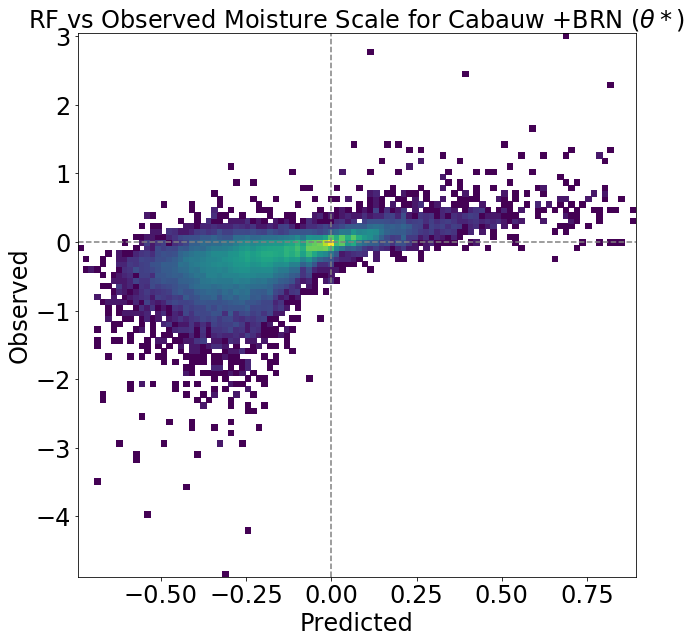

In [459]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predMC_Pos
y = test_labelsMC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Moisture Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_pos_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.45923483796871245


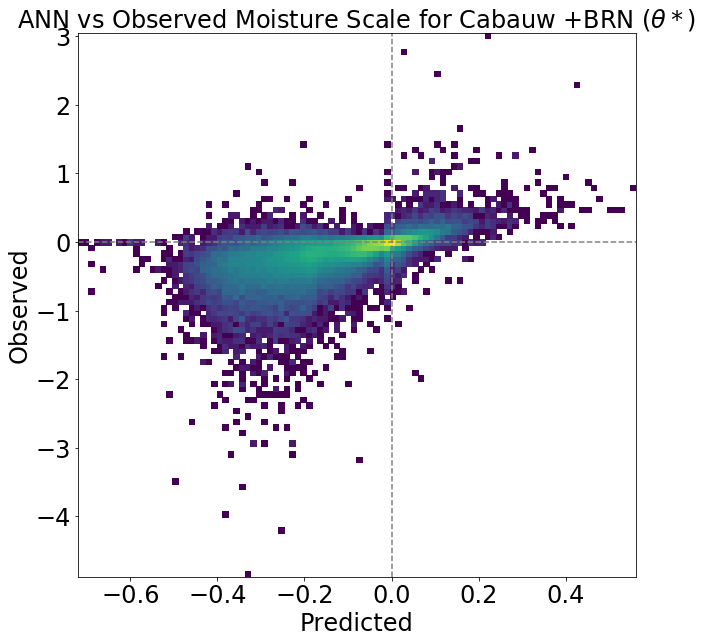

In [460]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredMC_Pos
y = test_labelsMC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Moisture Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_pos_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.7652387601746068


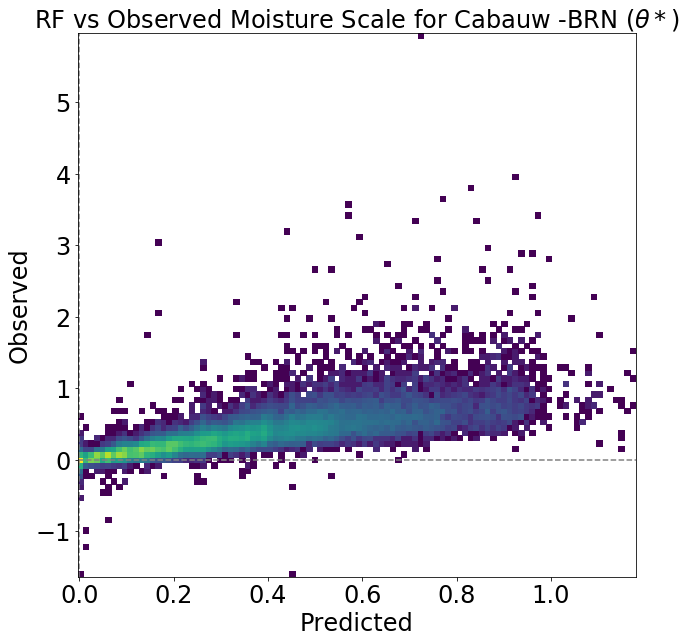

In [461]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predMC_Neg
y = test_labelsMC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Moisture Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_neg_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.776398938904772


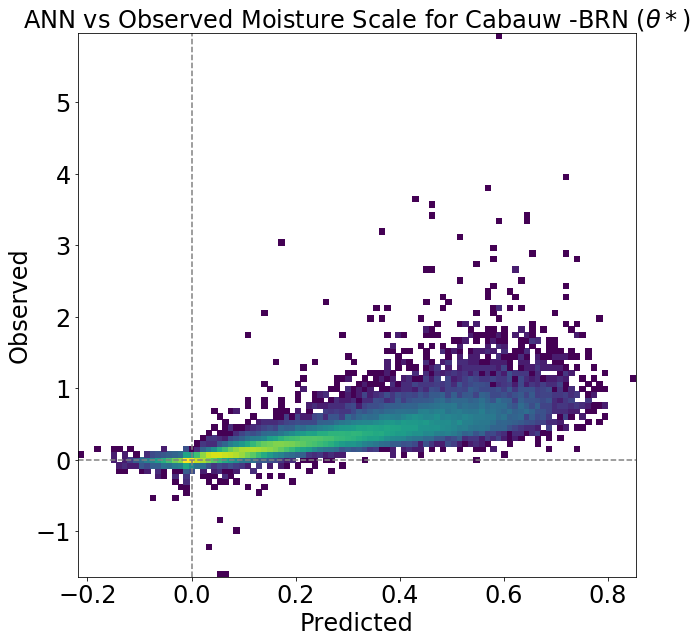

In [462]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredMC_Neg
y = test_labelsMC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Moisture Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_neg_BRN_Observed_mscale.png')
plt.show()

The R^2 value is... 0.437443938684861


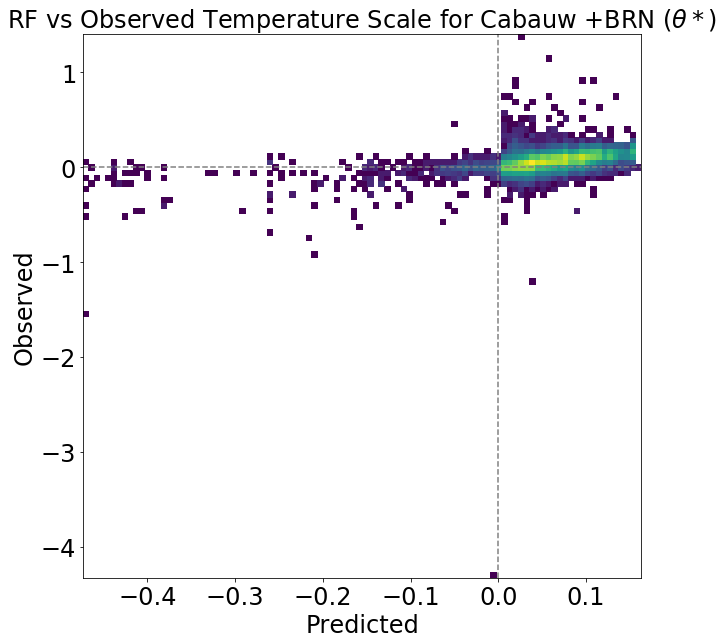

In [463]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predTC_Pos
y = test_labelsTC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Temperature Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_pos_BRN_Observed_tscale.png')
plt.show()

The R^2 value is... 0.3968970786357464


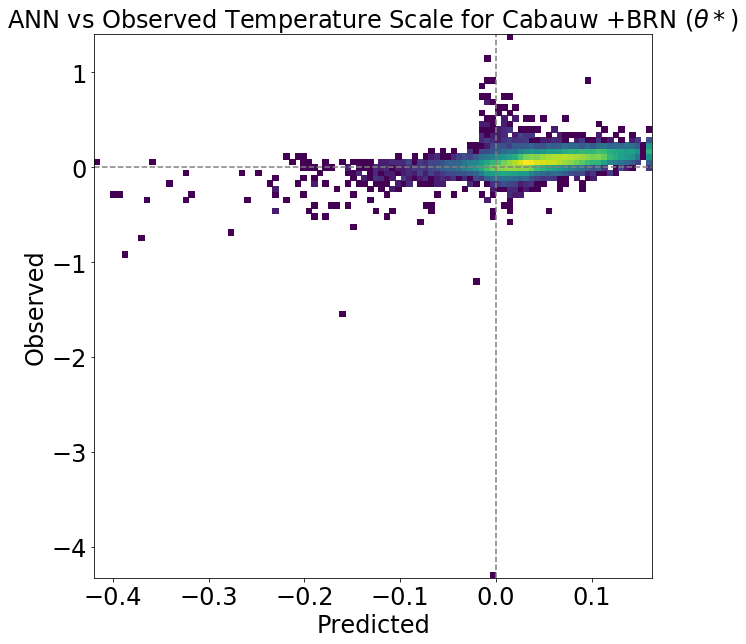

In [464]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredTC_Pos
y = test_labelsTC_Pos
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Temperature Scale for Cabauw +BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_pos_BRN_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7726103025583706


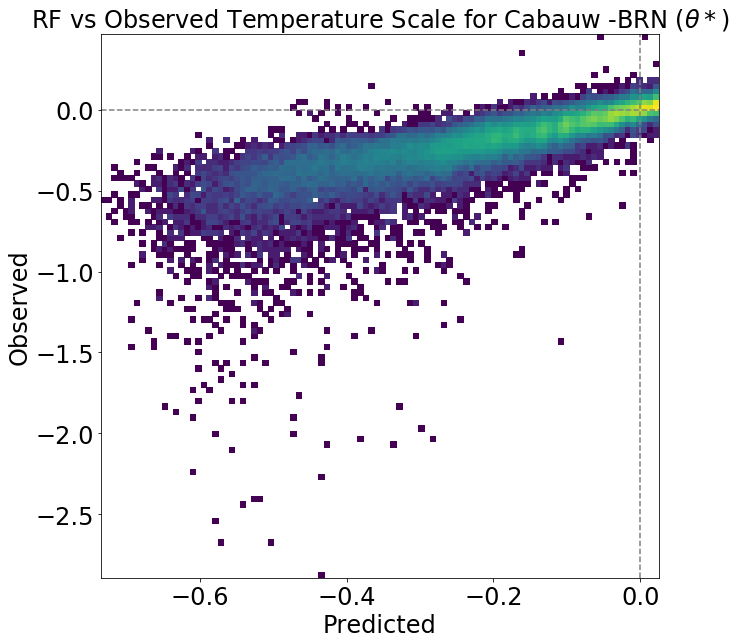

In [465]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = predTC_Neg
y = test_labelsTC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('RF vs Observed Temperature Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('RF_cabauw_neg_BRN_Observed_tscale.png')
plt.show()

The R^2 value is... 0.7705589169363223


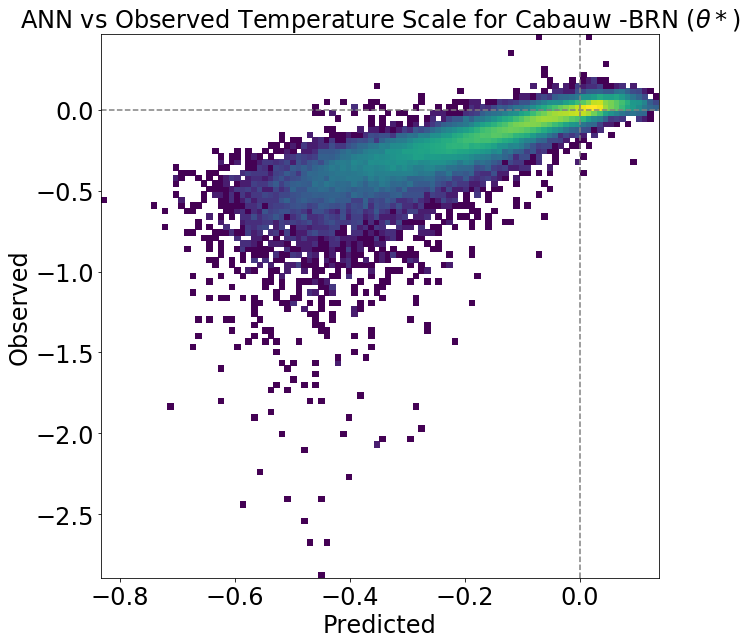

In [466]:
## Plots below after flux and met data are joined together...
from matplotlib.colors import LogNorm
from scipy import stats
plt.rcParams['figure.figsize'] = [10, 10]
x = ANNpredTC_Neg
y = test_labelsTC_Neg
x = x[y>-5] # Filter out a bad data point
y = y[y>-5] # Filter out a bad data point
plt.hist2d(x, y, bins=100, cmin=1, norm=LogNorm())
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept
r2 = np.corrcoef(x, y)[0, 1] ** 2
print("The R^2 value is...",r2)
plt.axhline(0,color='gray',linestyle = '--') # x = 0
plt.axvline(0,color='gray',linestyle = '--') # y = 0
plt.title('ANN vs Observed Temperature Scale for Cabauw -BRN ($\\theta *$)', size = 24)
plt.xlabel('Predicted', size = 24)
plt.ylabel('Observed', size = 24)
#plt.plot(np.linspace(2, -15), np.linspace(2, -15), 'k--')
plt.savefig('ANN_cabauw_neg_BRN_Observed_tscale.png')
plt.show()

In [53]:
# Predict whether the temperature scale is postive or negative, and then train separate Regime-Dependent-RF's (RD-RFs)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
t_scale_class = RandomForestClassifier(n_estimators = 10, n_jobs=4, max_features="sqrt",
                                       min_samples_split=2,min_samples_leaf=1, class_weight="balanced")
t_scale_class.fit(train_featuresT.iloc[:,0:19], np.where(train_labelsT >= 0, 1, -1))

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [74]:
# Compute the confusion matrix
from sklearn.metrics import mean_absolute_error, r2_score, confusion_matrix
t_scale_sign_preds = t_scale_class.predict(test_featuresT.iloc[:,0:19])
test_sign_labels = np.where(test_labelsT >= 0, 1, -1)
print("Confusion matrix comparing test data labels and predictions")
confusion_matrix(test_sign_labels, t_scale_sign_preds)

Confusion matrix comparing test data labels and predictions


array([[5530,  635],
       [ 297, 5308]])

In [85]:
# Train random forest on negative temperature scales
t_scale_neg_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
neg_t_scale = train_labelsT < 0
train_data = train_featuresT.iloc[:,0:19]
input_cols = featuresF
t_scale_neg_reg.fit(train_data.loc[neg_t_scale, input_cols], 
                    np.log(-train_labelsT[neg_t_scale]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [86]:
# Train random forest on positive temperature scales
t_scale_pos_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
pos_t_scale = train_labelsT > 0
t_scale_pos_reg.fit(train_data.loc[pos_t_scale, input_cols], 
                    np.log(train_labelsT[pos_t_scale]))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=4,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=2, verbose=0, warm_start=False)

In [87]:
# Make predictions on test data
test_data = test_featuresF.iloc[:,0:19]
t_scale_pos_preds = t_scale_pos_reg.predict(test_data[input_cols])
t_scale_neg_preds = t_scale_neg_reg.predict(test_data[input_cols])

In [88]:
# Combine both positive and negative predictions
t_scale_combined_preds = np.where(t_scale_sign_preds > 0, np.exp(t_scale_pos_preds), -np.exp(t_scale_neg_preds))

Text(0.5,0,'MAE: 0.0795 R$^2$: 0.659')

/home/dgagne/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


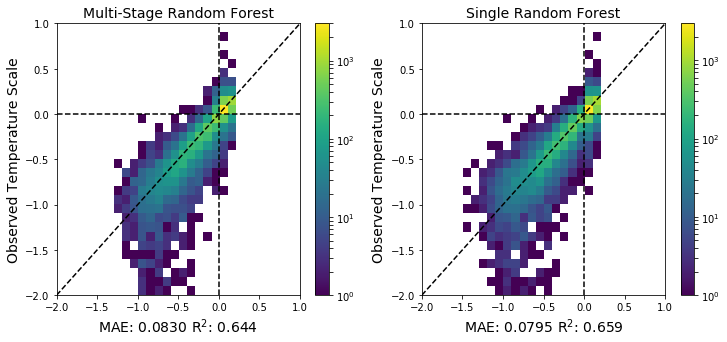

In [89]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(t_scale_combined_preds, test_labelsT, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')
plt.colorbar()
plt.title("Multi-Stage Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
mae_rf_multi = mean_absolute_error(test_labelsT, t_scale_combined_preds)
r2_rf_multi = r2_score(test_labelsT, t_scale_combined_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_multi, r2_rf_multi), fontsize=14)
plt.subplot(1, 2, 2)
rf_t_scale_preds = predictionsT
plt.hist2d(rf_t_scale_preds, test_labelsT, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')

plt.title("Single Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
plt.colorbar()

mae_rf_single = mean_absolute_error(test_labelsT, rf_t_scale_preds)
r2_rf_single = r2_score(test_labelsT, rf_t_scale_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_single, r2_rf_single), fontsize=14)

Confusion matrix comparing test data labels and predictions
[[1827 2113]
 [ 559 7271]]


Text(0.5,0,'MAE: 0.0237 R$^2$: 0.426')

/home/dgagne/miniconda3/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


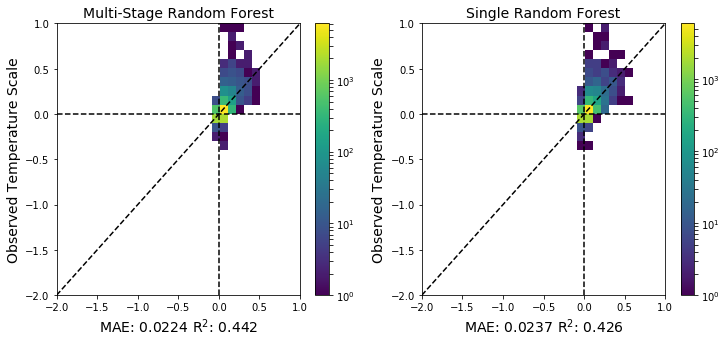

In [98]:
# Predict whether the temperature scale is postive or negative, and then train separate Regime-Dependent-RF's (RD-RFs)
m_scale_class = RandomForestClassifier(n_estimators = 50, n_jobs=4, max_features="sqrt",
                                       min_samples_split=2,min_samples_leaf=1, class_weight="balanced")
m_scale_class.fit(train_featuresM.iloc[:,0:19], np.where(train_labelsM >= 0, 1, -1))

# Compute the confusion matrix
m_scale_sign_preds = m_scale_class.predict(test_featuresM.iloc[:,0:19])
test_sign_labels = np.where(test_labelsM >= 0, 1, -1)
print("Confusion matrix comparing test data labels and predictions")
print(confusion_matrix(test_sign_labels, m_scale_sign_preds))

# Train random forest on negative temperature scales
m_scale_neg_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
neg_m_scale = train_labelsM < 0
train_data = train_featuresM.iloc[:,0:19]
input_cols = featuresF
m_scale_neg_reg.fit(train_data.loc[neg_m_scale, input_cols], 
                    np.log(-train_labelsM[neg_m_scale]))

# Train random forest on positive temperature scales
m_scale_pos_reg = RandomForestRegressor(n_estimators= 50, random_state=2, n_jobs=4,criterion='mse',
                                        min_samples_split=4,min_samples_leaf=2)
pos_m_scale = train_labelsM > 0
m_scale_pos_reg.fit(train_data.loc[pos_m_scale, input_cols], 
                    np.log(train_labelsM[pos_m_scale]))

# Make predictions on test data
test_data = test_featuresM.iloc[:,0:19]
m_scale_pos_preds = m_scale_pos_reg.predict(test_data[input_cols])
m_scale_neg_preds = m_scale_neg_reg.predict(test_data[input_cols])
# Combine both positive and negative predictions
m_scale_combined_preds = np.where(m_scale_sign_preds > 0, np.exp(m_scale_pos_preds), -np.exp(m_scale_neg_preds))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(m_scale_combined_preds, test_labelsM, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')
plt.colorbar()
plt.title("Multi-Stage Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
mae_rf_multi = mean_absolute_error(test_labelsM, m_scale_combined_preds)
r2_rf_multi = r2_score(test_labelsM, m_scale_combined_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_multi, r2_rf_multi), fontsize=14)
plt.subplot(1, 2, 2)
rf_m_scale_preds = predictionsM
plt.hist2d(rf_m_scale_preds, test_labelsM, cmin=1, bins=np.linspace(-2,1,31), norm=LogNorm())
plt.xlim(-2, 1)
plt.ylim(-2, 1)
plt.plot(np.linspace(-2, 1), np.linspace(-2, 1), 'k--')
plt.plot(np.zeros(50), np.linspace(-2, 1), 'k--')
plt.plot(np.linspace(-2, 1), np.zeros(50), 'k--')

plt.title("Single Random Forest", fontsize=14)
plt.ylabel("Observed Temperature Scale", fontsize=14)
plt.colorbar()

mae_rf_single = mean_absolute_error(test_labelsM, rf_m_scale_preds)
r2_rf_single = r2_score(test_labelsM, rf_m_scale_preds)
plt.xlabel("MAE: {0:0.4f} R$^2$: {1:0.3f}".format(mae_rf_single, r2_rf_single), fontsize=14)